## **ANÁLISIS BIIVARIANTE DE LAS VARIABLES PRINCIPALES**

En este fichero llevaré a cabo un análisis cruzado de las variables principales con el objetivo de poder constestar a las hipótesis planteadas

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import regex as re
from lxml import etree as et
from itertools import repeat
import csv
import random
import time
from tqdm import tqdm_notebook # tqdm_notebook es una herramienta que permite mostrar barra de progreso al trabajar con bucles grandes
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import math
from ast import literal_eval
import sys
sys.path.append('data')
import Funciones

In [3]:
from importlib import reload
import Funciones
reload(Funciones)


<module 'Funciones' from '/Users/jaimeinchaurraga/Documents/GitHub/ONLINE_DS_THEBRIDGE_jaimeinchaurraga/EDA_Entrega/Funciones.py'>


### INDICE
- [Primeros Pasos](#Primeros-Pasos)
- [Relacion Categoricas](#Relacion-Categoricas)
- [Conclusiones Categoricas](#Conclusiones-Categoricas)
- [Relacion Combinadas](#Relacion-Combinadas)
- [Conclusiones Combinadas](#Conclusiones-Combinadas)
- [Relacion Numericas](#Relacion-Numericas)
- [Conclusiones Numericas](#Conclusiones-Numericas)


- He tenido que quitar las tildes y caracteres expeciales para evitar problemas de formato con las anclas

<a id="Primeros-Pasos"></a>

## Primeros Pasos

Comprobar que los datos son correctos y cargar el código necesario para poder ealizar el análisis 

In [4]:
df = pd.read_csv('data/backloggd_dataset_limpio_dos.csv')

In [252]:
df.head()

,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist,GameID
0,Elden Ring,2022-02-25,"['FromSoftware', 'Bandai Namco Entertainment']",4.5,6200,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","['👍', 'A good effort from konami, but at the e...","['Windows PC', 'PlayStation 4', 'Xbox One', 'P...",33000,5200,8700,7300,0
1,The Legend of Zelda: Tears of the Kingdom,2023-05-12,"['Nintendo', 'Nintendo EPD Production Group No...",4.5,4200,"['Adventure', 'RPG']",The Legend of Zelda: Tears of the Kingdom is t...,['Legend of Zelda: Tears of the Kingdom is a v...,['Nintendo Switch'],16000,6500,6300,6900,1
2,The Legend of Zelda: Breath of the Wild,2017-03-03,"['Nintendo EPD Production Group No. 3', 'Ninte...",4.4,6600,"['Adventure', 'Puzzle', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,"['👍', 'very nice game, my first Legend of Zeld...","['Wii U', 'Nintendo Switch']",48000,3700,7600,3900,2
3,Hades,2018-12-07,['Supergiant Games'],4.3,4200,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,"[""I enjoyed it quite a bit, but with games lik...","['Windows PC', 'Mac', 'PlayStation 4', 'Xbox O...",35000,4400,10000,5300,3
4,Hollow Knight,2017-02-24,['Team Cherry'],4.4,4600,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"['This game is perfect, I immediately fell in ...","['Windows PC', 'Mac', 'Wii U', 'Linux', 'Ninte...",35000,3600,13000,3600,4


In [5]:
# Por alguna razón que desconozco, la variable de 'Release Date' pierde su formato de fecha cuando lo importo, por ello lo vuelvo a transformar antes de analizar los datos
# Convertir la columna 'Release Date' a formato de fecha
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')

In [6]:
# Agrupo en dos listas las variables según su tipo, por si posteriormente tengo que trabajar con ellas de forma conjunta

# Lista de nombres de columnas categóricas
columnas_categoricas = ['Title', 'Team', 'Genres', 'Summary', 'Reviews', 'Platforms']

# Lista de nombres de columnas categóricas sin algunas columnas --> son las más importantes
columnas_categoricas_core = ['Title', 'Team', 'Genres', 'Platforms']

# Lista de nombres de columnas numéricas
columnas_numericas = ['Avg. Rating', 'Times Listed', 'Plays', 'Playing', 'Backlogs', 'Wishlist']

# La columna 'Release Date' de tipo datetime64[ns] se deja fuera de estas listas

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30208 entries, 0 to 30207
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Title         30208 non-null  object        
 1   Release Date  30208 non-null  datetime64[ns]
 2   Team          30208 non-null  object        
 3   Avg. Rating   30208 non-null  float64       
 4   Times Listed  30208 non-null  int64         
 5   Genres        30208 non-null  object        
 6   Summary       30208 non-null  object        
 7   Reviews       30208 non-null  object        
 8   Platforms     30208 non-null  object        
 9   Plays         30208 non-null  int64         
 10  Playing       30208 non-null  int64         
 11  Backlogs      30208 non-null  int64         
 12  Wishlist      30208 non-null  int64         
 13  GameID        30208 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(6)
memory usage: 3.2+ MB


In [7]:
# EXPLOTAR LISTAS EN VARIABLES CATEGÓRICAS BUENA!
# En esta sección, creo una lógica que recorrerá los valores de las columnas, evaluará si son cadenas de texto que representan listas y en ese caso cambiarlas a objeto listas de python
# Esto es necesario para posteriormente poder aplicar aplicar el método explode que separa los valores de una lista a filas independientes
# Itero sobre las columnas que tienen la problemática
for col in ['Team', 'Genres', 'Platforms']:
    def eval_lists(val):  # la función toma un argumento val, que representa un valor individual dentro de la columna actual (col) sobre la que está iterando
        from ast import literal_eval

        if val == "Unknown":  # en el caso que aparezca 'Unknown' se cambia a lista vacía, así no da problemas y se mantiene la lógica que he aplicado a otras columnas cuando faltaban datos
            return []
        try: # Convertir la cadena a una lista de Python
            evaluated_val = literal_eval(val) if isinstance(val, str) else val #se evalúa el valor para ver si es una cadena (una falsa lista) y en ese caso se convierte a formato lista real. si no es una cadena no se hace nada
            if col == 'Platforms': # Tratamiento especial para la columna 'Platforms' PORQUE TIENE FORMATO RARO
                # Dividir cada elemento de la lista por comas y aplanar la lista resultante
                return [platform for sublist in evaluated_val for platform in sublist.split(', ')] if evaluated_val else []
            else:
                return evaluated_val
        except ValueError:
            print(f"Error al evaluar: {val}")
            return []

    df[col] = df[col].apply(eval_lists)


In [8]:
# Aquí llevo la explotación de cada lista para que se separen en filas individuales cada uno de los valores en las tres columnas, lo que me ayudará a analizar correctamente las modas y frecuencias 
# Hay que tener en cuenta que realmente estoy creando nuevos dataframes por cada variable explotada, o puedo mantenerlo en el mismo ya que cada valor explotado crea una nueva fila y por lo tanto
# rompería por completo mi dataset. A la hora de analizar y visualizar, tendré que tnerlo en cuenta

# Exploto la columna 'Genres'
df_exploded_genres = df.explode('Genres')
#frecuencias_genres = df_exploded_genres['Genres'].value_counts()
#moda_genres = df_exploded_genres['Genres'].mode()

# Exploto la columna 'Team'
df_exploded_team = df.explode('Team')
#frecuencias_team = df_exploded_team['Team'].value_counts()
#moda_team = df_exploded_team['Team'].mode()

# Exploto la columna 'Platforms'
df_exploded_platform = df.explode('Platforms')
#frecuencias_platform = df_exploded_platform['Platforms'].value_counts()
#moda_platform = df_exploded_platform['Platforms'].mode()

<a id="Relacion-Categoricas"></a>
## Relacion Categoricas

A continuación realizo un análisis de las varibales categóricas core para tratar de sacar correlaciones clave

### **Relación entre 'Genre' y 'Team'**

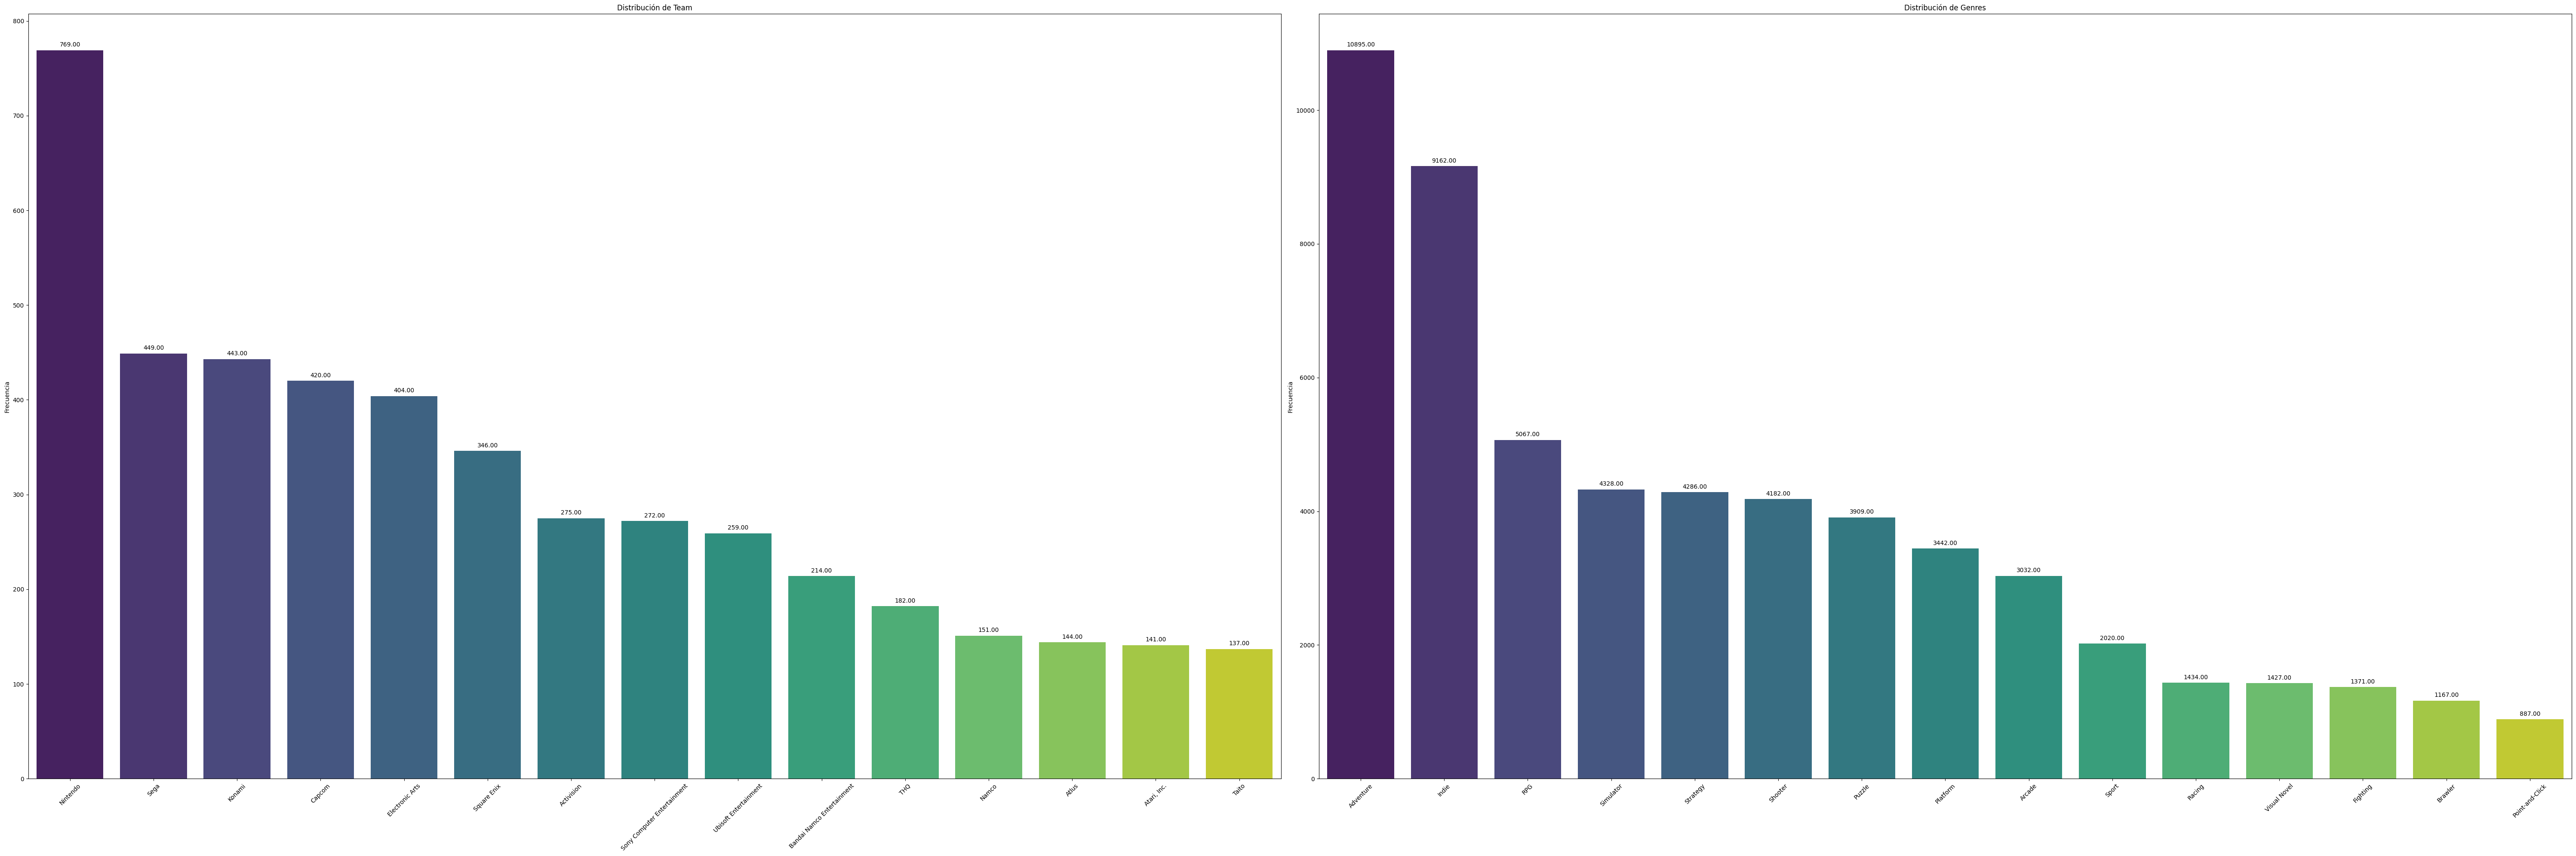

In [258]:
Funciones.pinta_distribucion_categoricas_dfs_mixtos([(df_exploded_team, 'Team'), (df_exploded_genres, 'Genres')], relativa=False, mostrar_valores=True, top_n=15)

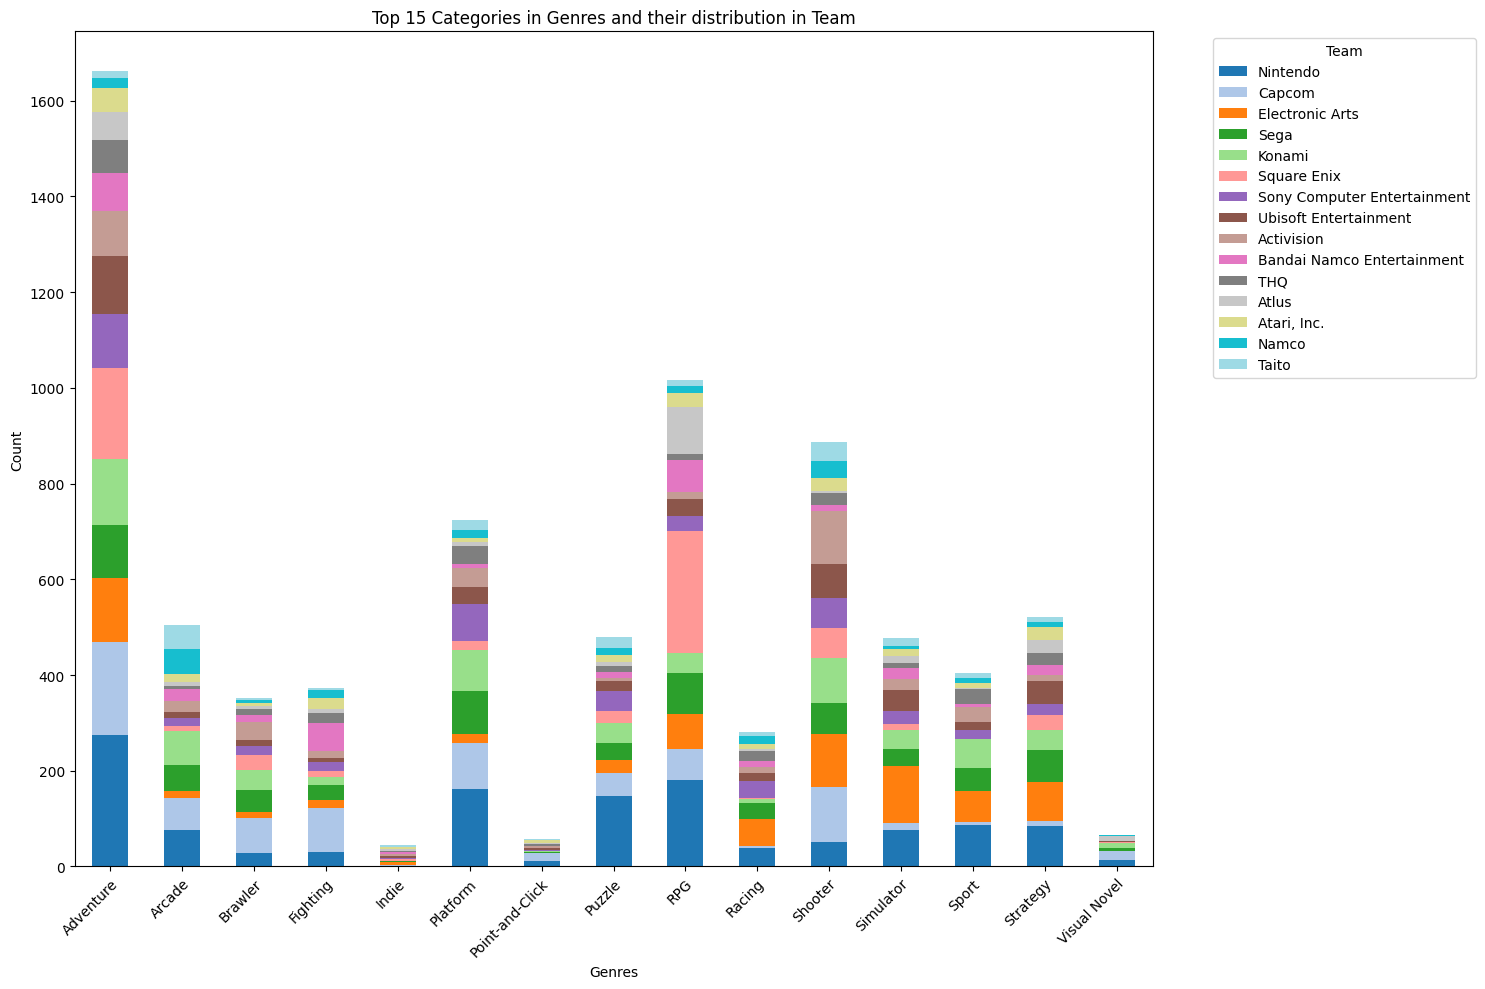

In [163]:
Funciones.plot_interactive_comparison_categorica(df_exploded_genres, 'Genres', df_exploded_team, 'Team', 'GameID', top_n=15,relative=False)

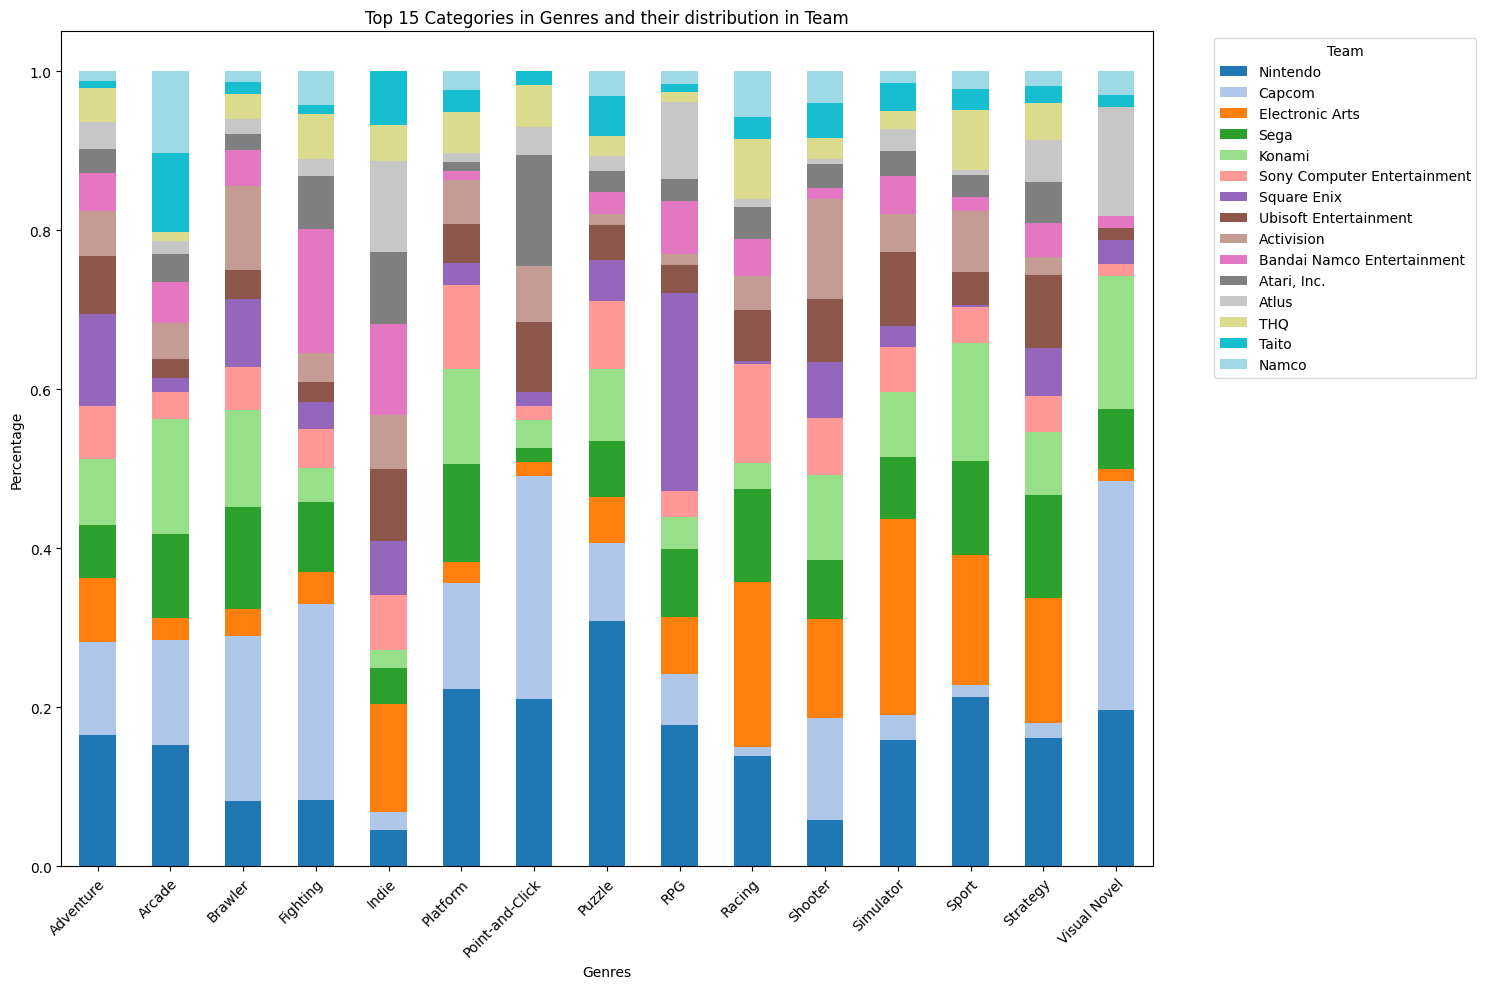

In [165]:
Funciones.plot_interactive_comparison_categorica(df_exploded_genres, 'Genres', df_exploded_team, 'Team', 'GameID', top_n=15,relative=True)

In [ ]:
'''

  - En los siguientes gráficos se muestran los 15 géneros con más videjuegos y su composición en términos absolutos y relativos al seleccionar las 15 compañías con más videojuegos

  - Parece que no existe una relevancia extrema por parte de ninguna compañía en cuanto a dominar por completo un género, lo que nos indica que las compañías más fuertes no se centran en generar
  videjuegos de un determinado género, sino que tratan de ofrecer todo tipo de videjuegos para tratar de competir con sus competidores en todo el mercado. O lo que es lo mismo: no existe ninguna compañía
  líder en el mercado que se especialice sólo en un género de videjuegos. Un claro ejemplo es 'Nintendo', la compañía líder en cuanto a número de juegos totales en el mercado

  - Dicho esto sí que hay casos donde hay compañías que tienen una relevancia notable en ciertos géneros, como es el caso de Capcom en los géneros 'Point and click', 'Visual Novel' y 'Fighting' o la compañía
Square Enix con el género 'RPG'

- En el caso inverso, resulta curioso como el género 'Indie' es en el que menos dominancia clara existe, esto se puede ver más claro si se añaden nuevas compañías a la gráfica, ya que cada vez se disipa aún más y se
generan nuevos y nuevos segmentos. Coomo ya expliqué anteriormente en el análsis univariante esto se debe a que es de los géneros con más videjuegos del mercado, pero suele estar compuesto por muchas compañías pequeñas,
una gran parte de ellas incluso sólo con un juego en el mercado
  
  
'''

In [208]:
Funciones.test_chi_cuadrado_dfs_exploded(df_exploded_genres, 'Genres', df_exploded_team, 'Team', 'GameID')

Valor Chi-Cuadrado: 342107.3043590343
P-Value: 0.0
Grados de Libertad: 246686

Tabla de Frecuencias Esperadas:
 [[0.54973513 0.18324504 0.18324504 ... 0.18324504 0.73298017 0.54973513]
 [0.15829225 0.05276408 0.05276408 ... 0.05276408 0.21105633 0.15829225]
 [0.07627452 0.02542484 0.02542484 ... 0.02542484 0.10169936 0.07627452]
 ...
 [0.04091052 0.01363684 0.01363684 ... 0.01363684 0.05454736 0.04091052]
 [0.04799119 0.01599706 0.01599706 ... 0.01599706 0.06398825 0.04799119]
 [0.07273419 0.02424473 0.02424473 ... 0.02424473 0.09697892 0.07273419]]


In [259]:
# Con este código puedo comprobar numéricamente que se muestran los equipos y géneros seleccionados en 'top_n' y que las correlaciones en la gráfica son correctas, tanto absoluta como relativamente

# Define el top_n
top_n = 10

# Obtén los top_n géneros y equipos más comunes
top_genres = df_exploded_genres['Genres'].value_counts().nlargest(top_n).index
top_teams = df_exploded_team['Team'].value_counts().nlargest(top_n).index

# Filtra los DataFrames por los top_n géneros y equipos
filtered_genres = df_exploded_genres[df_exploded_genres['Genres'].isin(top_genres)]
filtered_teams = df_exploded_team[df_exploded_team['Team'].isin(top_teams)]

# Realiza el merge
merged_df = pd.merge(filtered_genres[['GameID', 'Genres']], filtered_teams[['GameID', 'Team']], on='GameID')

# Agrupa por género y equipo y obtén el conteo
genre_team_counts = merged_df.groupby(['Genres', 'Team']).size().reset_index(name='Counts')

# Calcula las proporciones para cada género y convierte a formato de porcentaje
genre_team_counts['Proportion'] = (genre_team_counts.groupby('Genres')['Counts']
                                   .transform(lambda x: x / x.sum()) * 100).round(2)

# Ordena los resultados
genre_team_counts.sort_values(by=['Genres', 'Proportion'], ascending=[True, False], inplace=True)

pd.set_option('display.max_rows', 20) # activar si se quieren comprobat todos los resultados
# Muestra los resultados
genre_team_counts

,Genres,Team,Counts,Proportion
5,Adventure,Nintendo,274,18.91
2,Adventure,Capcom,195,13.46
8,Adventure,Square Enix,191,13.18
4,Adventure,Konami,137,9.45
3,Adventure,Electronic Arts,133,9.18
...,...,...,...,...
98,Strategy,Square Enix,31,7.35
97,Strategy,Sony Computer Entertainment,24,5.69
91,Strategy,Bandai Namco Entertainment,22,5.21
90,Strategy,Activision,12,2.84


In [135]:
# Compruebo que la información es correcta
# Filtrar el DataFrame para obtener todas las filas donde el equipo es 'Nintendo'
nintendo_games = df_exploded_team[df_exploded_team['Team'] == 'Nintendo']

# Contar el número de juegos creados por Nintendo
num_nintendo_games = nintendo_games.shape[0]

print(f"Número de juegos creados por Nintendo: {num_nintendo_games}")

# Realizar un merge con el DataFrame de géneros usando la columna 'GameID'
nintendo_games_with_genre = pd.merge(nintendo_games[['GameID']], df_exploded_genres[['GameID', 'Genres']], on='GameID')

# Agrupar por género y contar el número de juegos
nintendo_genre_counts = nintendo_games_with_genre.groupby('Genres').size().reset_index(name='Number of Games')

# Ordenar los resultados por número de juegos
nintendo_genre_counts.sort_values(by='Number of Games', ascending=False, inplace=True)

# Mostrar el resultado
nintendo_genre_counts

Número de juegos creados por Nintendo: 769


,Genres,Number of Games
0,Adventure,274
12,RPG,181
8,Platform,161
10,Puzzle,148
17,Sport,86
...,...,...
14,Real Time Strategy,14
21,Visual Novel,13
9,Point-and-Click,12
7,Pinball,6


In [136]:
# Con este código puedo comprobar numéricamente que se muestran los equipos y géneros seleccionados en 'top_n' y que las correlaciones en la gráfica son correctas, tanto absoluta como relativamente

# Define el top_n
top_n = 10

# Obtén los top_n géneros y equipos más comunes
top_genres = df_exploded_genres['Genres'].value_counts().nlargest(top_n).index
top_teams = df_exploded_team['Team'].value_counts().nlargest(top_n).index

# Filtra los DataFrames por los top_n géneros y equipos
filtered_genres = df_exploded_genres[df_exploded_genres['Genres'].isin(top_genres)]
filtered_teams = df_exploded_team[df_exploded_team['Team'].isin(top_teams)]

# Realiza el merge
merged_df = pd.merge(filtered_genres[['GameID', 'Genres']], filtered_teams[['GameID', 'Team']], on='GameID')

# Agrupa por género y equipo y obtén el conteo
genre_team_counts = merged_df.groupby(['Genres', 'Team']).size().reset_index(name='Counts')

# Calcula las proporciones para cada género y convierte a formato de porcentaje
genre_team_counts['Proportion'] = (genre_team_counts.groupby('Genres')['Counts']
                                   .transform(lambda x: x / x.sum()) * 100).round(2)

# Ordena los resultados
genre_team_counts.sort_values(by=['Genres', 'Proportion'], ascending=[True, False], inplace=True)

pd.set_option('display.max_rows', 20) # activar si se quieren comprobat todos los resultados
# Muestra los resultados
genre_team_counts

,Genres,Team,Counts,Proportion
5,Adventure,Nintendo,274,18.91
2,Adventure,Capcom,195,13.46
8,Adventure,Square Enix,191,13.18
4,Adventure,Konami,137,9.45
3,Adventure,Electronic Arts,133,9.18
...,...,...,...,...
98,Strategy,Square Enix,31,7.35
97,Strategy,Sony Computer Entertainment,24,5.69
91,Strategy,Bandai Namco Entertainment,22,5.21
90,Strategy,Activision,12,2.84


In [137]:
# Este código me ayuda a comprobar que lo que se me muestra en el gráfico tiene sentido
# Para ello, he filtrado para que se me muestren todos los juegos de activision filtrados por género
# Al comprobar los resultados con lo que veo en la gráfica parece tener match


if 'Genres' in df_exploded_genres.columns:
    # Filtrar df_exploded_team para obtener juegos de 'Activision'
    activision_team = df_exploded_team[df_exploded_team['Team'] == 'Activision']

    # Filtrar df_exploded_genres para incluir solo los IDs de juego de Activision
    activision_genres = df_exploded_genres[df_exploded_genres['GameID'].isin(activision_team['GameID'])]

    # Fusionar los DataFrames filtrados
    activision_data = pd.merge(activision_team[['GameID']], activision_genres[['GameID', 'Genres']], on='GameID')

    # Contar el número de juegos por género para 'Activision'
    activision_games_by_genre = activision_data.groupby('Genres').size()

    print(activision_games_by_genre)
else:
    print("La columna 'Genres' no se encuentra en df_exploded_genres.")

Genres
Adventure               94
Arcade                  23
Brawler                 37
Card & Board Game        2
Fighting                14
Indie                    3
Music                   13
Platform                40
Point-and-Click          4
Puzzle                   7
RPG                     14
Racing                  12
Real Time Strategy       6
Shooter                111
Simulator               23
Sport                   31
Strategy                12
Tactical                 6
Turn Based Strategy      2
dtype: int64


### **Relación entre 'Platforms' y 'Genre'**

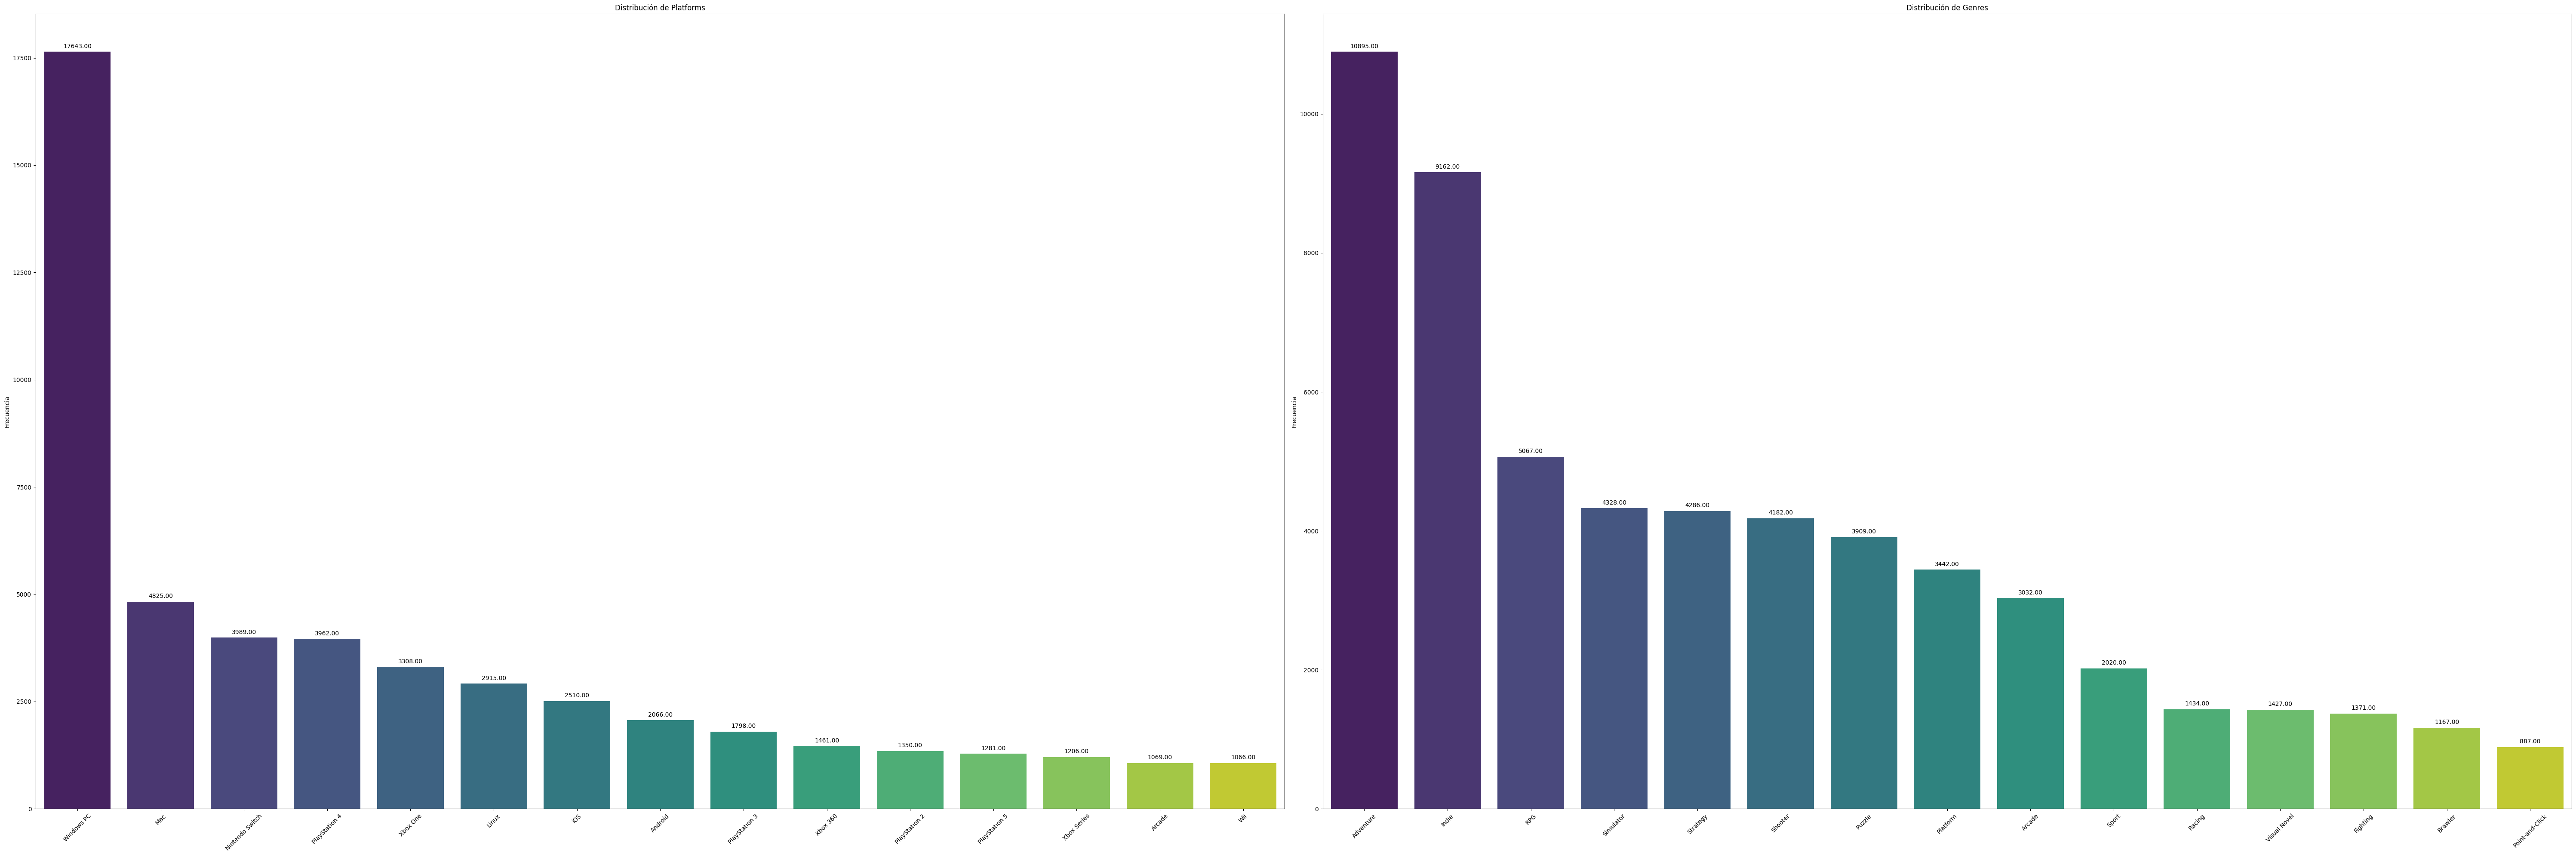

In [162]:
Funciones.pinta_distribucion_categoricas_dfs_mixtos([(df_exploded_platform, 'Platforms'), (df_exploded_genres, 'Genres')], relativa=False, mostrar_valores=True, top_n=15)

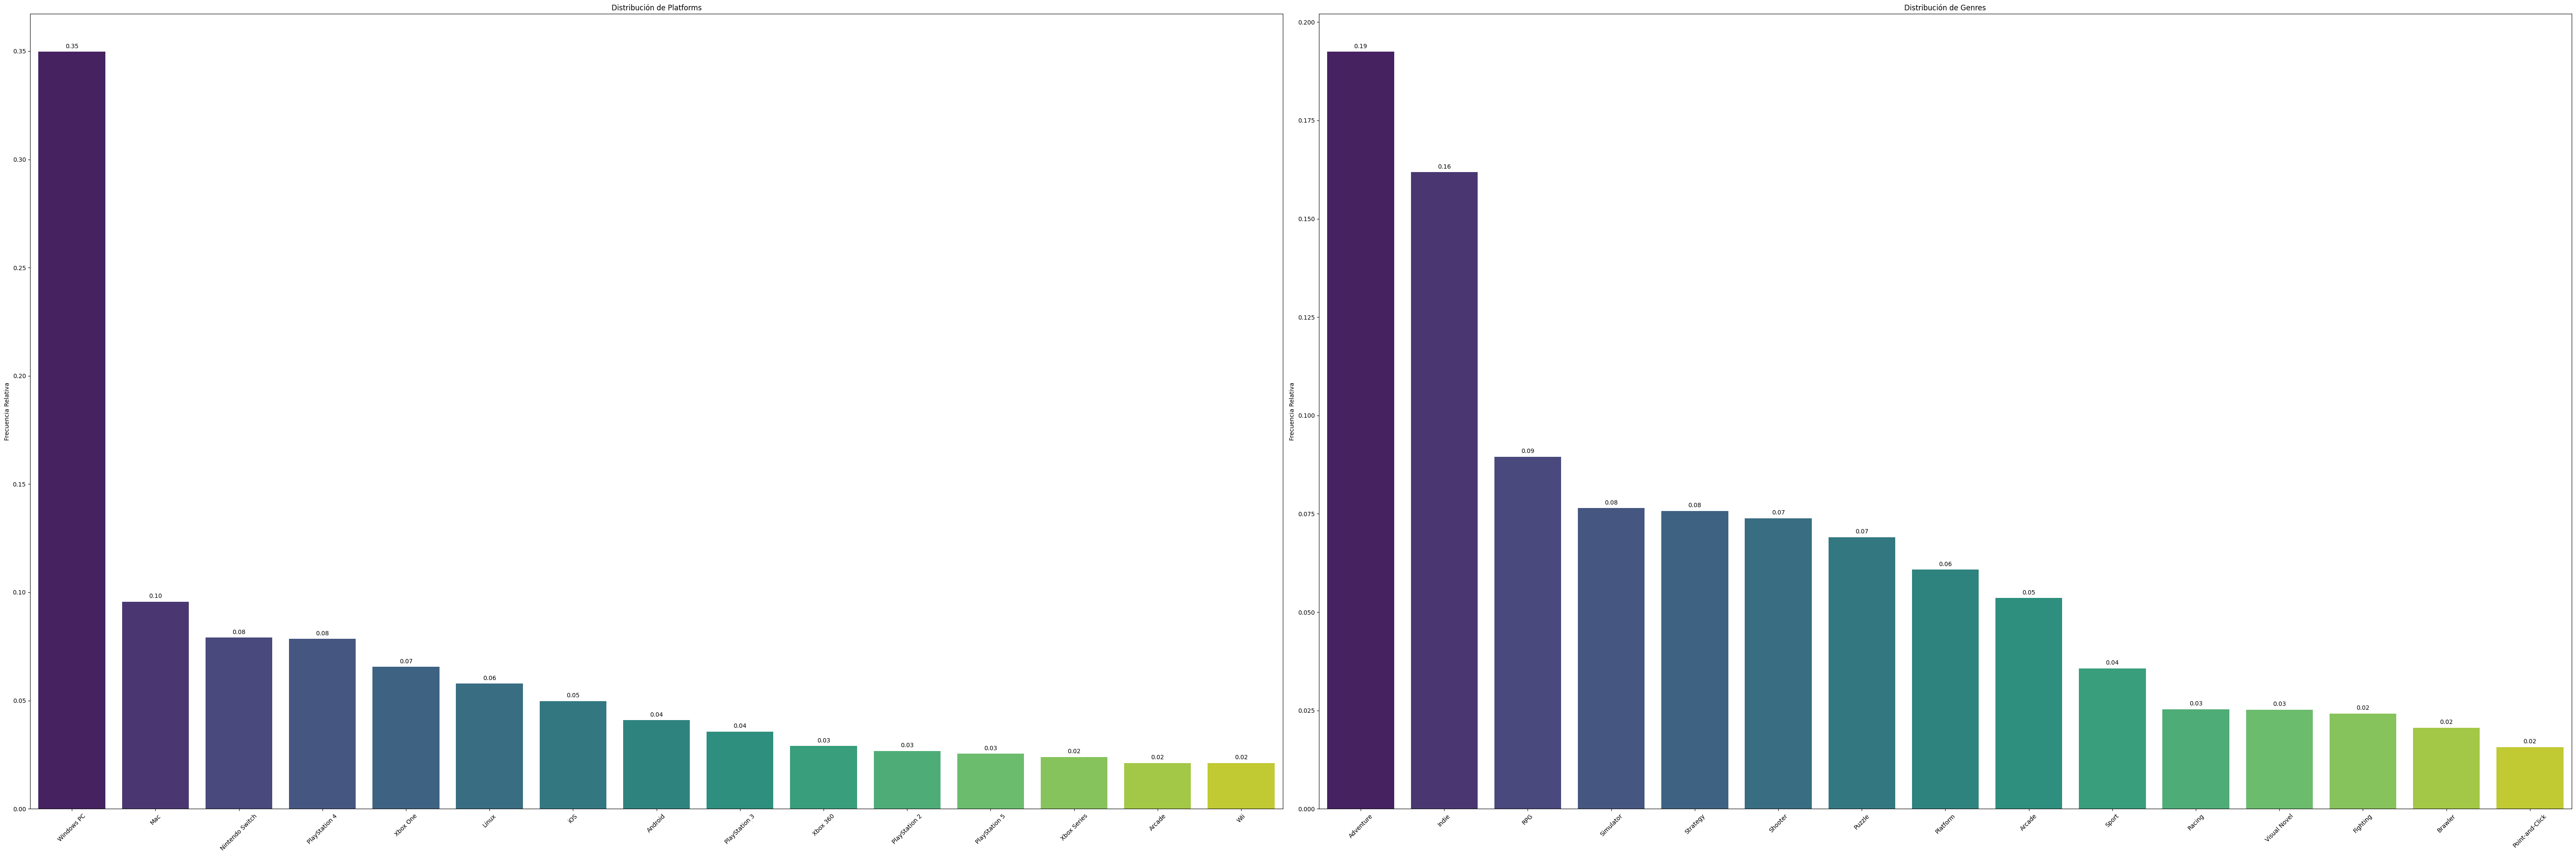

In [260]:
Funciones.pinta_distribucion_categoricas_dfs_mixtos([(df_exploded_platform, 'Platforms'), (df_exploded_genres, 'Genres')], relativa=True, mostrar_valores=True, top_n=15)

In [ ]:
'''
PLATFORMS
  - La plataforma que más destaca es 'Windows PC', ya que en términos absolutos existen un gran número de juegos disponibles. En términos relativos, en las 15 plataformas principales muestra que el 35% total de juegos están disponibles en esta plataforma
  - Cabe a destacar que en cambio en Mac sólo está disponible el 10%. Tal vez tenga que ver con que la mayoría de jugadores en ordenador suelen tener PC y por ello en muchos casos las compañías no optimicen versión para Mac
  - En tercer lugar se posiciona 'Nintendo Switch'. Sorprende el hecho que supere a otras plataformas populares y más asentadas en el tiempo. Más adelante trataré de entender la razón
'''

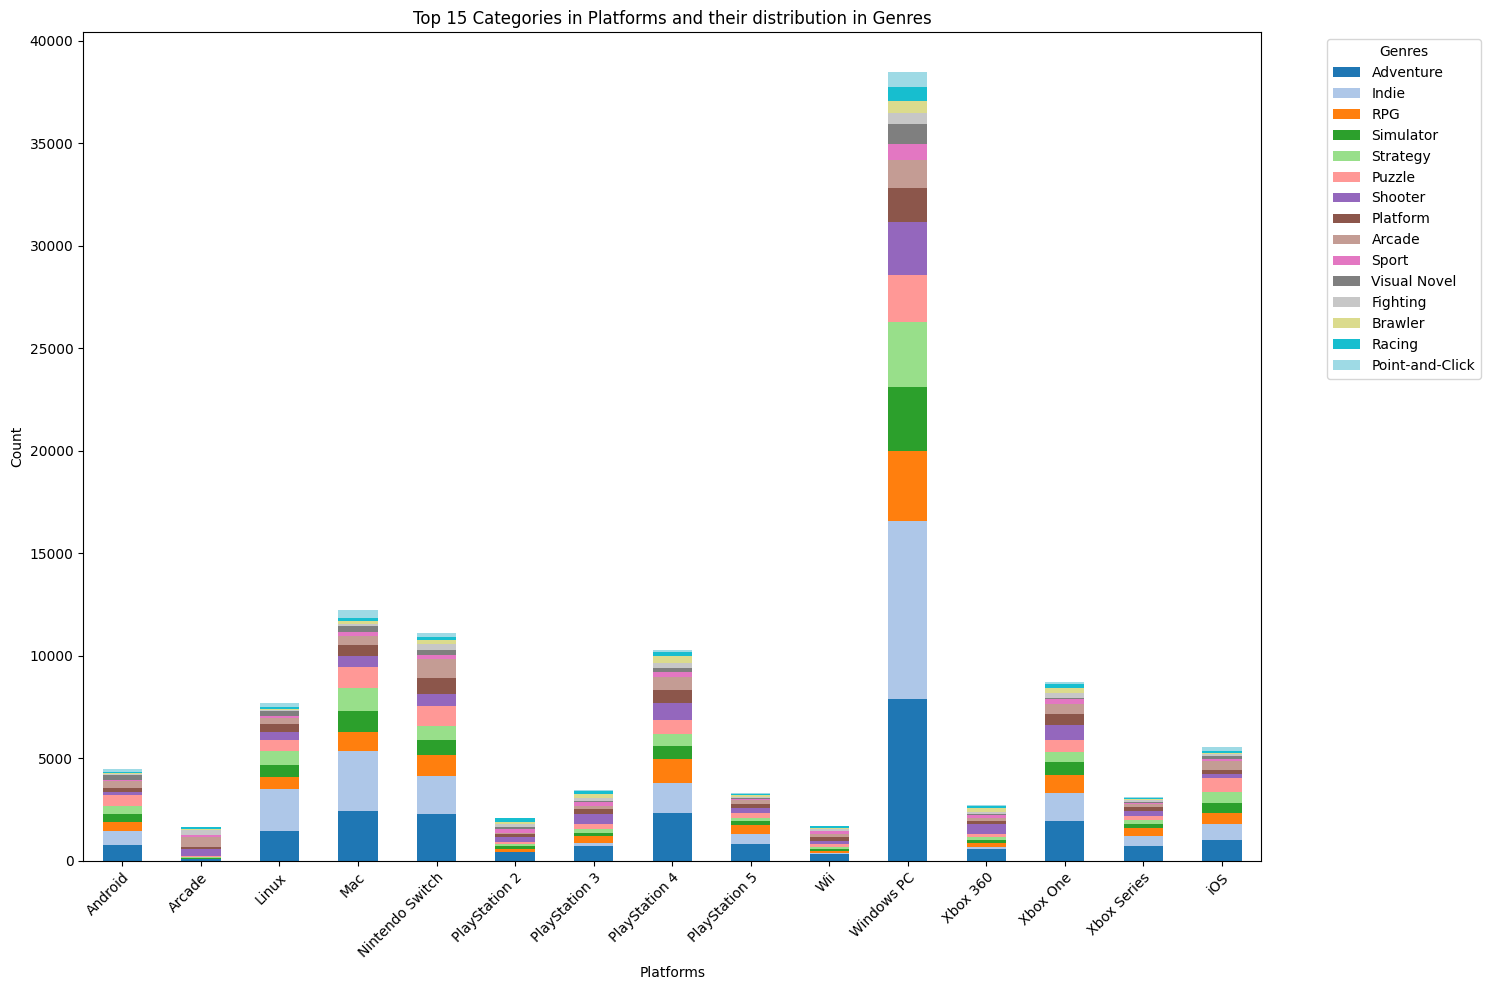

In [166]:
Funciones.plot_interactive_comparison_categorica(df_exploded_platform, 'Platforms', df_exploded_genres, 'Genres', 'GameID', top_n=15,relative=False)

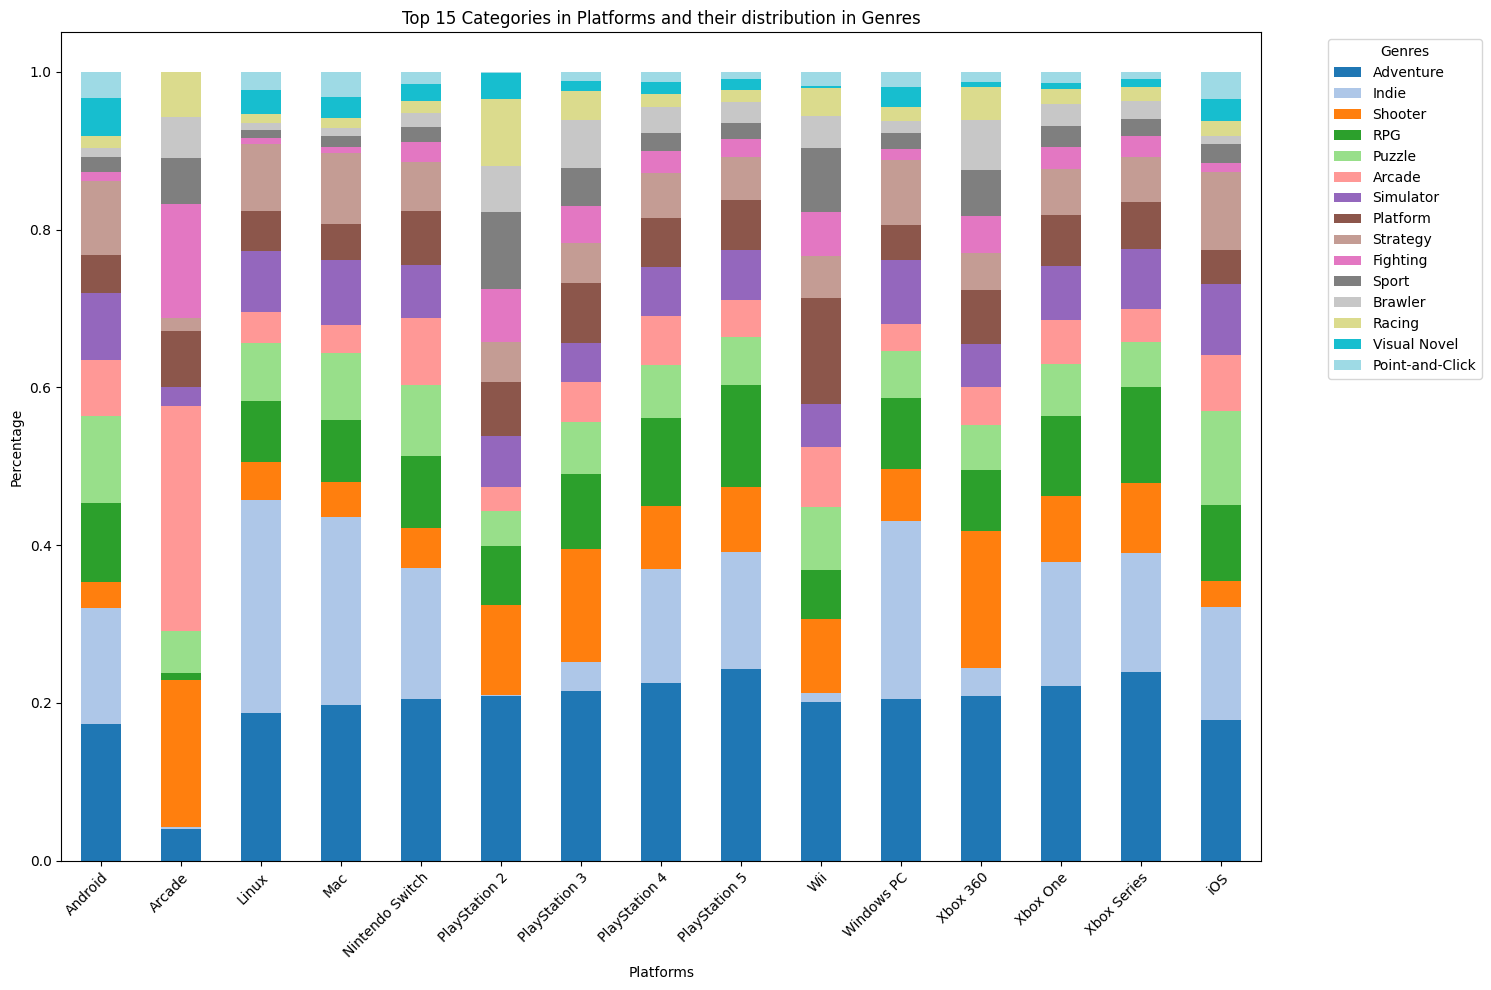

In [146]:
Funciones.plot_interactive_comparison_categorica(df_exploded_platform, 'Platforms', df_exploded_genres, 'Genres', 'GameID', top_n=15,relative=True)

In [ ]:
'''
El siguiente gráfico muesrtra las 15 plataformas con más juegos y cómo se componen en términos relativos si se seleccionan los 15 géneros más importantes
  - Parece que en líneas generales la composición es bastante similar en cuanto a géneros, lo que quiere decir que la mayoría de las plataformas ofrecen una gran variedad de juegos en los que poder elegir
  
  - En línea con lo comentado en la relación con Géneros y Plataformas, parece que se las compañías a la hora de crear juegos, quieren abarcar el mercado todo lo que puedan, es decir, se ofrecen juegos 
  de todos los géneros en todas las plataformas. Ejemplo: Pepito quiere jugar a juegos de 'Sport' en su Xbox 360. Evidentemente los porcentajes varían y la variedad de opciones dependerá de la plataforma,
  pero dicho de otra manera: "Se puede jugar de todo en todo"
  - Uno de los casos que más puede salirse de la norma está en el género 'Indie'. Debido a sus características parece que suelen estar mucho más disponibles en todas las plaformas que tengan que ver con ordenadores
  
'''

In [209]:

#print(df_exploded_platform.columns)
#print(df_exploded_genres.columns)

# Realiza la fusión de los DataFrames en la columna 'GameID'
#merged_df = pd.merge(df_exploded_platform[['GameID', 'Platforms']], df_exploded_genres[['GameID', 'Genres']], on='GameID')

# Crea la tabla de contingencia
#tabla_contingencia = pd.crosstab(merged_df['Platforms'], merged_df['Genres'])

# Muestra la tabla de contingencia
#tabla_contingencia.head()



In [210]:
Funciones.test_chi_cuadrado_dfs_exploded(df_exploded_platform, 'Platforms', df_exploded_genres, 'Genres', 'GameID')


Valor Chi-Cuadrado: 38639.432373184354
P-Value: 0.0
Grados de Libertad: 3806

Tabla de Frecuencias Esperadas:
 [[1.13025934e+00 3.44315600e-01 1.27203636e-01 ... 6.73431012e-02
  7.99576902e-02 1.22855128e-01]
 [7.53506229e-01 2.29543733e-01 8.48024237e-02 ... 4.48954008e-02
  5.33051268e-02 8.19034187e-02]
 [2.27935634e+01 6.94369793e+00 2.56527332e+00 ... 1.35808587e+00
  1.61248009e+00 2.47757842e+00]
 ...
 [9.39999021e+01 2.86355807e+01 1.05791024e+01 ... 5.60070125e+00
  6.64981457e+00 1.02174515e+01]
 [3.57915459e+00 1.09033273e+00 4.02811512e-01 ... 2.13253154e-01
  2.53199352e-01 3.89041239e-01]
 [1.13478038e+03 3.45692862e+02 1.27712450e+02 ... 6.76124736e+01
  8.02775210e+01 1.23346549e+02]]


In [ ]:
'''
El siguiente gráfico muesrtra las 15 plataformas con más juegos y cómo se componen en términos relativos si se seleccionan los 15 géneros más importantes
  - Parece que en líneas generales la composición es bastante similar en cuanto a géneros, lo que quiere decir que la mayoría de las plataformas ofrecen una gran variedad de juegos en los que poder elegir
  
  - En línea con lo comentado en la relación con Géneros y Plataformas, parece que se las compañías a la hora de crear juegos, quieren abarcar el mercado todo lo que puedan, es decir, se ofrecen juegos 
  de todos los géneros en todas las plataformas. Ejemplo: Pepito quiere jugar a juegos de 'Sport' en su Xbox 360. Evidentemente los porcentajes varían y la variedad de opciones dependerá de la plataforma,
  pero dicho de otra manera: "Se puede jugar de todo en todo"
  - Uno de los casos que más puede salirse de la norma está en el género 'Indie'. Debido a sus características parece que suelen estar mucho más disponibles en todas las plaformas que tengan que ver con ordenadores
  
'''

### **Relación entre 'Platforms' y 'Team'**

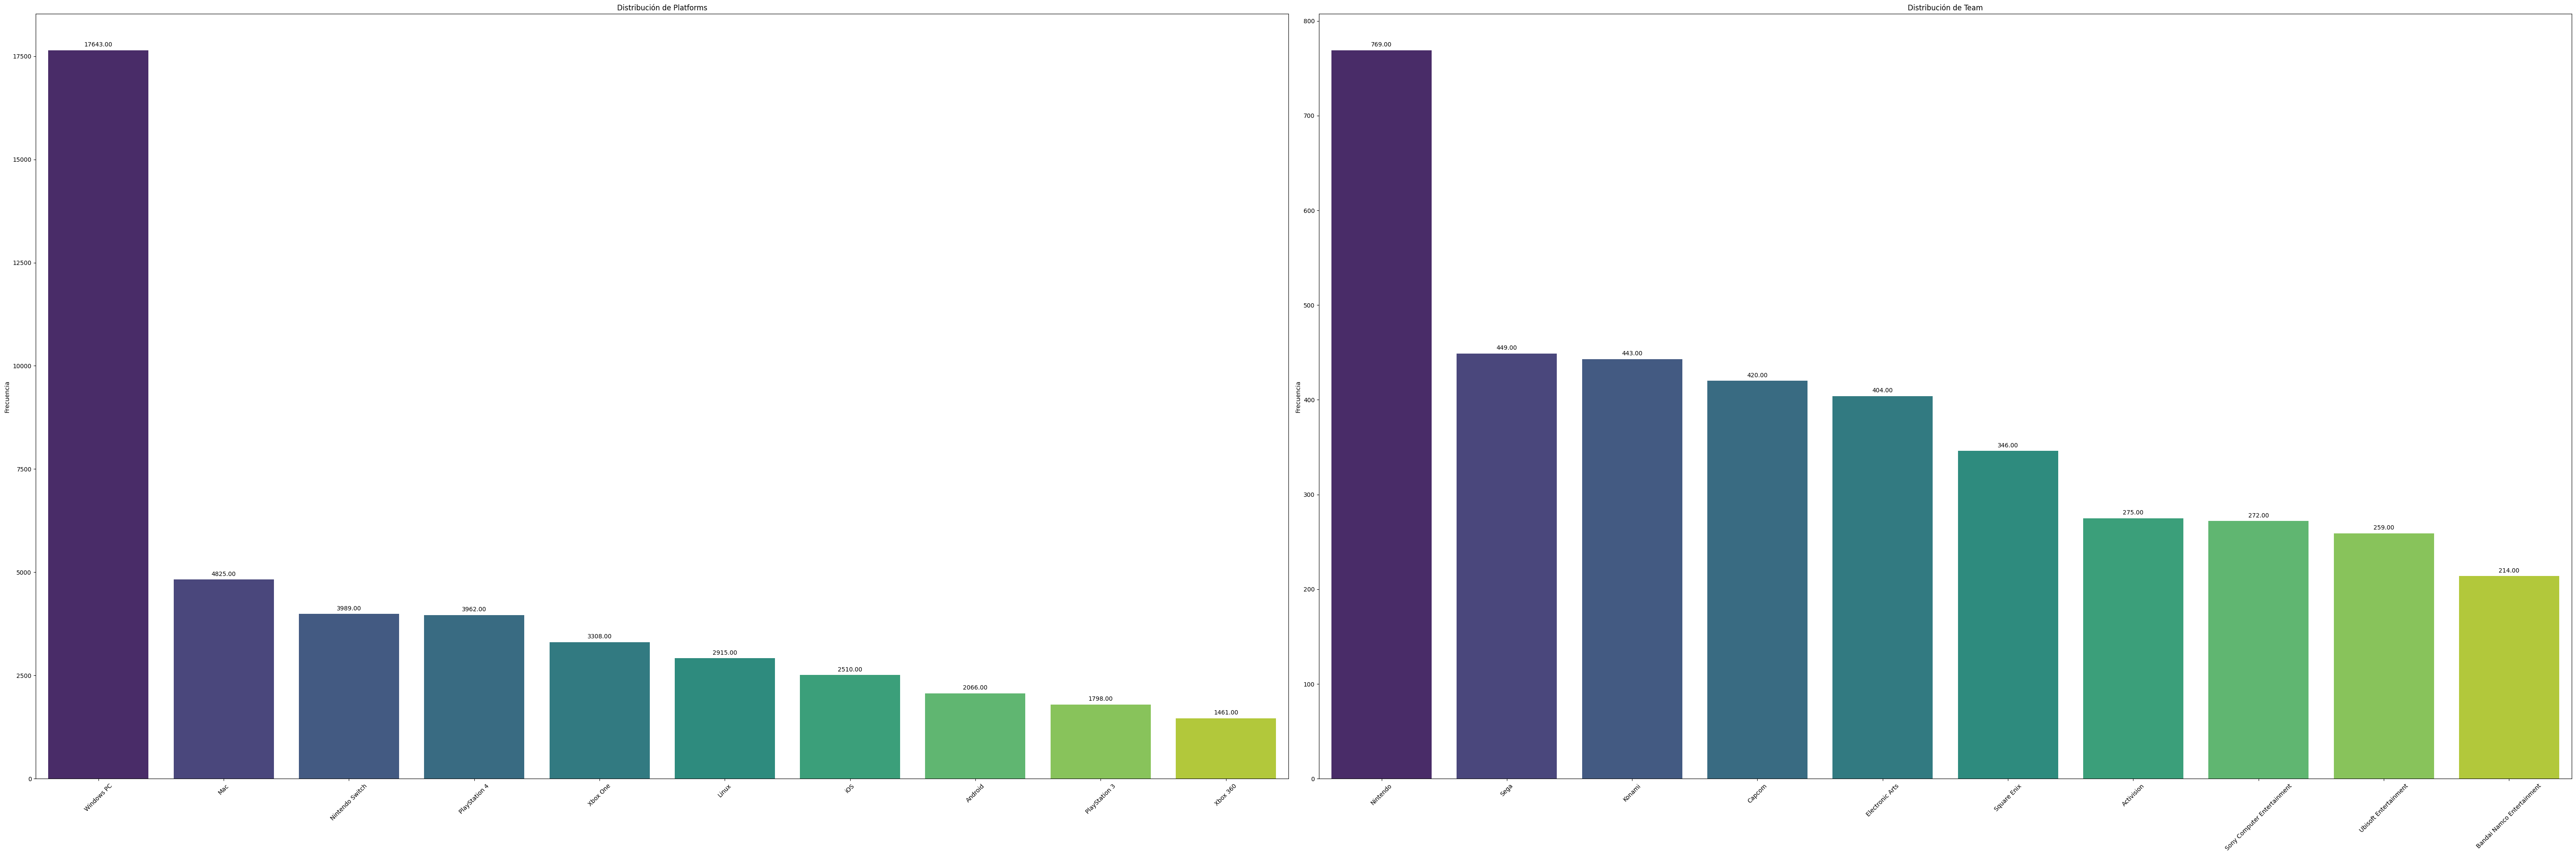

In [149]:
Funciones.pinta_distribucion_categoricas_dfs_mixtos([(df_exploded_platform, 'Platforms'), (df_exploded_team, 'Team')], relativa=False, mostrar_valores=True, top_n=10)

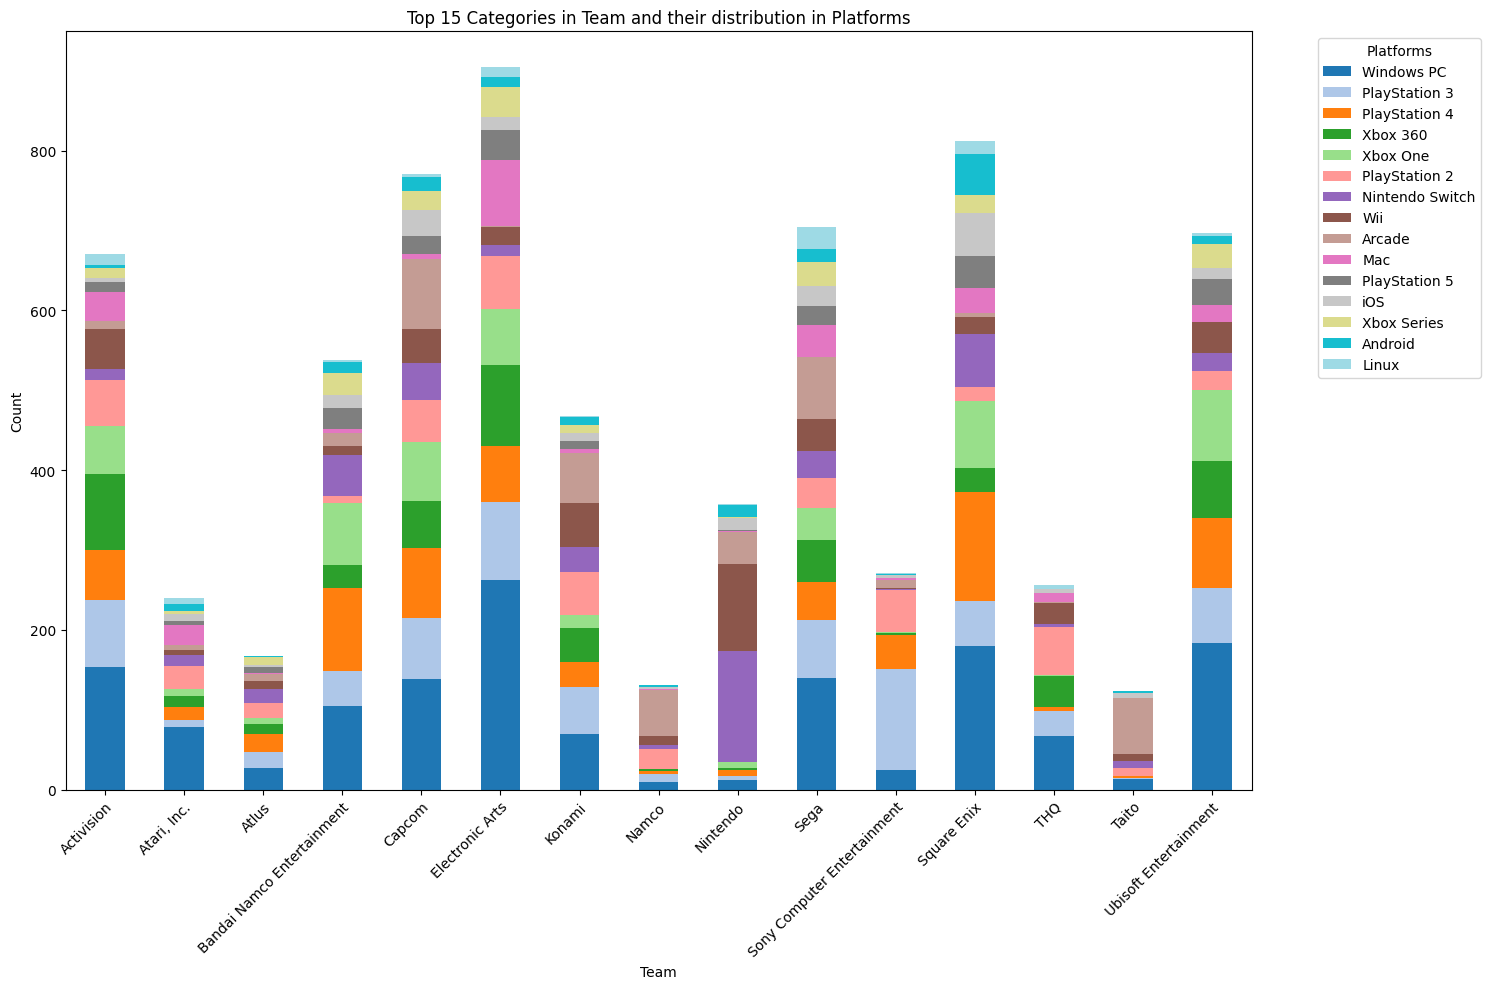

In [191]:
Funciones.plot_interactive_comparison_categorica(df_exploded_team, 'Team', df_exploded_platform, 'Platforms', 'GameID', top_n=15,relative=False)

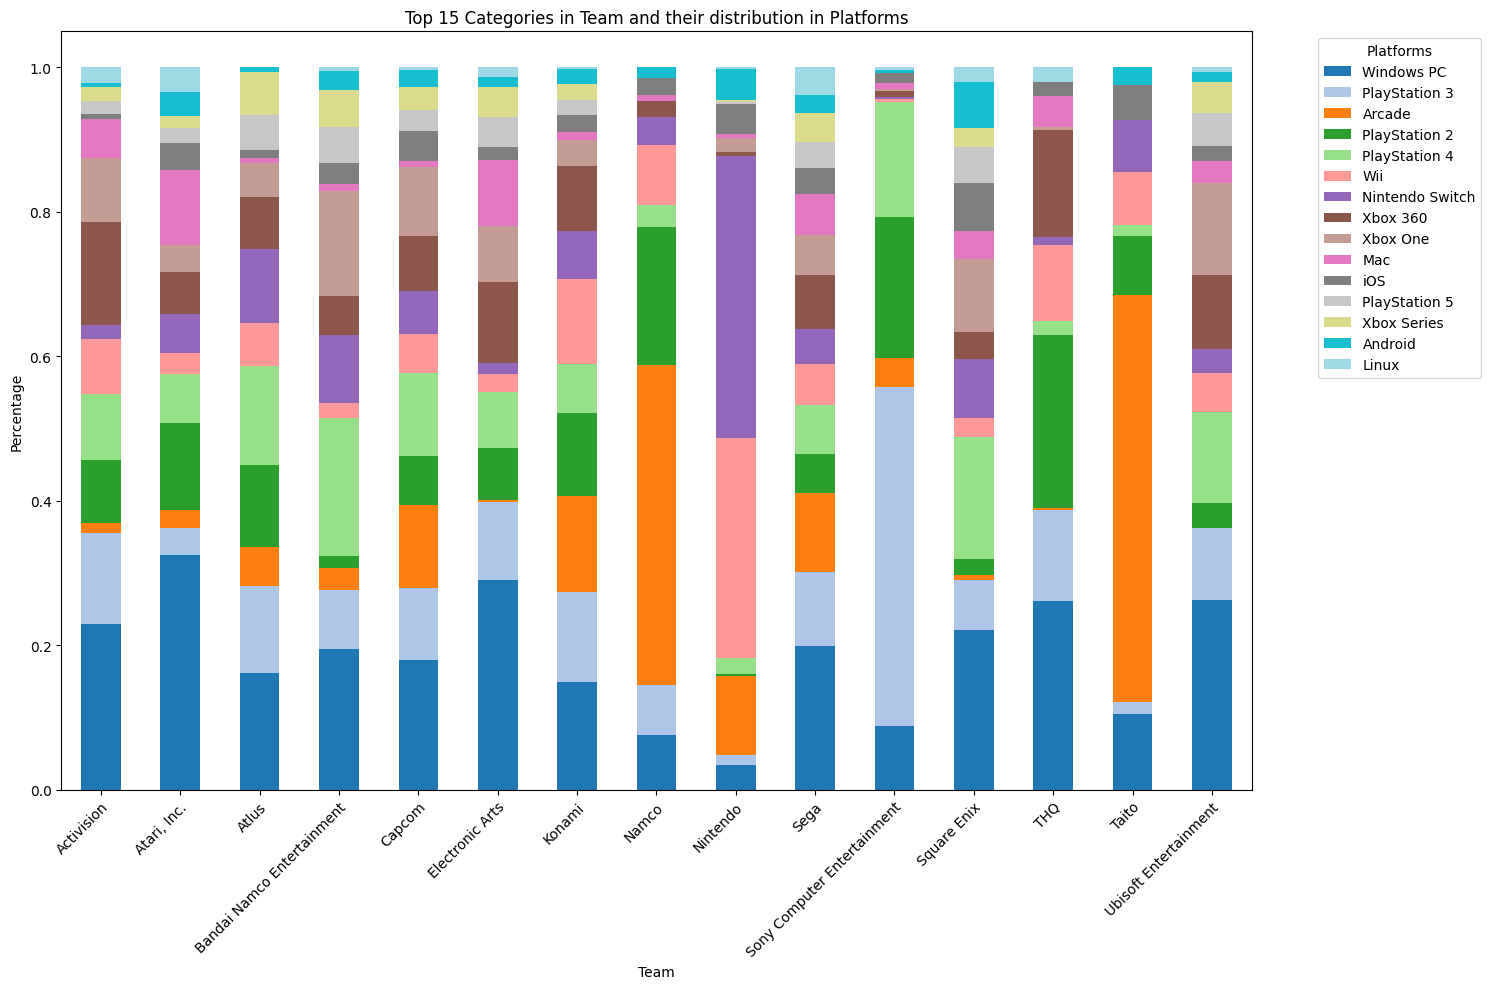

In [169]:
Funciones.plot_interactive_comparison_categorica(df_exploded_team, 'Team', df_exploded_platform, 'Platforms', 'GameID', top_n=15,relative=True)

In [ ]:
'''
Los siguientes gráficos muesrtran los 15 equipos con más juegos y cómo se componen en términos relativos y absolutos si se seleccionan las 15 plataformas más importantes
  - A diferencia de comparativas anteriores, en la gráfica relativa, se puede observar cómo hay compañías que tienen una relevancia notable en ciertas plataformas.
  Aunque se mantiene unos porcentajes relativmanete equitativos en plataformas como 'Windows PC', sí que se puede observar como ciertos equipos han tenido o tienen cierta dominancia
  en plataformas particulares.

  - El caso más llamativo es el de 'Nintendo'. Además de ser una plataforma, también produce juegos. Además de tener el porcentaje mayoritario en la producción de juegos de su plataforma, y su hermana 'Wi' también 
tienen cuotas de mercado interesantes en otras plataformas. Es curioso cómo produce una gran cantidad relativa de videjuegos tanto para Android como para iOS.

- Existen casos similares como el de 'Sony Computer Entertainement', que es compañía hermana de la productora de las consolas PayStation. La diferencia en que en este caso, parece que la dominancia era mucho mayor en las 
primeras consolas, mientras que en las más nueva no tienen tanta cuota. Eso quiere decir que otras compañías han generado más videjuegos

 
  
'''

In [211]:

Funciones.test_chi_cuadrado_dfs_exploded(df_exploded_team, 'Team', df_exploded_platform, 'Platforms', 'GameID')

Valor Chi-Cuadrado: 3144687.6289955038
P-Value: 0.0
Grados de Libertad: 1981888

Tabla de Frecuencias Esperadas:
 [[4.35222562e-05 6.52833843e-05 1.09893697e-03 ... 4.50455352e-03
  2.28491845e-04 3.36535846e-02]
 [4.35222562e-05 6.52833843e-05 1.09893697e-03 ... 4.50455352e-03
  2.28491845e-04 3.36535846e-02]
 [4.35222562e-05 6.52833843e-05 1.09893697e-03 ... 4.50455352e-03
  2.28491845e-04 3.36535846e-02]
 ...
 [4.35222562e-05 6.52833843e-05 1.09893697e-03 ... 4.50455352e-03
  2.28491845e-04 3.36535846e-02]
 [4.35222562e-05 6.52833843e-05 1.09893697e-03 ... 4.50455352e-03
  2.28491845e-04 3.36535846e-02]
 [8.70445124e-05 1.30566769e-04 2.19787394e-03 ... 9.00910703e-03
  4.56983690e-04 6.73071692e-02]]


In [192]:
# Compruebo que los resultados mostrados en las gráficas son correctos, tanto relativos como absolutos
# Define el top_n
top_n = 15

# Obtén los top_n equipos y plataformas más comunes
top_teams = df_exploded_team['Team'].value_counts().nlargest(top_n).index
top_platforms = df_exploded_platform['Platforms'].value_counts().nlargest(top_n).index

# Filtra los DataFrames por los top_n equipos y plataformas
filtered_teams = df_exploded_team[df_exploded_team['Team'].isin(top_teams)]
filtered_platforms = df_exploded_platform[df_exploded_platform['Platforms'].isin(top_platforms)]

# Realiza el merge
merged_df = pd.merge(filtered_teams[['GameID', 'Team']], filtered_platforms[['GameID', 'Platforms']], on='GameID')

# Agrupa por equipo y plataforma y obtén el conteo
team_platform_counts = merged_df.groupby(['Team', 'Platforms']).size().reset_index(name='Counts')

# Calcula las proporciones para cada equipo y convierte a formato de porcentaje
team_platform_counts['Proportion'] = (team_platform_counts.groupby('Team')['Counts']
                                      .transform(lambda x: x / x.sum()) * 100).round(2)

# Ordena los resultados
team_platform_counts.sort_values(by=['Team', 'Proportion'], ascending=[True, False], inplace=True)


#pd.set_option('display.max_rows', None)  # None para mostrar todas las filas

# Muestra los resultados
team_platform_counts.head(15)


,Team,Platforms,Counts,Proportion
10,Activision,Windows PC,154,22.95
11,Activision,Xbox 360,95,14.16
6,Activision,PlayStation 3,84,12.52
7,Activision,PlayStation 4,62,9.24
12,Activision,Xbox One,60,8.94
5,Activision,PlayStation 2,58,8.64
9,Activision,Wii,51,7.60
3,Activision,Mac,36,5.37
2,Activision,Linux,14,2.09
4,Activision,Nintendo Switch,13,1.94


<a id="Conclusiones-Categoricas"></a>
## Conclusiones Categoricas



### **Relación entre 'Genre' y 'Team'**
- Los resultados del test de chi-cuadrado con un **valor chi-cuadrado de 342107.304** y un **p-valor de 0.0** indican una relación estadísticamente significativa entre el género de los videojuegos y las compañías que los producen. Con **246686 grados de libertad**, la diversidad en la combinación de géneros y equipos es notablemente alta.

- Insights:
  - A pesar de la presencia dominante de algunas compañías en ciertos géneros, ninguna compañía parece monopolizar completamente un género específico. Esto sugiere una estrategia de diversificación en la producción de videojuegos por parte de las compañías líderes. El mejor ejemplo es Nintendo, que tiene una presencia relativamente alta en la mayoría de géneros principales. En este sentido,  la diversificación es una herramienta útil para mitigar posibles riesgos en el caso de que un género deje de ser popular en un determinado momento.
  - A pesar de esta distribución equitativa, existen casos como el deCapcom y Square Enix, que muestran una fuerte asociación con géneros específicos como 'Point and click', 'Visual Novel', 'Fighting' y 'RPG', respectivamente. Esto podría reflejar que en ciertos casos, una especialización de mercado puede resultar exitoso en algunos casos.
  - El género 'Indie' se caracteriza por una menor dominancia de grandes compañías, lo que es consistente con un mercado compuesto por muchos desarrolladores independientes y pequeños. Esto subraya la naturaleza accesible y diversa del género indie.

---

### **Relación entre 'Platforms' y 'Genre'**
- El test de chi-cuadrado muestra un **valor chi-cuadrado de 38639.432** y un **p-valor de 0.0**, lo que indica una relación estadísticamente significativa entre las plataformas de videojuegos y los géneros disponibles en ellas, con **3806 grados de libertad**.

- Insights:
  - La similitud en la composición de géneros entre plataformas sugiere que la mayoría de las plataformas buscan ofrecer una amplia gama de géneros. Esto puede ser una estrategia para atraer una base de usuarios diversa y asegurar que las preferencias de casi todos los jugadores estén cubiertas.
  - La disponibilidad universal de géneros en diferentes plataformas significa que los jugadores tienen libertad para elegir plataformas sin comprometer sus preferencias de género. Por ejemplo, los aficionados a los deportes pueden disfrutar de juegos de deportes en casi cualquier plataforma.
  - El género 'Indie', vuelve a ser la nota discordante; se destaca por su amplia disponibilidad en plataformas relacionadas con ordenadores, lo que podría estar relacionado con barreras de entrada más bajas para los desarrolladores en estas plataformas.

---

### **Relación entre 'Platforms' y 'Team'**
- El test de chi-cuadrado revela un **valor chi-cuadrado de 3144687.629** y un **p-valor de 0.0**, lo que implica una relación estadísticamente significativa entre los equipos de desarrollo y las plataformas para las que desarrollan, con **1981888 grados de libertad**.

- Insights:
  - A diferencia de comparativas anteriores, en la gráfica relativa,  aunque se mantiene unos porcentajes relativmanete equitativos en plataformas como 'Windows PC se puede observar cómo hay compañías que tienen una relevancia notable en ciertas plataformas.
  - Un claro ejemplo es Nintendo, y en menor medida, y Sony Computer Entertainment en las consolas PlayStation:
    - Existe una dominancia relativa por parte de Nintendo en plataformas móviles como Android e iOS, un claro indicador de su estrategia de diversificación y de llegar a una audiencia más amplia más allá de sus propias consolas.
    - Aunque Sony Computer Entertainment también es otro ejemplo, esta ha sufrido un cambio en la cuota de mercado a lo largo de las generaciones de consolas PlayStation sugiriendo un mayor número de desarrolladores para sus consolas y un mercado de videojuegos en constante evolución, donde nuevas compañías están emergiendo y compitiendo con éxito.



<a id="Relacion-Combinadas"></a>
## Relacion Combinadas

### **Relación entre 'Genre' y 'Avg. Rating''**

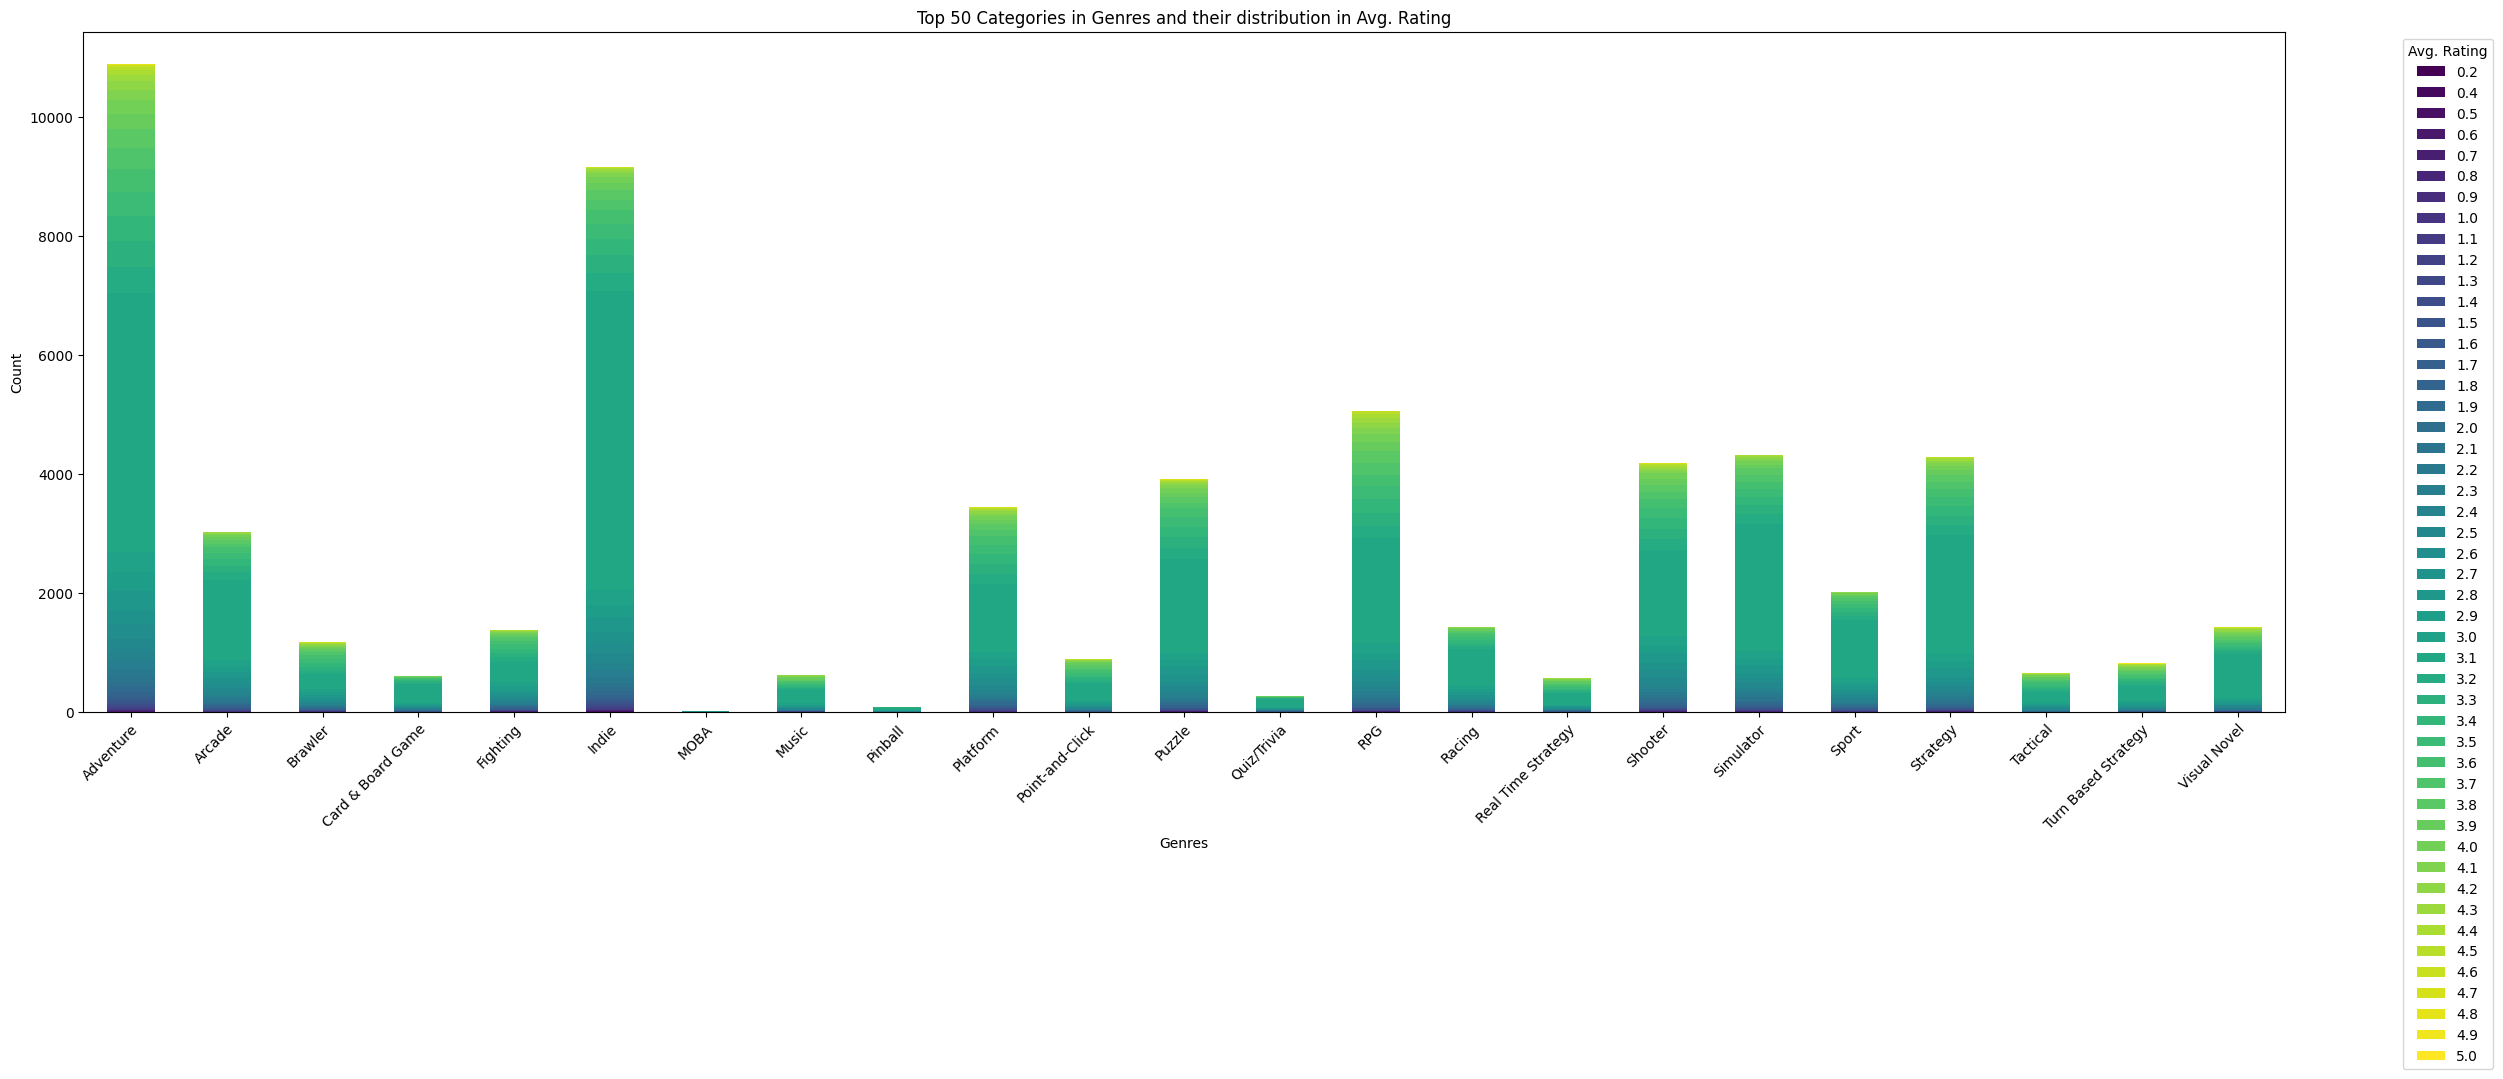

In [261]:
Funciones.plot_interactive_comparison_continua(df_exploded_genres, 'Genres', df, 'Avg. Rating', 'GameID', top_n=50,relative=False)

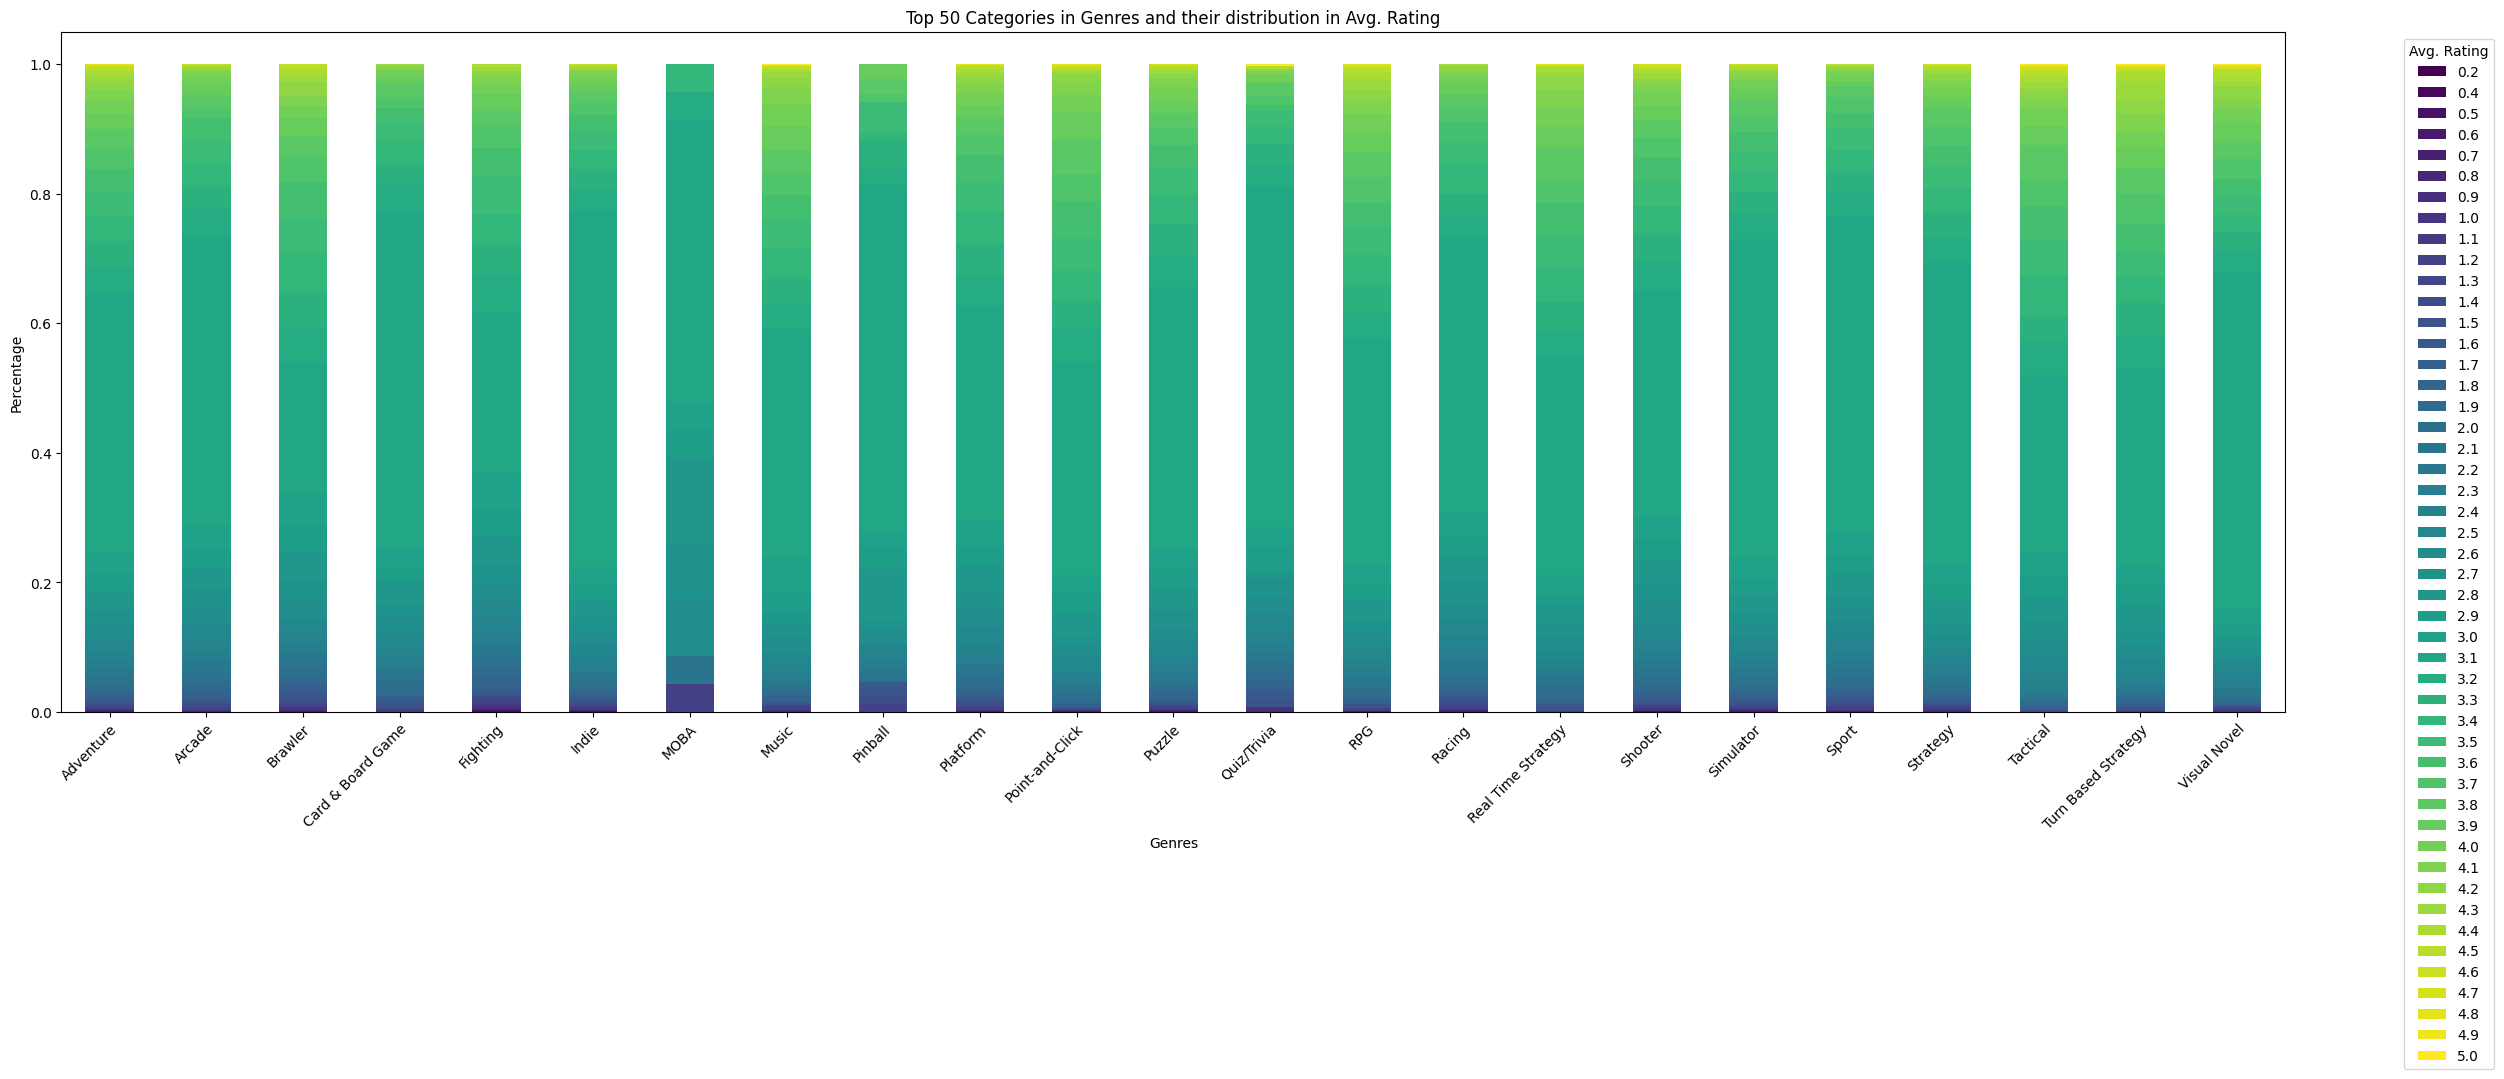

In [86]:
# Esta versión de la función está modificada para tener un diseño óptimo para variables numéricas discretas (avg. rating) y además los ajustes de leyenda no interfieren en este caso
Funciones.plot_interactive_comparison_continua(df_exploded_genres, 'Genres', df, 'Avg. Rating', 'GameID', top_n=50,relative=True)




In [ ]:
# EN ESTE CASO, EL TOP_N ES DE 50 PORQUE QUIERO QUE SE MUENTREN TODOS LOS GÉNEROS Y TODAS LAS VARIABLES DE NOTAS

'''
Los siguientes gráficos muesrtran todos lo géneros y su nota media en cada uno de ellos.
  - En términos generales, no existe ningún género que destaque en gran medida por tener una nota media muy alta o muy baja respecto a los demás. Se puede observar cómo el análisis univariante de 'Avg. Rating' que vimos en su momento,
  nos indica que existe una variabilidad y dipersión muy moderada de sus valores en comparación con otras variables.

  - En este sentido, existen muy pocos Géneros que se diferencien por su nota media, aunque de forma muy humilde, se puede observar que RPG, Turn Based Strategy y Adventure, tieden a tener un rango de notas medias más altas.

  - En contraste, géneros como MOBA, Quiz/Trivia y Racing parecen agrupar el mayor número de notas medias más bajas.
  
'''

### **Relación entre 'Team' y 'Avg. Rating''**

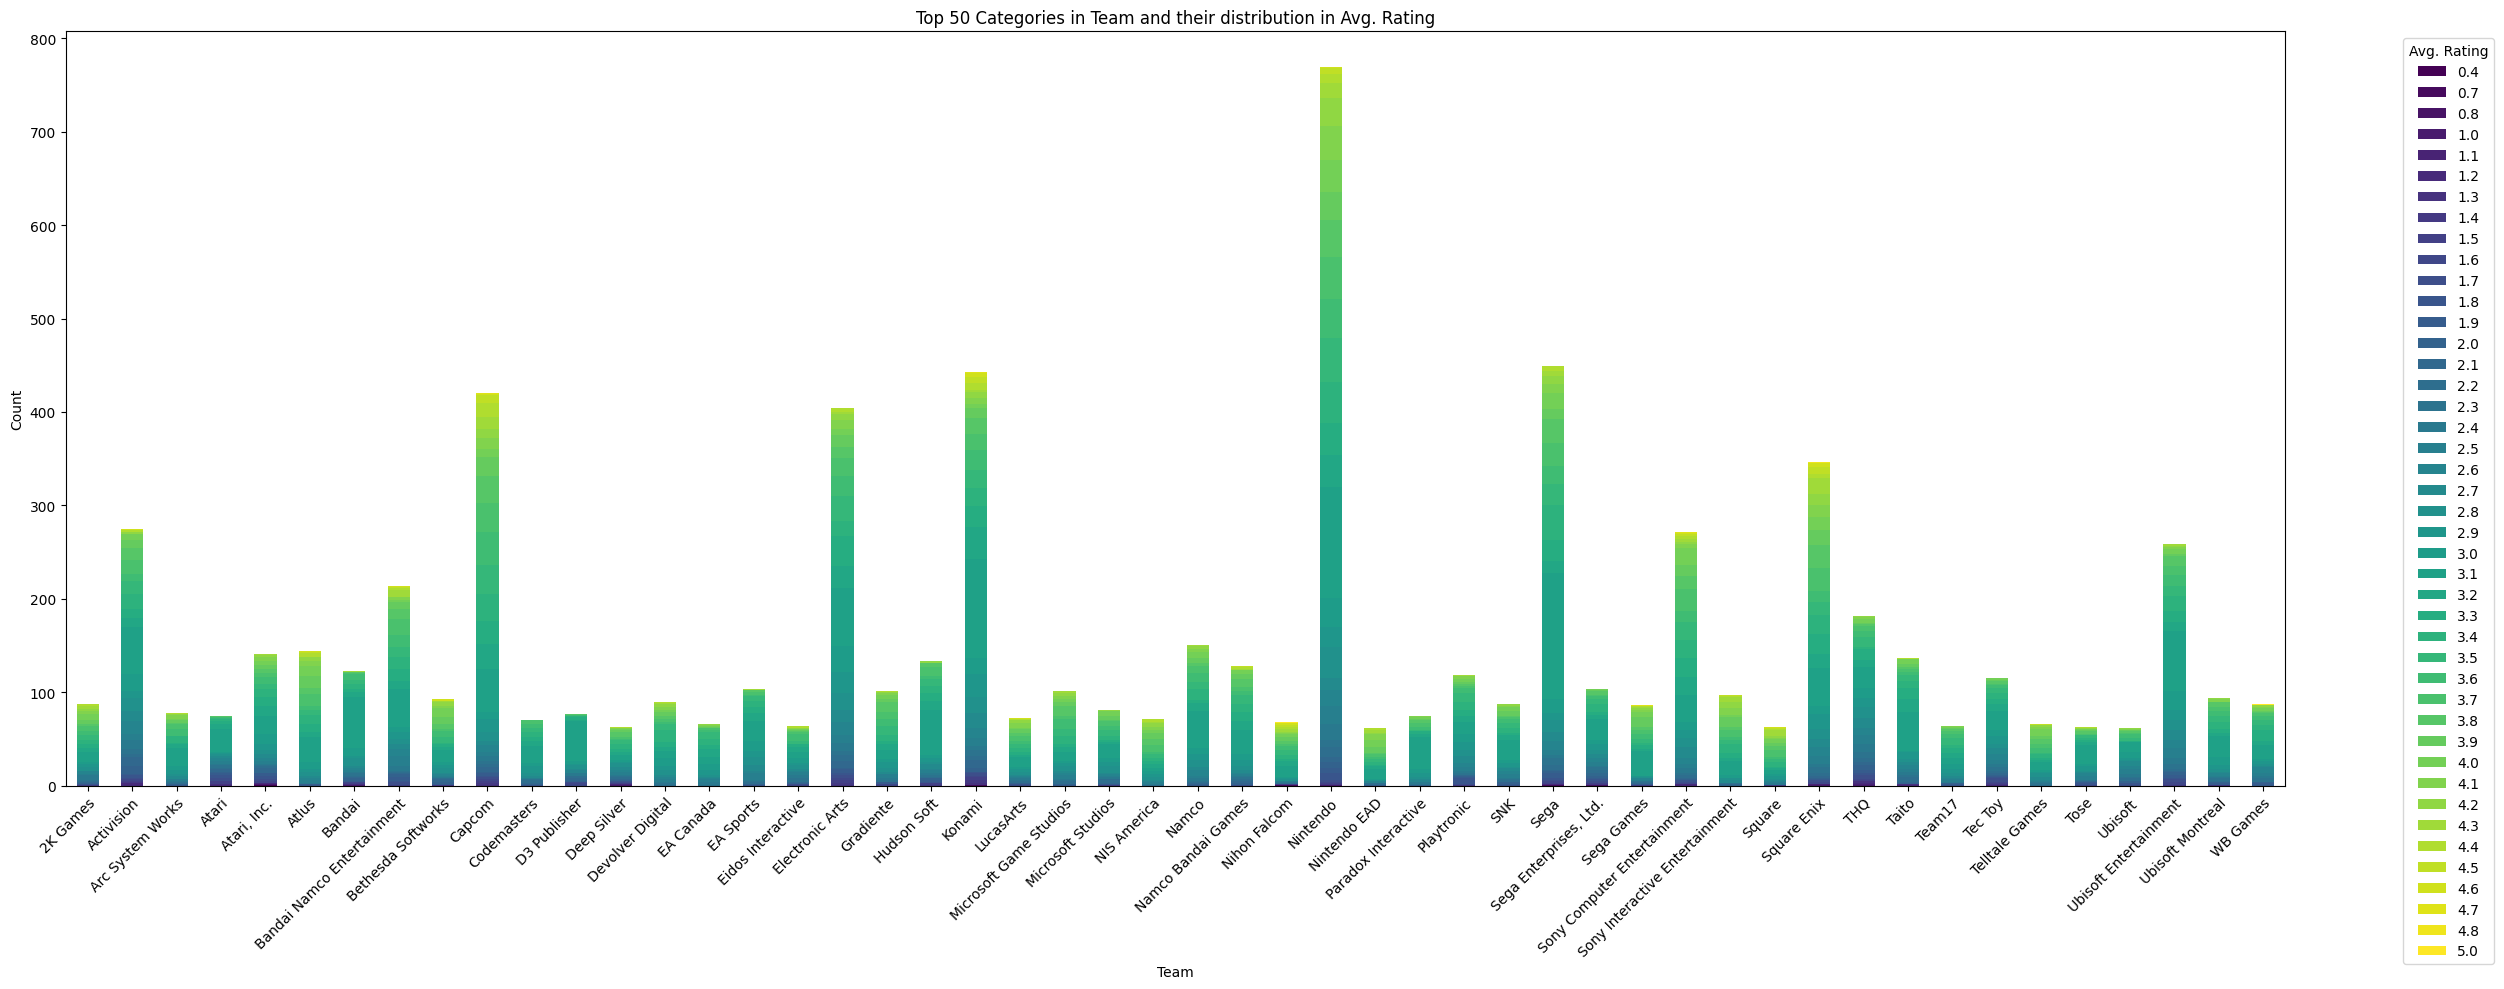

In [220]:
Funciones.plot_interactive_comparison_continua(df_exploded_team,'Team', df, 'Avg. Rating', 'GameID', top_n=50,relative=False)

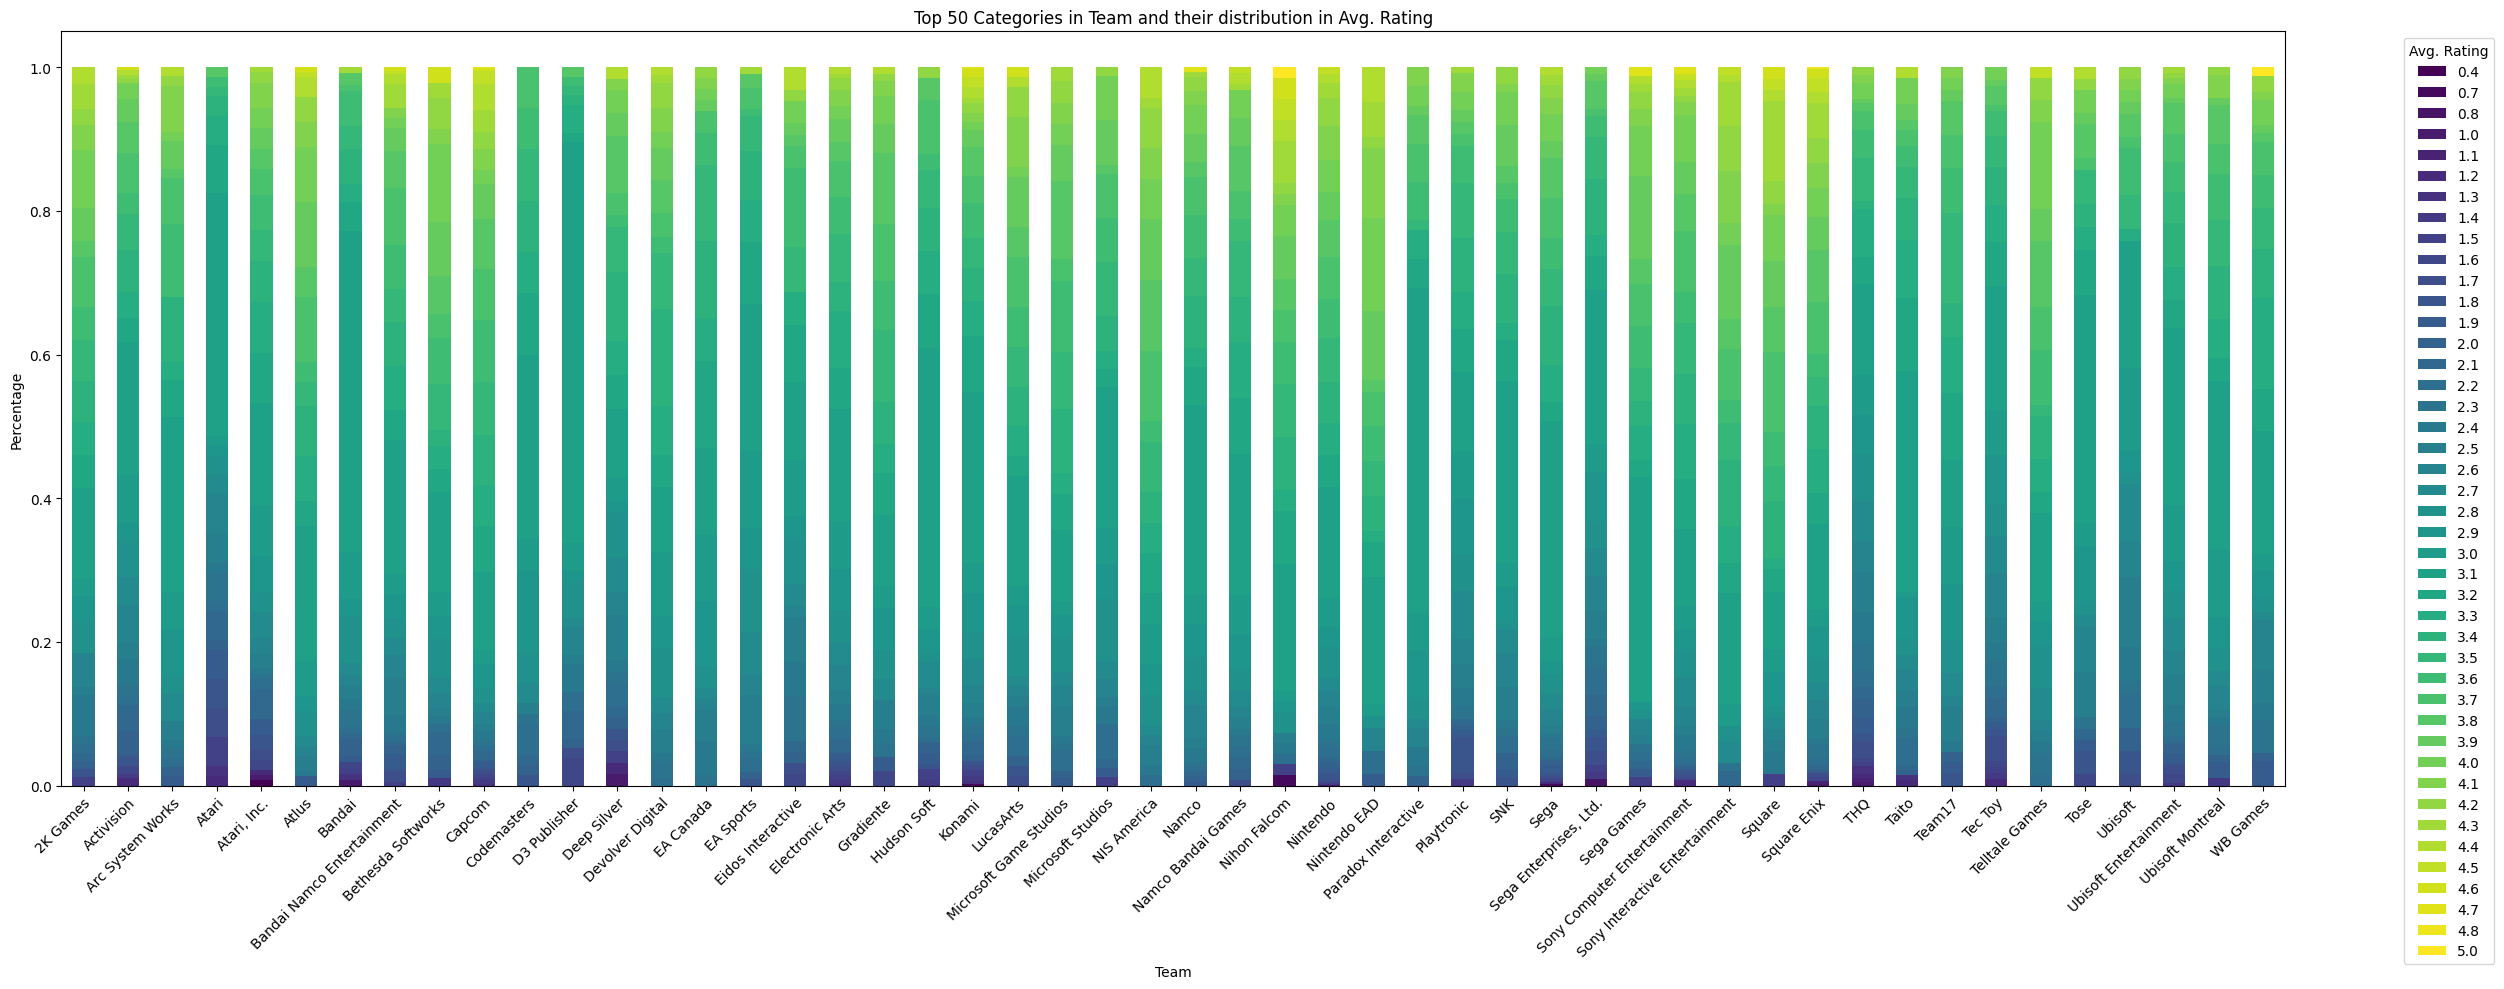

In [223]:
Funciones.plot_interactive_comparison_continua(df_exploded_team,'Team', df, 'Avg. Rating', 'GameID', top_n=50,relative=True)

In [ ]:
'''
Los siguientes gráficos muestran los principales equipos y su nota media en cada uno de ellos. (*Modificar el top_n en caso de querer ver la distribución para mas equipos/más notas medias. Ejemplo: poner a 10 si se quiere ver más claramente los 10 equipos principales)
  - En términos generales, se mantiene una distribución moderada sin un gran número de valores en los extremos, como ya se ha explicado varias veces debido a la propia naturaleza de la variable 'Avg. Rating'

  - En este sentido, aunque sí se pueden observar pequeñas varianzas en las notas medias, resulta curioso que incluso, se incluyen muchos más equipos en la comparativa, la estrctura se matiene parecida.

  - Cabe a destacar, que aunque sin grandes diferencias, los equipos que tienen mejores valoraciones medias, son aquellos con más peso en el mercado (con más número de juegos) como es el caso de 'Nintendo', 'Capcom',
  'Sony' y 'Square Enix'.

  - En el lado contrario, aunque sin una diferencia muy notable, de los equipos más grandes, 'Activision', 'Electronic Arts' y 'THQ' tienen las notas medias más bajas.
  
'''

### **Relación entre 'Platforms' y 'Avg. Rating'**

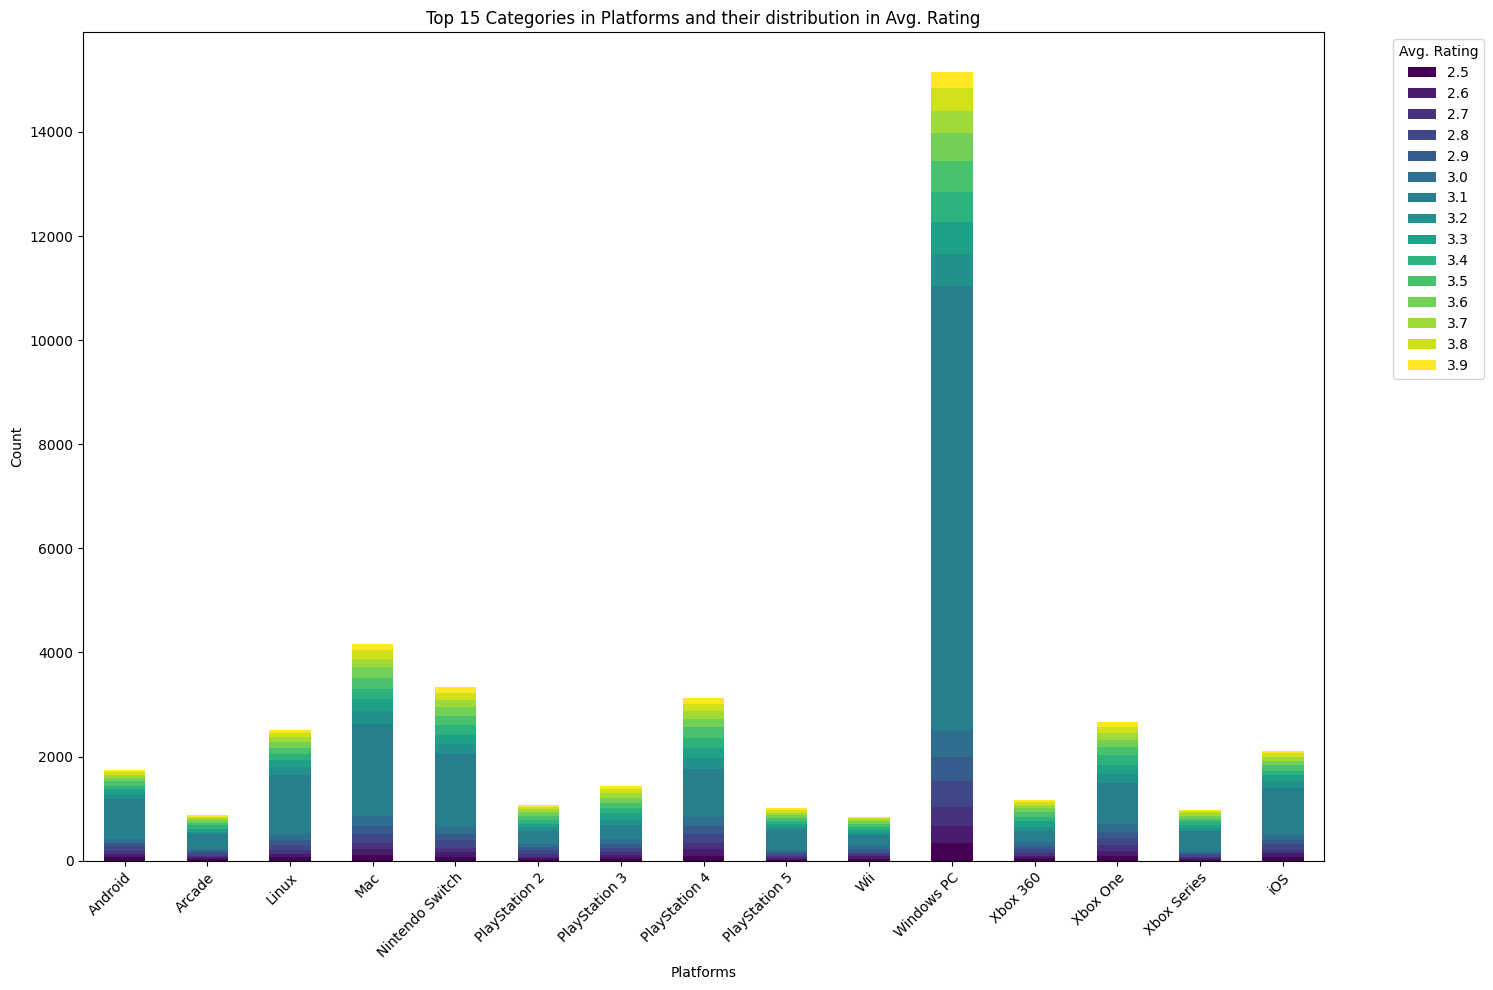

In [226]:
Funciones.plot_interactive_comparison_continua(df_exploded_platform,'Platforms', df, 'Avg. Rating', 'GameID', top_n=15,relative=False)

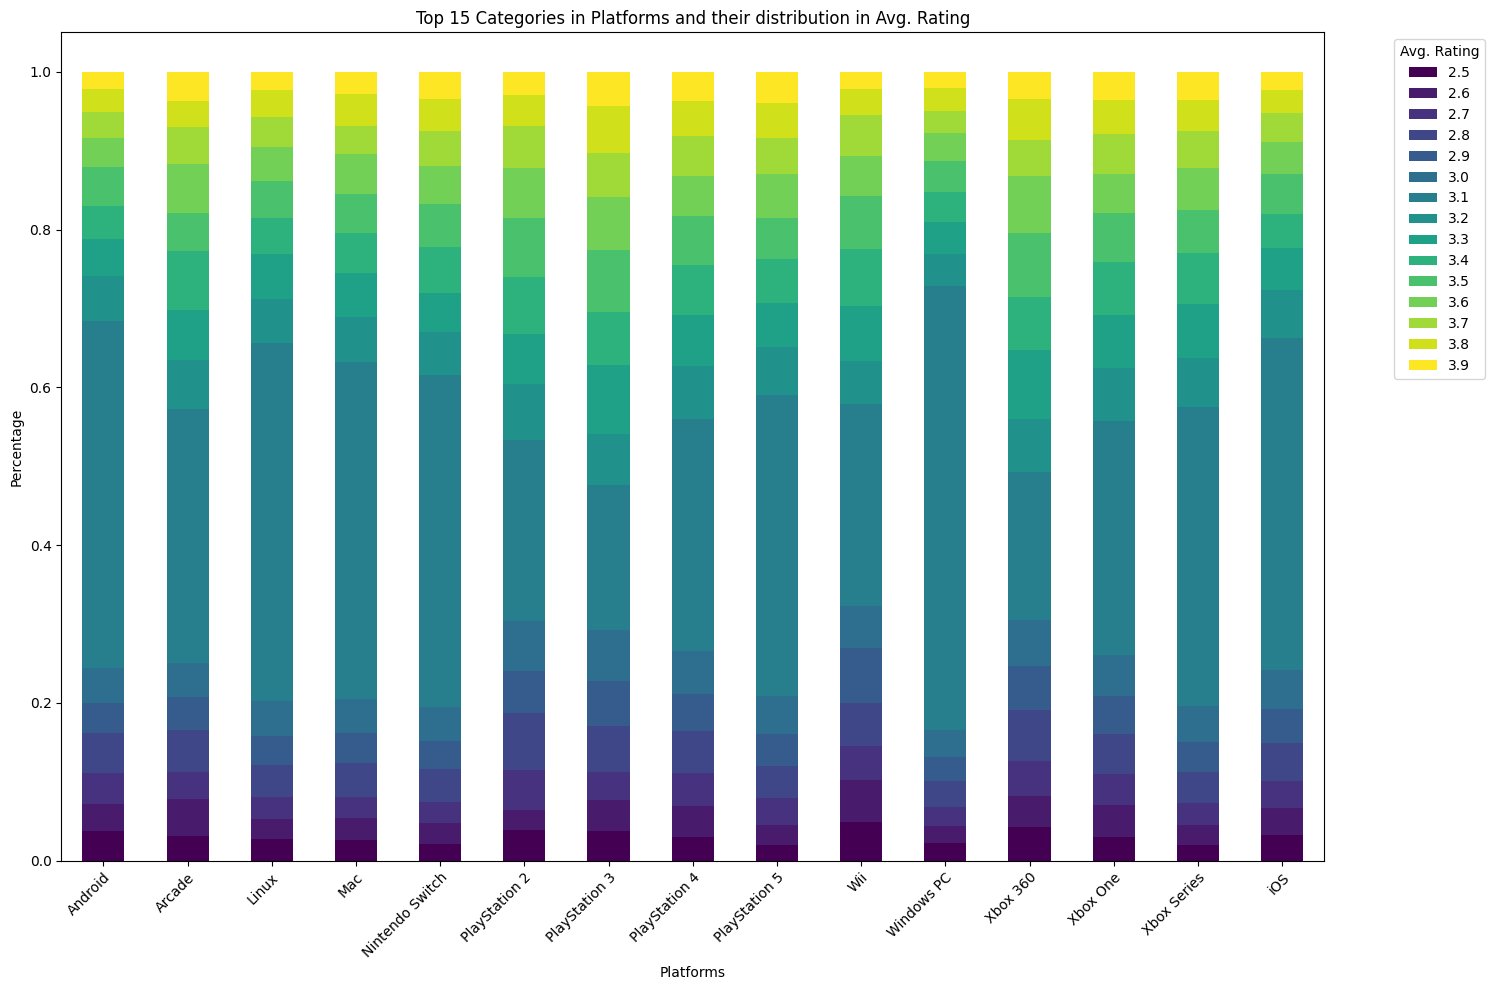

In [225]:
Funciones.plot_interactive_comparison_continua(df_exploded_platform,'Platforms', df, 'Avg. Rating', 'GameID', top_n=15,relative=True)

In [ ]:
'''
Los siguientes gráficos muestran los principales plataformas y su nota media en cada uno de ellas. (*Modificar el top_n en caso de querer ver la distribución para mas equipos/más notas medias.)

  - En términos generales, se mantiene una distribución moderada sin un gran número de valores en los extremos, como ya se ha explicado varias veces debido a la propia naturaleza de la variable 'Avg. Rating'

  - En este sentido, aunque sí se pueden observar pequeñas varianzas en las notas medias, resulta curioso que incluso, se incluyen muchos más equipos en la comparativa, la estrctura se matiene parecida.

  - Cabe a destacar el caso de 'Windows PC', como se puede observar en la primera gráfica, ofrece una gran cantidad de juegos en comparación al resto de plataformas. La mayoría de sus juegos tienen una nota media y
  de la otra mitad, tiene un espectro de notas muy elevadas en comparación con el espectro de notas muy bajas que es más pequeño. Dicho en otras palabras, ofrece una gran cantidad de juegos donde dos tercios de los mismos tienden a tener notas medias
  o muy altas.

  - Otro dato curiosos es el caso de las consolas 'PlayStation' y las primeras generaciones tenían un espectro de valoraciones medias más elevadas que las nuevas. La generación mejor valorada fue la 3, por lo que sería ineresante entender por qué,
  si se trabajara en Sony. (también hay que tener en cuenta que la 5 lleva muchos menos años pero igualmente sería interesante ver qué podría causar ese bajón)

  - En cuanto valoraciones medias bajas, resulta interesante como, a priori no existen plataformas que en términos relativos tengan un segmento muy notable de valoraciones muy bajas respecto a las demás pltaformas.
  
'''

### **Relación entre 'Genre' y 'Plays'**

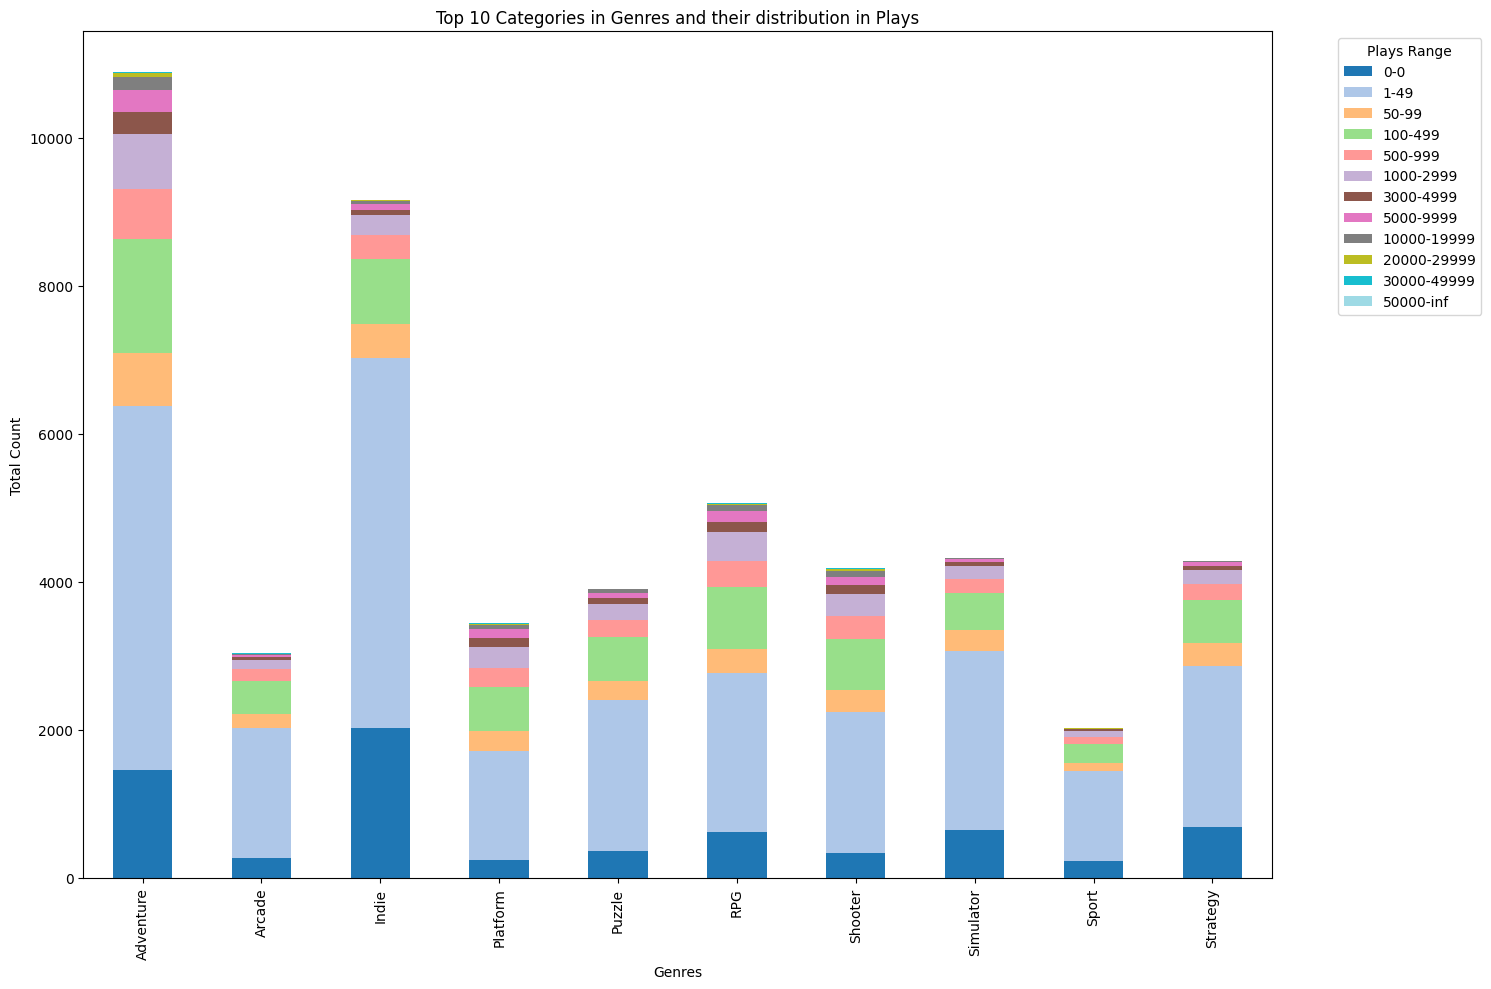

In [10]:
Funciones.plot_interactive_comparison_discreta_dos(df_exploded_genres, 'Genres', df, 'Plays', 'GameID', top_n=10, bins_range=[0, 1, 50, 100, 500, 1000, 3000, 5000, 10000, 20000, 30000, 50000, np.inf], relative=False)

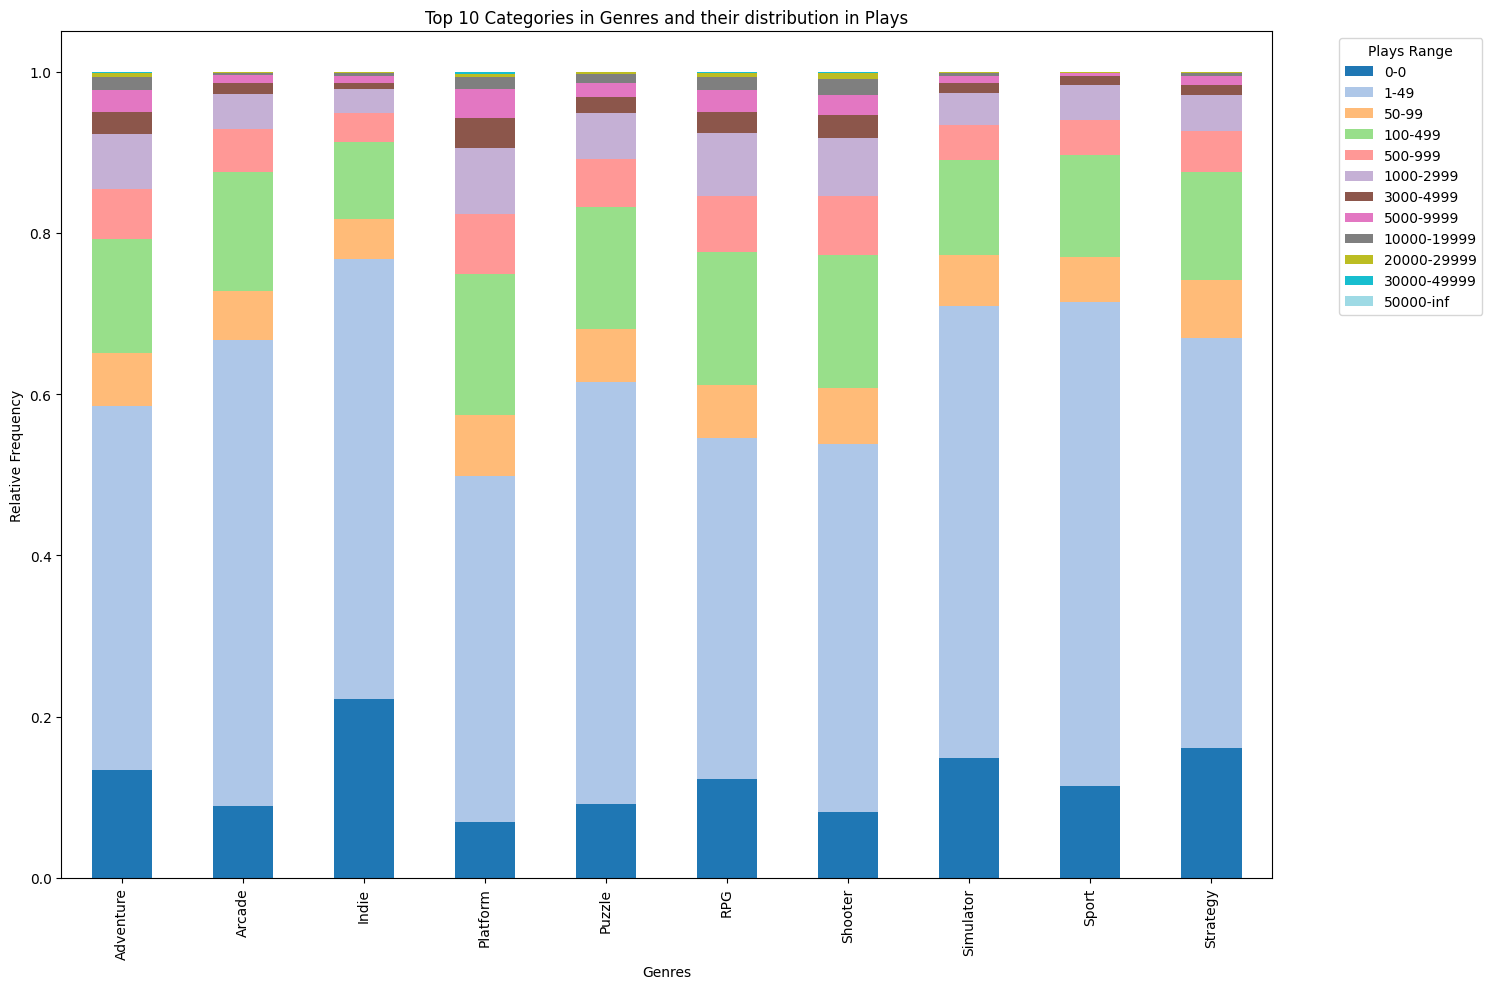

In [9]:
Funciones.plot_interactive_comparison_discreta_dos(df_exploded_genres, 'Genres', df, 'Plays', 'GameID', top_n=10, bins_range=[0, 1, 50, 100, 500, 1000, 3000, 5000, 10000, 20000, 30000, 50000, np.inf], relative=True)

In [ ]:
'''
Los siguientes gráficos muestran los principales géneros y su número total de veces jugadas.

  - En términos generales, se mantiene una distribución similar en la mayoría de los géneros, sobretodo en los valores extremos. Esto vuelve a validar la idea de que esta muestra de datos nos indica que hay
  muchos juegos que apenas han sido jugados y unos pocos son muy populares, y esta condición es aplicable a todos los géneros

  - En este sentido, sí existen variaciones en algunos géneros, sobretodo en aquellos que sus reproducciones e encuentran en un espectro medio

  - Aun así, cabe a destacar ciertos casos donde parece que los juegos con más reproducciones se encuentran en los géneros 'Adventure', 'Shooter', 'Brawler' y 'RPG'.

  - En el caso opuesto, sí que existen géneros en los que las visualizaciones extremadamente bajas son más notorias. En este sentido, el que más destaca es el género 'Indie'. Es importante recordar que este género es el segundo
  en cuanto a número total de juegos, ocupando una cuota del 15% de juegos totales. Por sus propias características, tiene mucho sentido que este sea el que más juegos con pocas visualizaciones debido a que la mayoría de empresas
  pequeñas realizan este tipo de videjuegos. El resto de géneros también tienen un gran número de juegos no populares pero su reparto es bastante similar

  
'''

In [234]:
#top_plays = df.sort_values('Plays', ascending=False).head(15)
#top_plays

### **Relación entre 'Team' y 'Plays'**

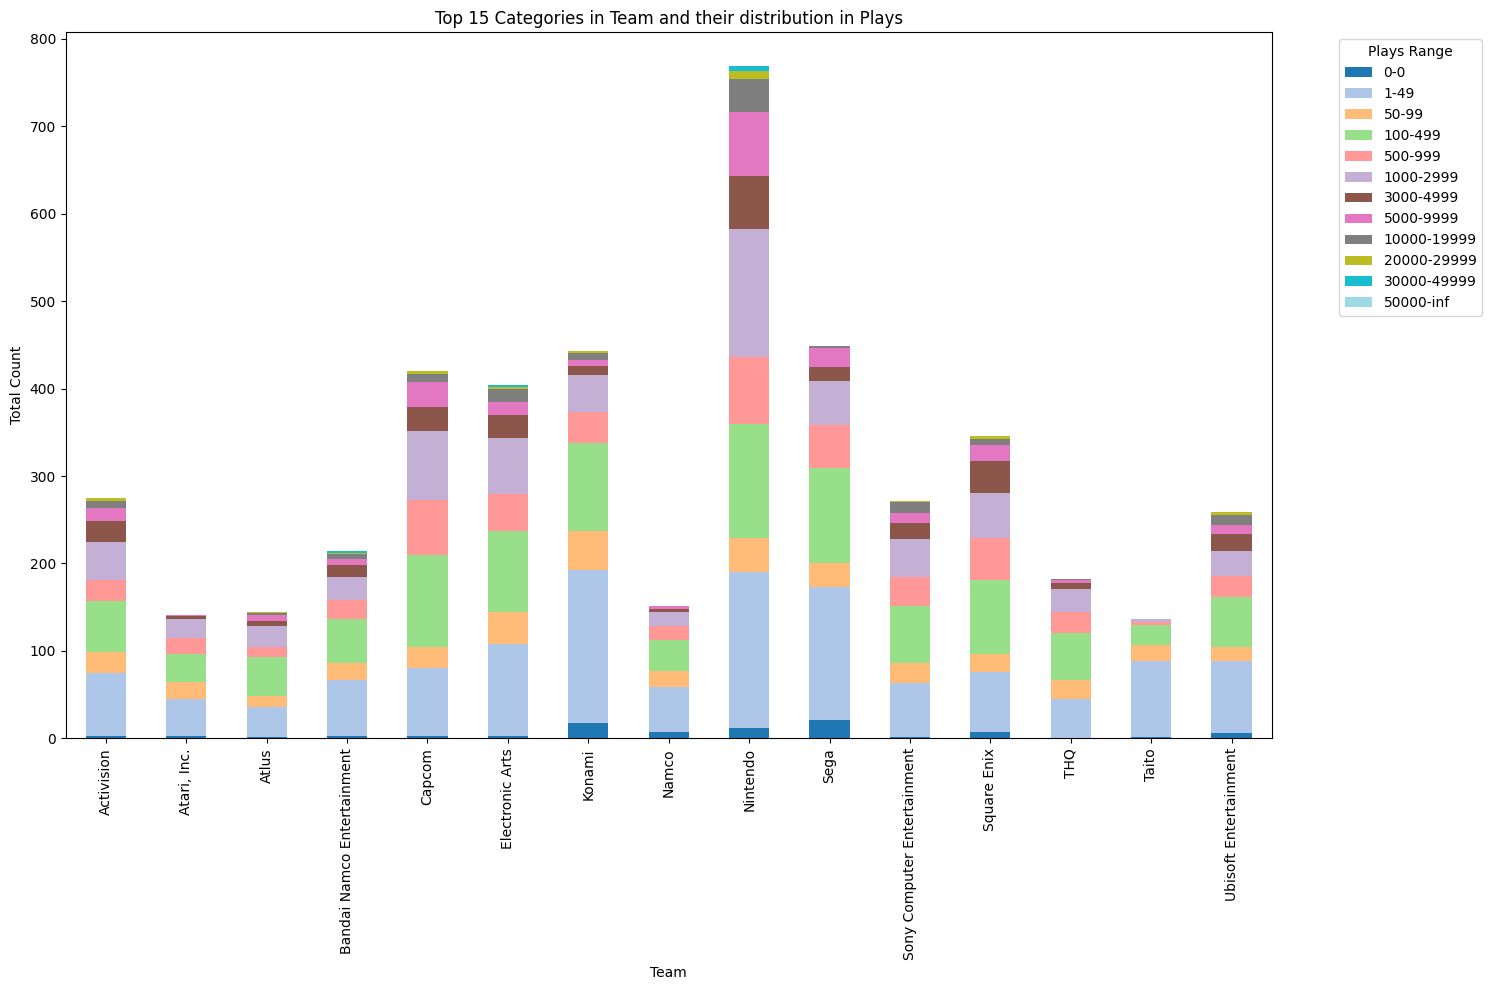

In [263]:
Funciones.plot_interactive_comparison_discreta_dos(df_exploded_team, 'Team', df, 'Plays', 'GameID', top_n=15, bins_range=[0, 1, 50, 100, 500, 1000, 3000, 5000, 10000, 20000, 30000, 50000, np.inf], relative=False)

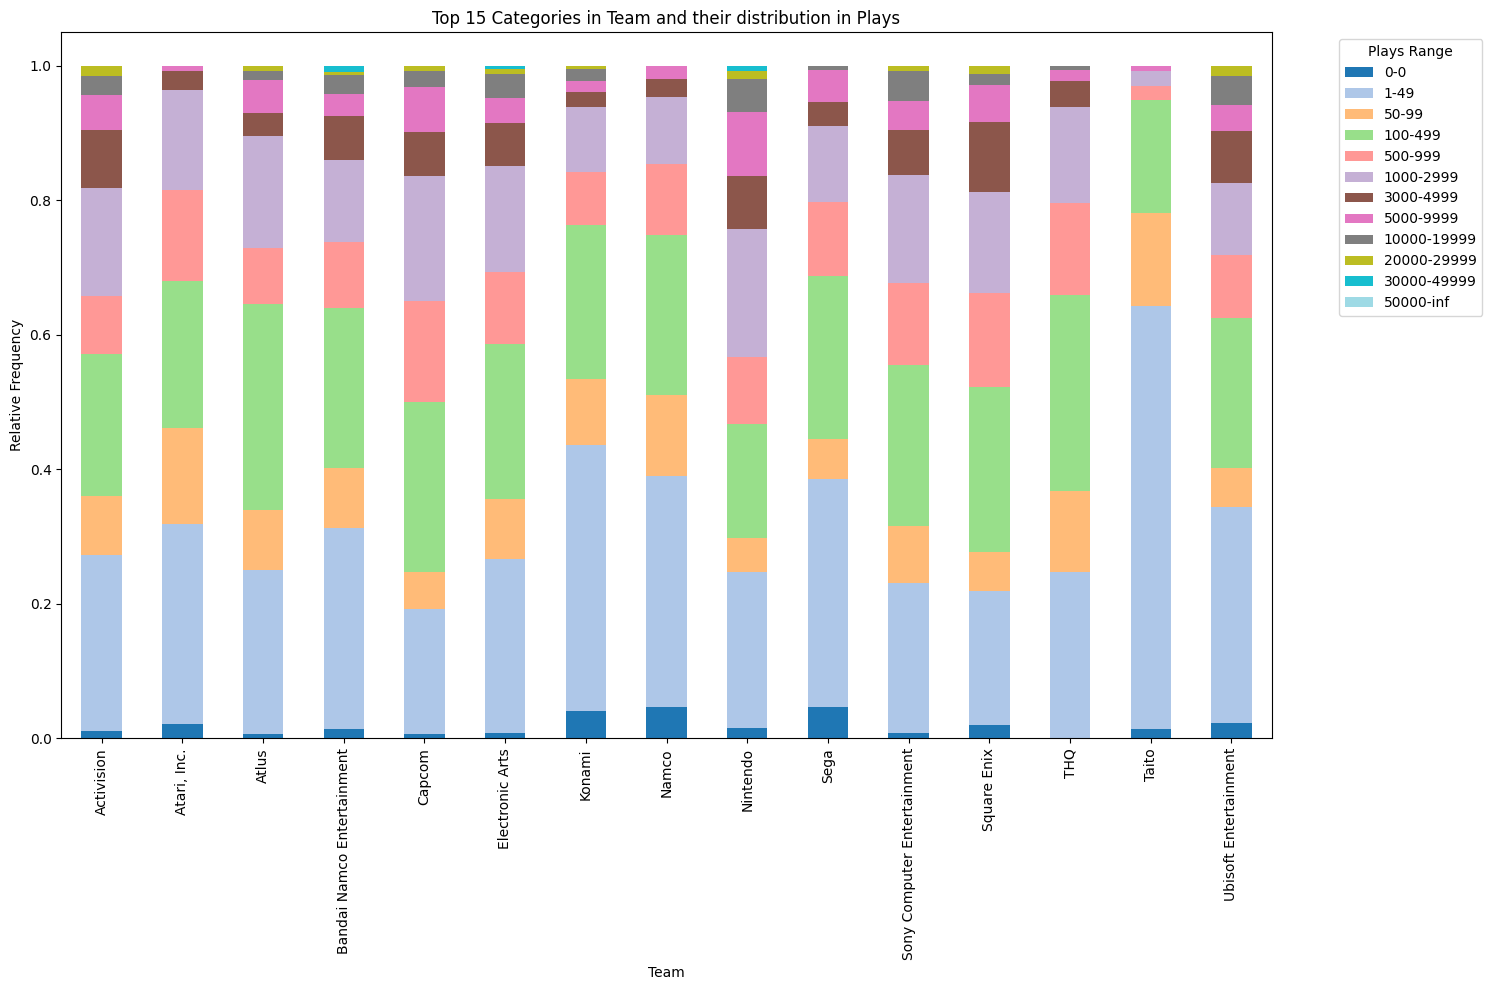

In [239]:
Funciones.plot_interactive_comparison_discreta_dos(df_exploded_team, 'Team', df, 'Plays', 'GameID', top_n=15, bins_range=[0, 1, 50, 100, 500, 1000, 3000, 5000, 10000, 20000, 30000, 50000, np.inf], relative=True)

In [ ]:
'''
Los siguientes gráficos muestran los principales equipos y su número total de veces jugadas. (*Modificar el top_n en caso de querer ver la distribución para mas equipos)

  - En términos generales, parecen tener una distribución similar en los esprectros bajos y medios, es decir juegos que no llegan a tener muchas visualizaciones. Cabe a destacar que estos segmentos en las partes bajas de la barra
  son mucho más pequeños comparados con el resto de equipos. Si por ejemplo, en vez de los 15 equipos principales, ponemos el top_n en 50, se puede observar que esotos segmentos crecen significativamente, lo que se puede traducir que
  las compañías con más juegos, que por ende son las más grandes, aunque ofrecan más juegos , estos suelen ser más jugados que los equipos medianos o pequeños que suelen tender a tener menos juegos y con menos visualizaciones.
 Dicho esto, es importante remarcar que existen excepciones, y en algunos casos, compañías que tienen poco recorrido son capaces de crear un juego exitosos.

  - De nuevo, el caso a destacar es 'Nintendo', debido a que tiene pocos juegos con pocas visualizaciones (comparado con el resto de empresas existosas) y además es el que ofrece el mayor número de juegos más populares del mercado.

  - Aun así, cabe a destacar ciertos casos donde parece que los juegos con más reproducciones se encuentran en los géneros 'Adventure', 'Shooter', 'Brawler' y 'RPG'.

  - En el caso opuesto, sí que existen géneros en los que las visualizaciones extremadamente bajas son más notorias. En este sentido, el que más destaca es el género 'Indie'. Es importante recordar que este género es el segundo
  en cuanto a número total de juegos, ocupando una cuota del 15% de juegos totales. Por sus propias características, tiene mucho sentido que este sea el que más juegos con pocas visualizaciones debido a que la mayoría de empresas
  pequeñas realizan este tipo de videjuegos. El resto de géneros también tienen un gran número de juegos no populares pero su reparto es bastante similar

  
'''

### **Relación entre 'Platform' y 'Plays'**

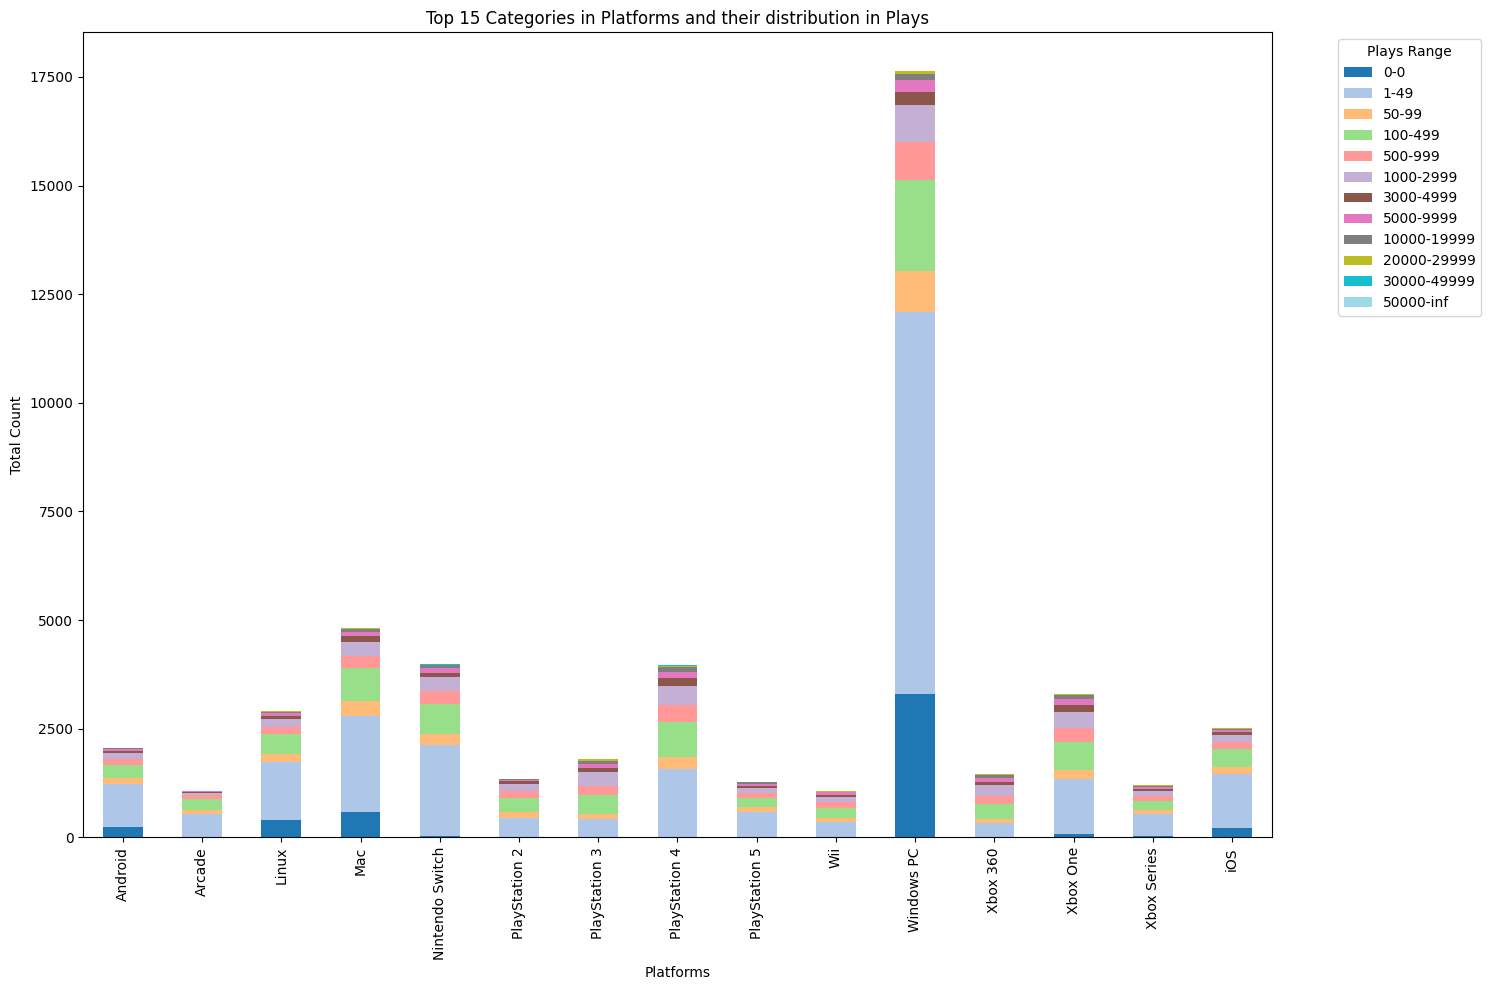

In [243]:
Funciones.plot_interactive_comparison_discreta_dos(df_exploded_platform, 'Platforms', df, 'Plays', 'GameID', top_n=15, bins_range=[0, 1, 50, 100, 500, 1000, 3000, 5000, 10000, 20000, 30000, 50000, np.inf], relative=False)

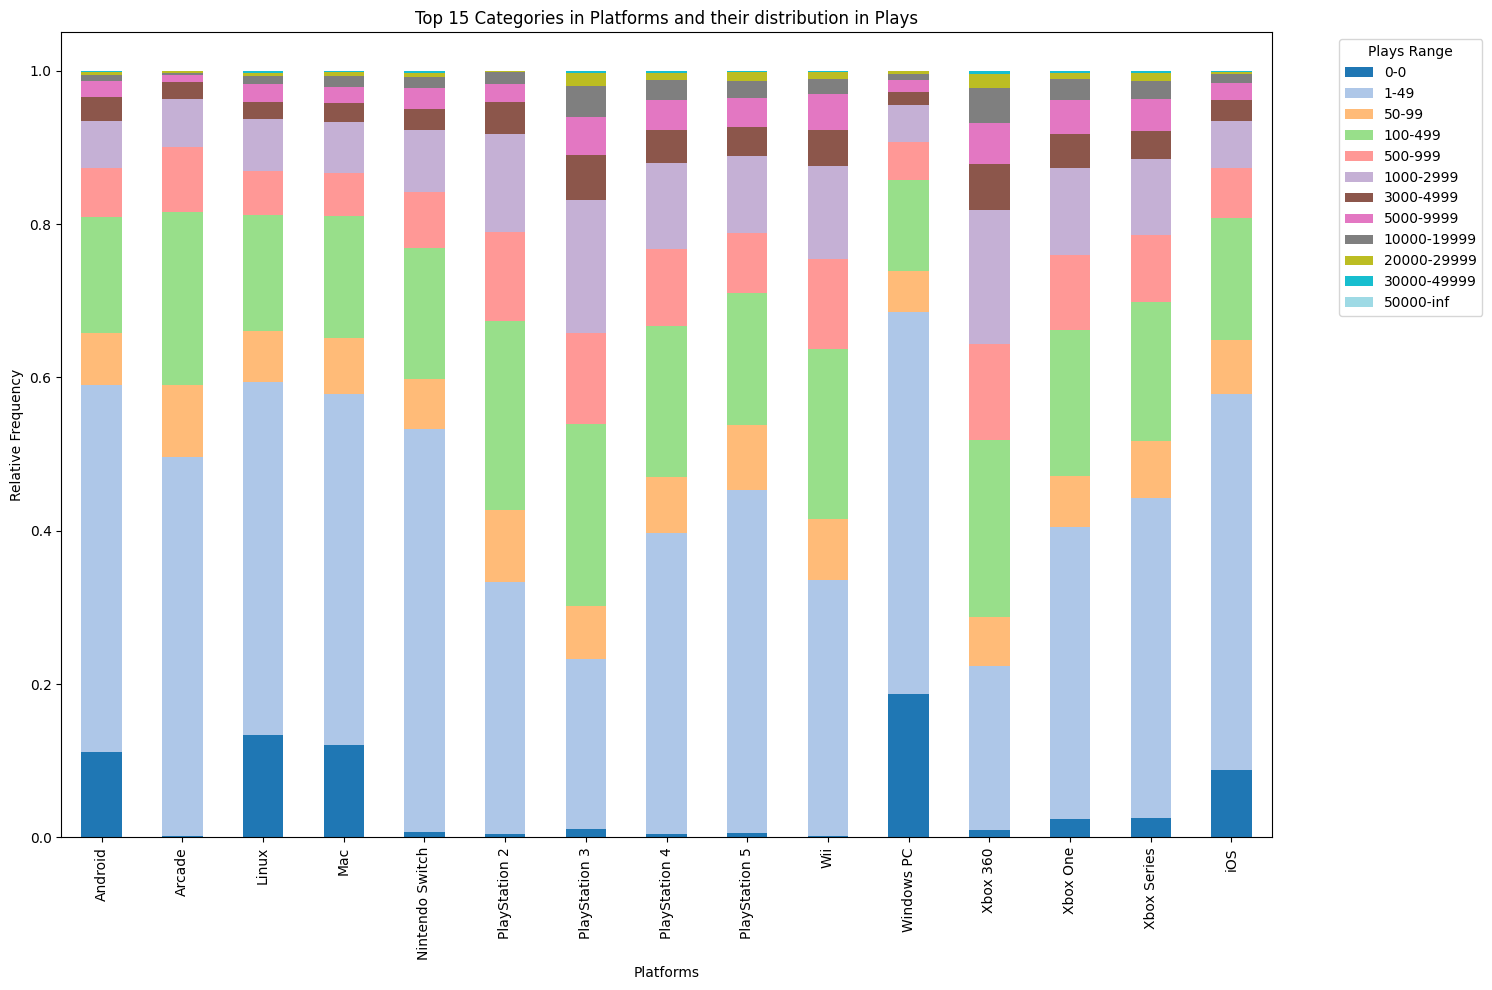

In [242]:
Funciones.plot_interactive_comparison_discreta_dos(df_exploded_platform, 'Platforms', df, 'Plays', 'GameID', top_n=15, bins_range=[0, 1, 50, 100, 500, 1000, 3000, 5000, 10000, 20000, 30000, 50000, np.inf], relative=True)

In [ ]:
'''
Los siguientes gráficos muestran las principales plataformas y su número total de veces jugadas. (*Modificar el top_n en caso de querer ver la distribución para mas plataformas.)

  - En términos generales, parecen tener una distribución similar en los esprectros medios y bajos, es decir, que las plataformas principales tienden a tener un porcentje cercano de videojuegos desde exitos moderados a muy altos.
  Probablemente la razón se encuentre en que la mayoría de juegos a partir de una popularidad notable están disponibles en la mayoría de las plataformas y estos se juegan de forma similar en estas plataformas

  - Existen casos que pueden destacar sobre el resto de plataformas. Por ejemplo, tanto las diferentes generaciones de 'Xbox' como de 'PlayStation' recogen segmentos de juegos muy o extremadamente populares, mientras que las plataformas de
  móviles y ordenadores no tantas.

  - En el caso contrario, en primer lugar sobresale el caso de 'Windows PC', ya que parece recoger el mayor número de juegos con menos popularidad tanto en términos absolutos como relativos. Le siguen de cerca las plataformas de ordenadores y de móvles.

  - Aun así, cabe a destacar ciertos casos donde parece que los juegos con más reproducciones se encuentran en los géneros 'Adventure', 'Shooter', 'Brawler' y 'RPG'.
  
'''

### **Relación entre 'Title' y 'Plays'**

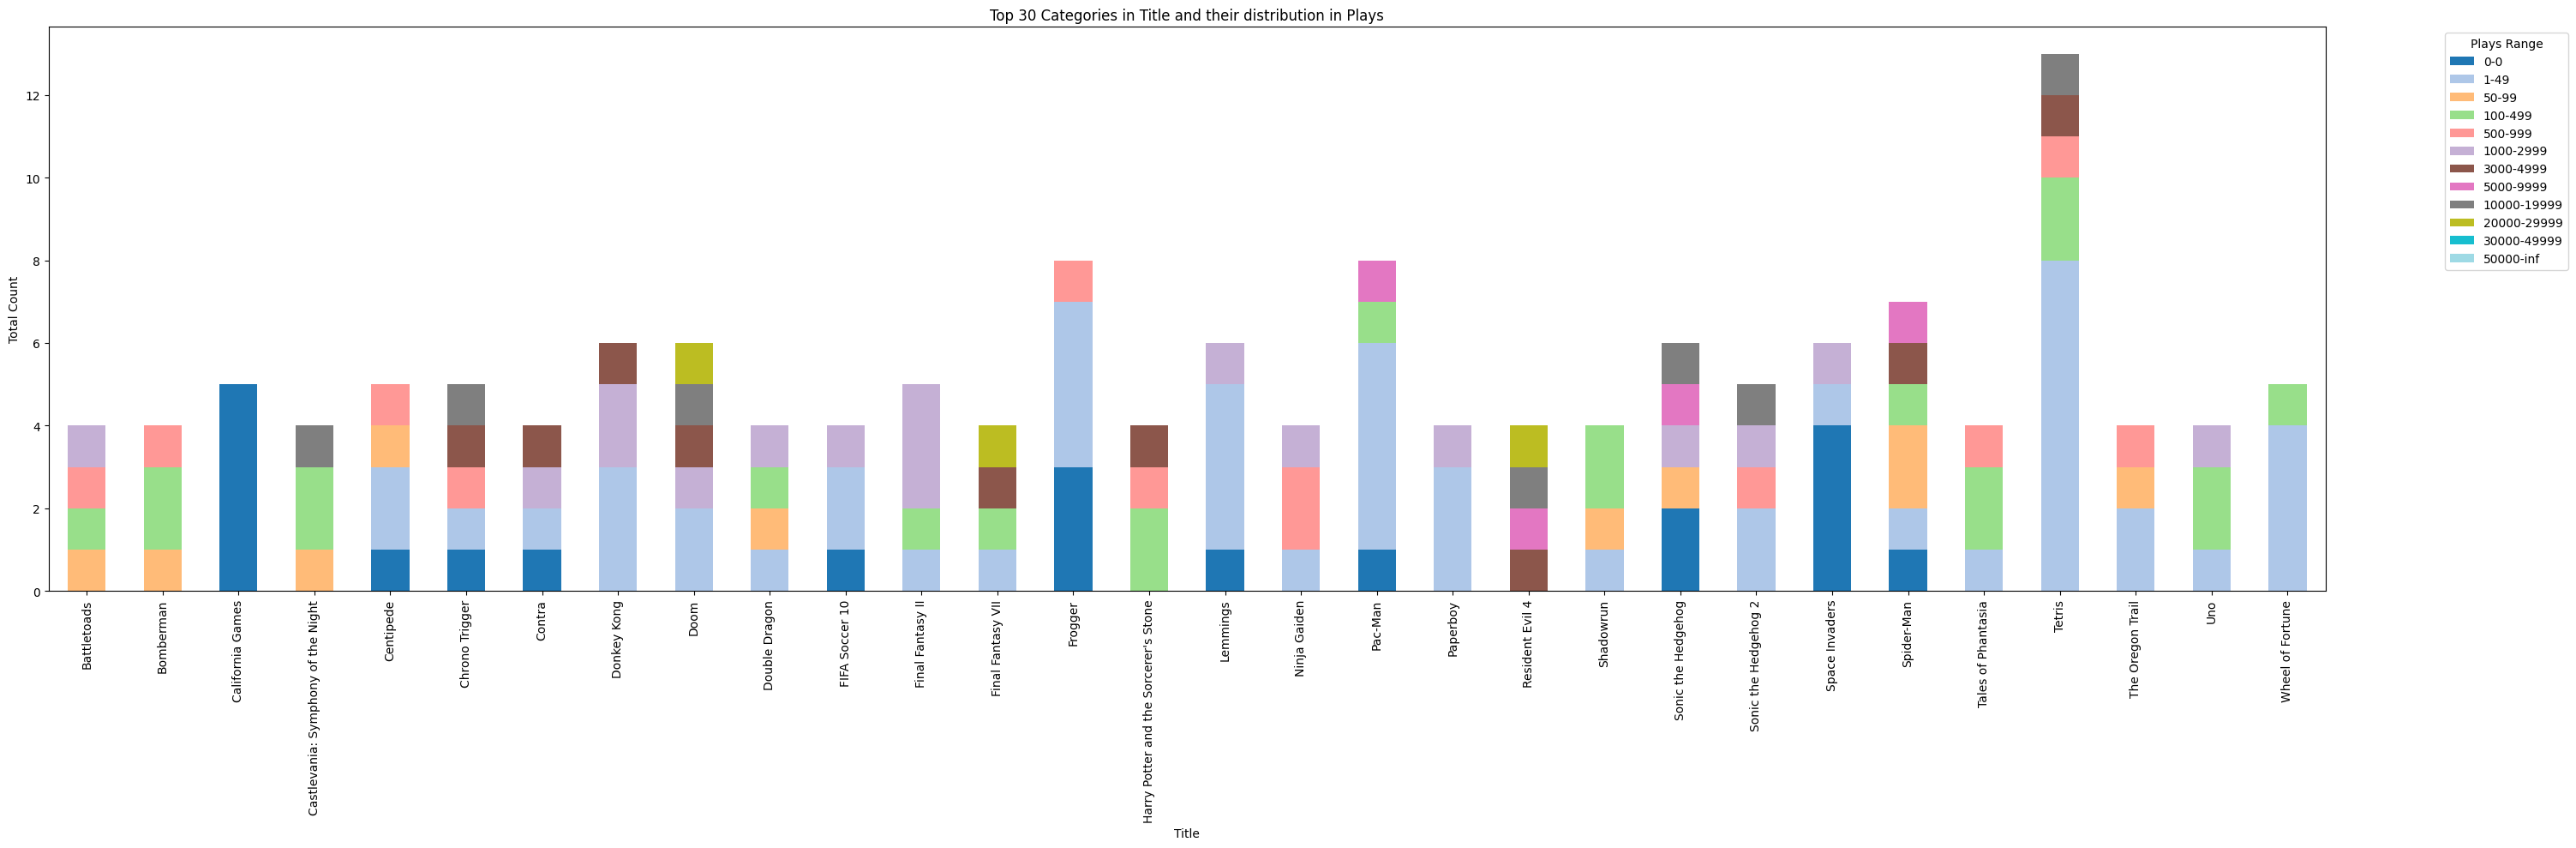

In [244]:
Funciones.plot_interactive_comparison_discreta_dos(df, 'Title', df, 'Plays', 'GameID', top_n=30, bins_range=[0, 1, 50, 100, 500, 1000, 3000, 5000, 10000, 20000, 30000, 50000, np.inf], relative=False)

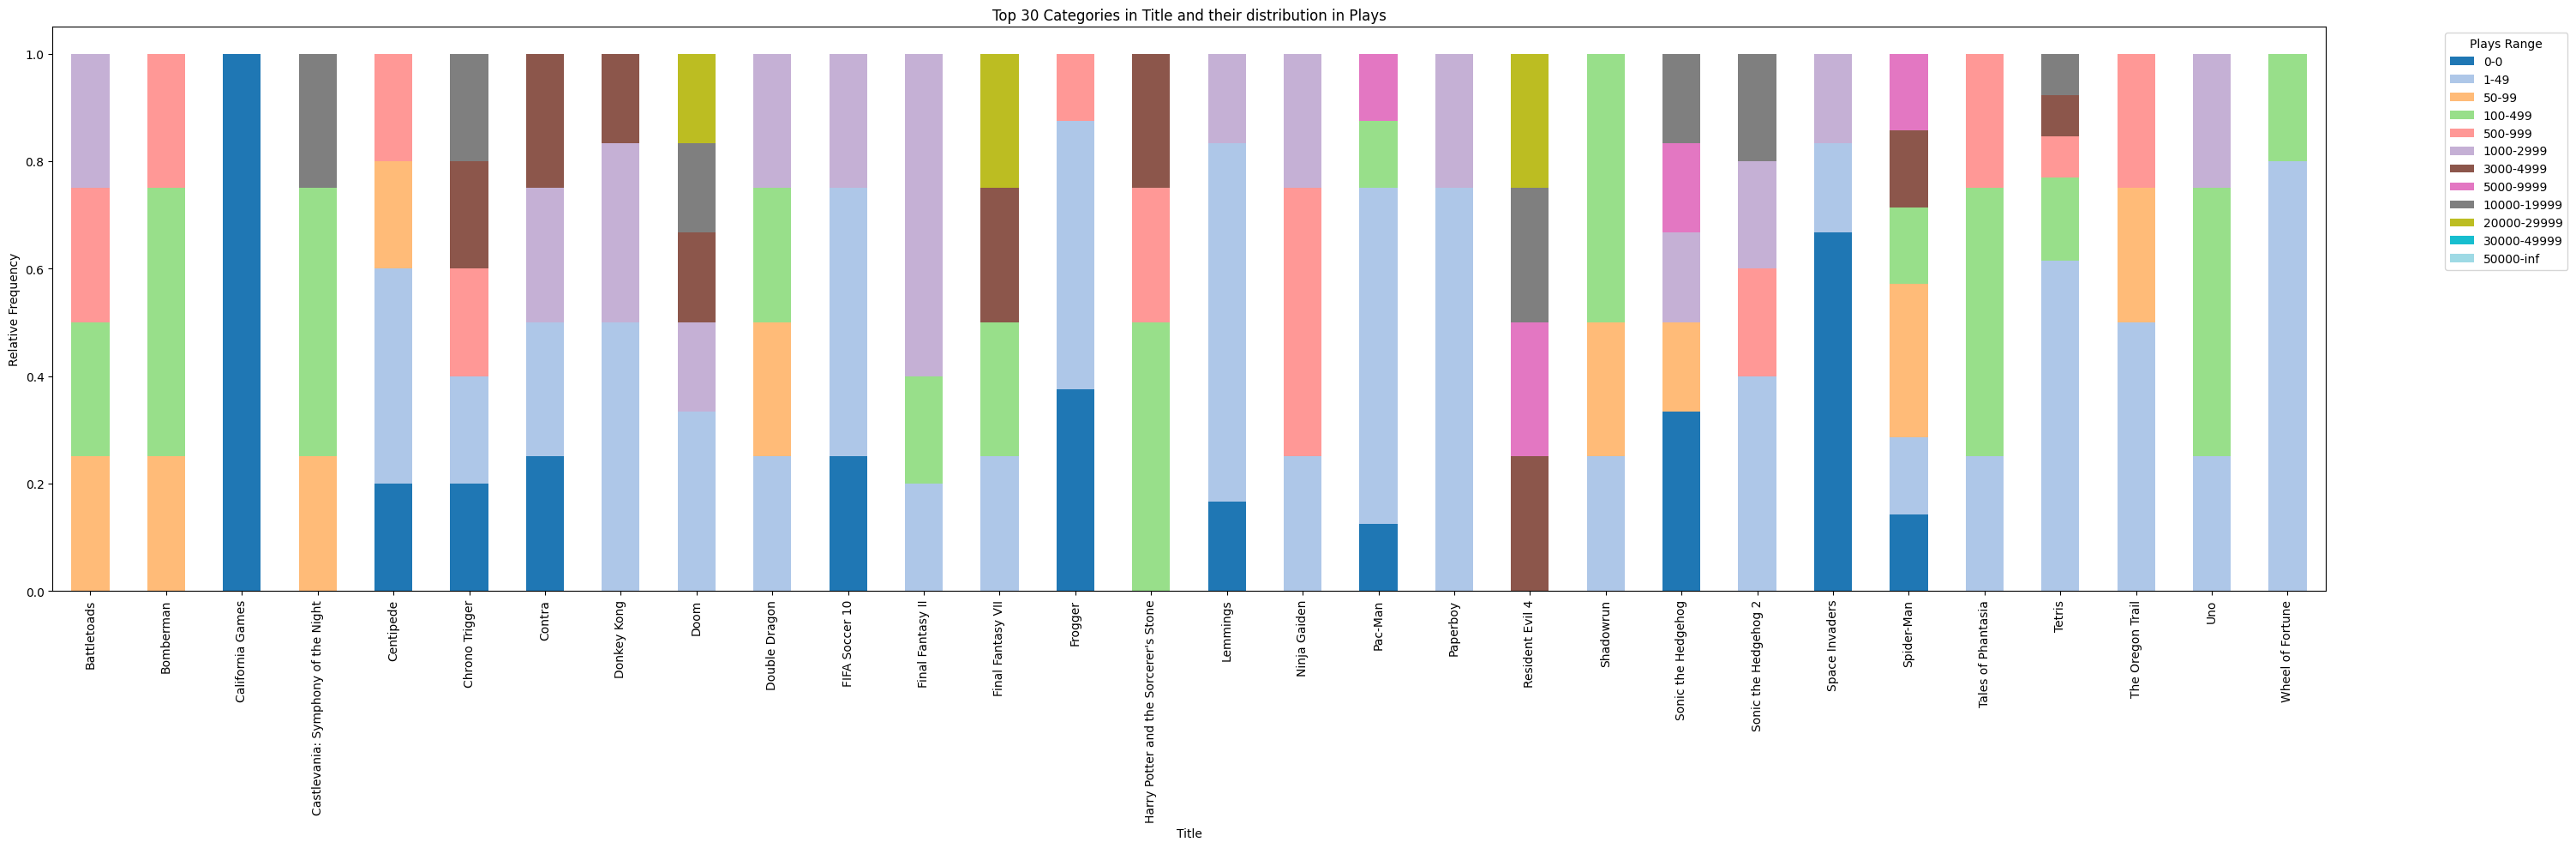

In [ ]:
Funciones.plot_interactive_comparison_discreta_dos(df, 'Title', df, 'Plays', 'GameID', top_n=30, bins_range=[0, 1, 50, 100, 500, 1000, 3000, 5000, 10000, 20000, 30000, 50000, np.inf], relative=True)

In [ ]:
'''
 - En la  siguiente gráfica se pueden observar aquellos juegos que tienen más versiones con el mismo nombre y el número de reproducciones. Es importante matizar que cada segmento no representa a un juego específico, sino a la versión o versiones
 que se enmarcan dentro de ese grupo de visualizaciones. Por ejemplo, en la gráfica absoluta 'Tetris' tiene un total de 13 versiones totales con ese mismo nombre, pero está formada por sólo 5 segmentos que representan en los segmentos en los que se enmarcan según sus reproducciones.

 - También es importante entender que aquí se reflejan aquellas versiones que tienen el mismo nombre exacto, puede que haya casos en los que se hayan creado versiones muy parecidas a un juego original pero se haya permitido ponerle otro nombre.

 - Otra razón por la que en ocasiones exiten varios juegos con el mismo título es porque la misma compañía hace un relase del mismo juego a una plataforma específica y lo llama igual.

- En líneas generales el primer dato a destacar es que en el caso de muchas versiones que se hacen de un juego, parecen quedarse en segmentos que representan una popularidad baja. 'Tetris' es un ejemplo: se trata del videjuego con más versiones hechas,
pero la mayoría de ellas tienden a ser impopulares. En cambio, también tiene varios segmentos de menor tamaño que determinan que han tenido mucho éxito.

- En línea con lo comentado, parece que la mayoría de títulos que tienes varios juegos comparten segmentos con versiones existosas. Es decir, probablemente la mayoría de las ocasiones en las que se hacen nuevos juegos con el mismo nombre es porque el primero o primeros
en llamarse así tuvieron éxito, y se trata de hacer otra versión aprovechando su renombre, ya sea una versión actualizada a los tiempos o el mismo juego pero optimizado para una plataforma en particular

- Como siempre existen excepciones a la regla, un ejemplo es 'Resident Evil 4' que cada una de sus 4 versiones va desde un numero medio de visualizaciones a un número alto, indicando que todas sus versiones han tenido un exito relativo medio o alto.

'''

<a id="Conclusiones-Combinadas"></a>
## Conclusiones Combinadas



### **Relación entre 'Genre' y 'Avg. Rating'**
- El análisis entre géneros y calificaciones promedio valida la idea de que,  en términos generales, no existe ningún género que destaque en gran medida por tener una nota media muy alta o muy baja respecto a los demás. Se puede observar cómo el análisis univariante de 'Avg. Rating' que vimos en su momento, indica que existe una variabilidad y dipersión muy moderada de sus valores en comparación con otras variables.
  
- En este sentido, existen muy pocos Géneros que se diferencien por su nota media, aunque de forma poco destacada géneros como RPG, Turn Based Strategy y Adventure tienden a obtener calificaciones más altas. Esto podría indicar una afinidad de los jugadores por estas categorías, o bien una mayor calidad en el desarrollo de juegos de estos géneros. 

- Por otro lado, géneros como MOBA, Quiz/Trivia y Racing tienden a tener calificaciones más bajas, lo que podría reflejar desafíos únicos en satisfacer a las audiencias de estos géneros o una saturación del mercado.


### **Relación entre 'Genre' y 'Plays'**
- En términos generales, se mantiene una distribución similar en la mayoría de los géneros, sobretodo en los valores extremos. Esto vuelve a validar la idea de que esta muestra de datos nos indica que hay
  muchos juegos que apenas han sido jugados y unos pocos son muy populares, y esta condición es aplicable a todos los géneros.

- En este sentido, sí existen variaciones en algunos géneros, sobretodo en aquellos que sus reproducciones e encuentran en un espectro medio.

- Aun así, cabe a destacar ciertos casos donde parece que los juegos con más reproducciones se encuentran en los géneros 'Adventure', 'Shooter', 'Brawler' y 'RPG'.

- En el caso opuesto, sí que existen géneros en los que las visualizaciones extremadamente bajas son más notorias. El que más destaca es el género 'Indie'. Es importante recordar que este género es el segundo
  en cuanto a número total de juegos, ocupando una cuota del 15% de juegos totales. Por sus propias características, tiene mucho sentido que este sea el que más juegos con pocas visualizaciones debido a que la mayoría de empresas
  pequeñas realizan este tipo de videjuegos. El resto de géneros también tienen un gran número de juegos no populares pero su reparto es bastante similar.
---

### **Relación entre 'Team' y 'Avg. Rating'**

- En términos generales, se mantiene una distribución moderada sin un gran número de valores en los extremos, como ya se ha explicado varias veces debido a la propia naturaleza de la variable 'Avg. Rating'

- En este sentido, aunque sí se pueden observar pequeñas varianzas en las notas medias, resulta curioso que incluso si se incluyen muchos más equipos en la comparativa, la estrctura se matiene parecida.

- Cabe a destacar, que aunque sin grandes diferencias, los equipos que tienen mejores valoraciones medias, son aquellos con más peso en el mercado (con más número de juegos) como es el caso de 'Nintendo', 'Capcom',
  'Sony' y 'Square Enix'.

- En el lado contrario, aunque sin una diferencia muy notable, de los equipos más grandes, 'Activision', 'Electronic Arts' y 'THQ' tienen las notas medias más bajas.


### **Relación entre 'Team' y 'Plays'**

- En términos generales, parecen tener una distribución similar en los esprectros bajos y medios, es decir juegos que no llegan a tener muchas visualizaciones. Cabe a destacar que estos segmentos en las partes bajas de la barra
  son mucho más pequeños comparados con el resto de equipos. Si por ejemplo, en vez de los 15 equipos principales, ponemos el top_n en 50, se puede observar que esotos segmentos crecen significativamente, lo que se puede traducir que
  las compañías con más juegos, que por ende son las más grandes, aunque ofrecan más juegos , estos suelen ser más jugados que los equipos medianos o pequeños que suelen tender a tener menos juegos y con menos visualizaciones.
 Dicho esto, es importante remarcar que existen excepciones, y en algunos casos, compañías que tienen poco recorrido son capaces de crear un juego exitosos.

  - De nuevo, el caso a destacar es 'Nintendo', debido a que tiene pocos juegos con pocas visualizaciones (comparado con el resto de empresas existosas) y además es el que ofrece el mayor número de juegos más populares del mercado.

  - Aun así, cabe a destacar ciertos casos donde parece que los juegos con más reproducciones se encuentran en los géneros 'Adventure', 'Shooter', 'Brawler' y 'RPG'.

  - En el caso opuesto, sí que existen géneros en los que las visualizaciones extremadamente bajas son más notorias. En este sentido, el que más destaca es el género 'Indie'. Es importante recordar que este género es el segundo
  en cuanto a número total de juegos, ocupando una cuota del 15% de juegos totales. Por sus propias características, tiene mucho sentido que este sea el que más juegos con pocas visualizaciones debido a que la mayoría de empresas
  pequeñas realizan este tipo de videjuegos. El resto de géneros también tienen un gran número de juegos no populares pero su reparto es bastante similar
---

### **Relación entre 'Platforms' y 'Avg. Rating'**

  - En términos generales, se mantiene una distribución moderada sin un gran número de valores en los extremos, como ya se ha explicado varias veces debido a la propia naturaleza de la variable 'Avg. Rating'

  - En este sentido, aunque sí se pueden observar pequeñas varianzas en las notas medias, resulta curioso que incluso, se incluyen muchos más equipos en la comparativa, la estrctura se matiene parecida.

  - Cabe a destacar el caso de 'Windows PC', que ofrece una gran cantidad de juegos en comparación al resto de plataformas. La mayoría de sus juegos tienen una nota media y de la otra mitad, 
  tiene un espectro de notas muy elevadas en comparación con el espectro de notas muy bajas que es más pequeño. Dicho en otras palabras, ofrece una gran cantidad de juegos donde dos tercios de los mismos tienden a tener notas medias
  o muy altas.

  - Otro dato curioso es el caso de las consolas 'PlayStation' y las primeras generaciones tenían un espectro de valoraciones medias más elevadas que las nuevas. La generación mejor valorada fue la 3, por lo que sería ineresante entender por qué,
  si se trabajara en Sony. (también hay que tener en cuenta que la 5 lleva muchos menos años pero igualmente sería interesante ver qué podría causar ese bajón)

  - En cuanto valoraciones medias y bajas, resulta interesante como, a priori no existen plataformas que en términos relativos tengan un segmento muy notable de valoraciones muy bajas respecto a las demás pltaformas.

### **Relación entre 'Platform' y 'Plays'**

 - En términos generales, parecen tener una distribución similar en los esprectros medios y bajos, es decir, que las plataformas principales tienden a tener un porcentje cercano de videojuegos desde exitos moderados a muy altos.
  Probablemente la razón se encuentre en que la mayoría de juegos a partir de una popularidad notable están disponibles en la mayoría de las plataformas y estos se juegan de forma similar en estas plataformas.

  - Existen casos que pueden destacar sobre el resto de plataformas. Por ejemplo, tanto las diferentes generaciones de 'Xbox' como de 'PlayStation' recogen segmentos de juegos muy o extremadamente populares, mientras que las plataformas de
  móviles y ordenadores no tantas.

  - En el caso contrario, en primer lugar sobresale el caso de 'Windows PC', ya que parece recoger el mayor número de juegos con menos popularidad tanto en términos absolutos como relativos. Le siguen de cerca las plataformas de ordenadores y de móvles.

  - Aun así, cabe a destacar ciertos casos donde parece que los juegos con más reproducciones se encuentran en los géneros 'Adventure', 'Shooter', 'Brawler' y 'RPG'.

---

### **Relación entre 'Title' y 'Plays'**

- En líneas generales el primer dato a destacar es que en el caso de muchas versiones que se hacen de un juego, parecen quedarse en segmentos que representan una popularidad baja. 'Tetris' es un ejemplo: se trata del videjuego con más versiones hechas,
pero la mayoría de ellas tienden a ser impopulares. En cambio, también tiene varios segmentos de menor tamaño que determinan que han tenido mucho éxito.

- En línea con lo comentado, parece que la mayoría de títulos que tienes varios juegos comparten segmentos con versiones existosas. Es decir, probablemente la mayoría de las ocasiones en las que se hacen nuevos juegos con el mismo nombre es porque el primero o primeros
en llamarse así tuvieron éxito, y se trata de hacer otra versión aprovechando su renombre, ya sea una versión actualizada a los tiempos o el mismo juego pero optimizado para una plataforma en particular.

- Como siempre existen excepciones a la regla, un ejemplo es 'Resident Evil 4' que cada una de sus 4 versiones va desde un numero medio de visualizaciones a un número alto, indicando que todas sus versiones han tenido un exito relativo medio o alto.



<a id="Relacion-Combinadas"></a>
## Relacion Numericas

In [ ]:
columnas_numericas = ['Avg. Rating', 'Times Listed', 'Plays', 'Playing', 'Backlogs', 'Wishlist']

En esta fórmula:

- $r$ es el coeficiente de correlación de Pearson.
- $x_i$ y $y_i$ son los valores individuales de las dos variables.
- $\bar{x}$ y $\bar{y}$ son las medias de las variables `x` y `y`, respectivamente.
- $n$ es el número de observaciones (parejas de valores).

El coeficiente $r$ varía entre -1 y 1, donde_
* 1 significa una correlación positiva perfecta 
* -1 una correlación negativa perfecta
* 0 indica que no hay correlación **lineal** entre las variables. [marco lineal en negrita porque puede haber otro tipo de relación]

### **Relación entre 'Plays' y 'Avg. Rating'**

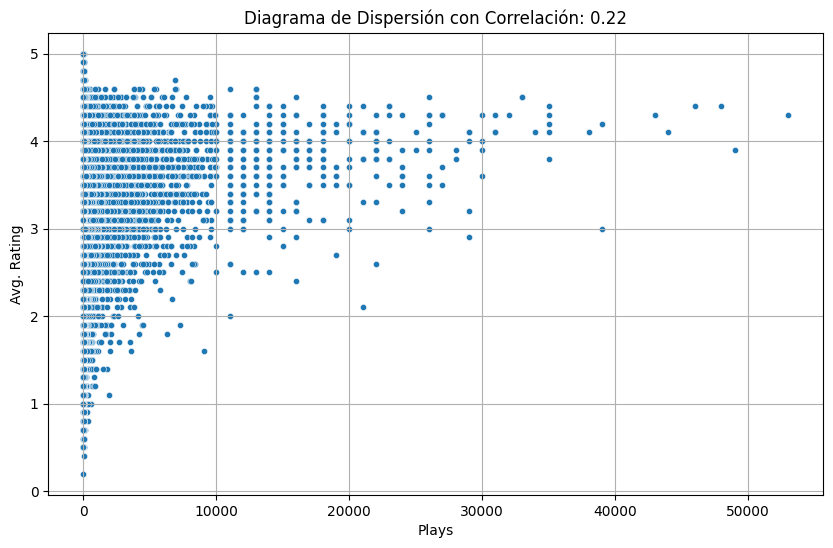

In [264]:
Funciones.grafico_dispersion_con_correlacion(df,"Plays","Avg. Rating", 20, mostrar_correlacion = True)
# los juegos con muchas visualizaciones tienden a tener mejores valoraciones

In [107]:
# Cálculo de los cuartiles
Q1 = df['Plays'].quantile(0.25)
Q3 = df['Plays'].quantile(0.75)
IQR = Q3 - Q1 # Cálculo de la caja central

# Número total de juegos dentro del IQR
iqr_plays = df[(df['Plays'] >= Q1) & (df['Plays'] <= Q3)]
total_iqr_plays = iqr_plays.shape[0]

# Porcentaje que estos representan en el dataframe
porcentaje_iqr_plays = (total_iqr_plays / len(df)) * 100

print(f"Número total de juegos dentro del IQR de la variable 'Plays': {total_iqr_plays}")
print(f"Porcentaje de juegos dentro del IQR de la variable 'Plays': {porcentaje_iqr_plays:.2f}%")

Número total de juegos dentro del IQR de la variable 'Plays': 18147
Porcentaje de juegos dentro del IQR de la variable 'Plays': 60.07%


In [116]:
from scipy.stats import pearsonr

pearsonr(df["Plays"], df["Avg. Rating"], alternative= "less")

PearsonRResult(statistic=0.21610615605670683, pvalue=1.0)

In [ ]:
'''
En el origen (cerca del cero en "Plays"):
Se observa una densa agrupación de puntos cerca del valor cero en el eje de "Plays". Este grupo representa una gran cantidad de juegos o aplicaciones con muy pocas reproducciones, 
lo que indica que podrían ser nuevos, menos populares o menos promocionados.
Dentro de este grupo, la "Avg Rating" varía ampliamente de 0 a 5. Esto puede sugerir que la calidad o la percepción de estos juegos no está directamente relacionada con su popularidad.

Rango bajo a medio de "Plays" (1 a 10,000):
A medida que avanzamos hacia la derecha, vemos que los puntos se vuelven menos densos, lo que implica que hay menos juegos que han alcanzado este nivel de reproducciones.
La "Avg Rating" de estos juegos tiende a estar generalmente por encima de 3, con muchos puntos concentrados entre 4 y 5. 
Esto puede indicar que los juegos con un número modesto de reproducciones tienden a ser bien valorados, posiblemente porque un juego bueno tiende a ser jugado más veces.

Rango medio de "Plays" (10,000 a 30,000):
En este rango, la densidad de puntos disminuye aún más, destacando que hay relativamente pocos juegos que alcanzan esta cantidad de reproducciones.
Los puntos en este rango siguen mostrando "Avg Rating" altos, generalmente entre 3.5 y 5, lo que refuerza la idea de que juegos con reproducciones moderadas a altas son generalmente bien valorados.

Rango alto de "Plays" (más de 30,000):
Los puntos aquí son muy escasos, indicando que solo unos pocos juegos logran un alto número de reproducciones.
Interesantemente, como has señalado, estos pocos juegos tienen "Avg Rating" en el extremo superior, principalmente por encima de 4, y no hay juegos con alta cantidad de reproducciones que tengan una valoración baja. 
Esto podría sugerir que existe una correlación positiva entre el número de reproducciones y las valoraciones altas, al menos en este rango. Es decir, los juegos que son muy jugados tienden a ser también muy bien valorados.

Datos Anómalos:
Por último, los puntos que están más alejados en el eje de "Plays" y hacia el extremo superior del eje de "Avg Rating" pueden considerarse valores atípicos. Estos representan juegos que no solo son populares en términos de reproducciones sino que también son altamente valorados. 
La ausencia de puntos en el extremo superior derecho con bajas calificaciones refuerza la idea de que los juegos muy jugados son, en general, también muy apreciados en términos de calidad o disfrute por parte de los jugadores.
'''

### **Relación entre 'Times Listed' y 'Avg. Rating'**

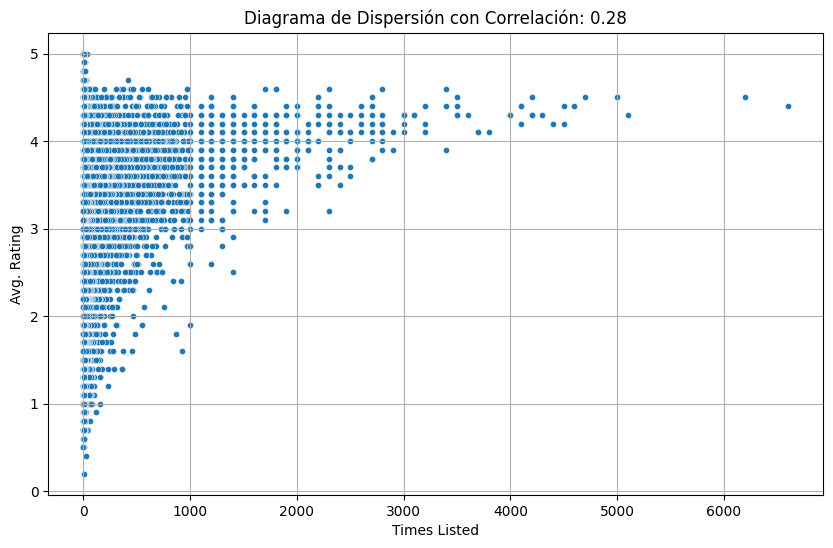

In [130]:
Funciones.grafico_dispersion_con_correlacion(df,"Times Listed","Avg. Rating", 20, mostrar_correlacion = True)

In [117]:
from scipy.stats import pearsonr

pearsonr(df["Times Listed"], df["Avg. Rating"], alternative= "less")

PearsonRResult(statistic=0.2777353797504977, pvalue=1.0)

In [ ]:
'''
En el origen (cercano al cero en "Times Listed"):
Hay una alta densidad de puntos cerca del valor cero en el eje X, lo que sugiere que muchos juegos han sido listados pocas veces. Esto podría indicar juegos nuevos, menos conocidos o aquellos que no han sido destacados en listados populares.
Las calificaciones promedio de estos juegos varían ampliamente, desde 0 hasta 5. La amplia gama de calificaciones sugiere que la frecuencia con la que un juego aparece en listas no es un indicador confiable de su calidad o aceptación por parte de la comunidad.

Rango bajo de "Times Listed" (1 a 1,000):
A medida que nos movemos a la derecha hacia este rango, los puntos están ligeramente más dispersos, lo que indica menos juegos que han sido listados en este rango de veces.
Las calificaciones promedio tienden a agruparse entre 3 y 5, con pocos juegos por debajo de 3. Esto podría sugerir que los juegos que se listan más a menudo tienden a ser mejor valorados, aunque aún hay una considerable cantidad de juegos con calificaciones más bajas.

Rango medio de "Times Listed" (1,000 a 3,000):
En este rango, los juegos son aún menos, y los puntos se distribuyen más uniformemente a lo largo del eje X.
La mayoría de estos juegos mantienen una "Avg. Rating" entre 3.5 y 5, lo que implica que los juegos que aparecen con frecuencia en listados tienden a ser bien valorados. 
Es interesante notar que no hay juegos con muchas listas y bajas calificaciones, lo que podría indicar una correlación positiva entre la visibilidad y la calidad percibida.

Rango alto de "Times Listed" (más de 3,000):
Los juegos en este rango son excepcionales en términos de frecuencia de aparición en listas, y son muy pocos.
Estos juegos mantienen calificaciones altas consistentemente por encima de 4. Esto podría indicar que hay una relación entre la frecuencia de aparición en listados y una alta calificación promedio, posiblemente debido a una mayor visibilidad que conlleva críticas más positivas o una selección de juegos de alta calidad que son listados con más frecuencia.

Datos Anómalos y Tendencias:
No hay una tendencia clara o lineal aparente en el gráfico, pero la falta de juegos con muchas listas y bajas calificaciones sugiere que ser listado con frecuencia puede estar asociado con una percepción de calidad más alta.
Los juegos con la máxima calificación de 5 están presentes en todos los rangos de "Times Listed", lo que indica que hay juegos altamente valorados independientemente de su visibilidad o frecuencia de aparición en listas.
'''

### **Relación entre 'Wishlist' y 'Avg. Rating'**

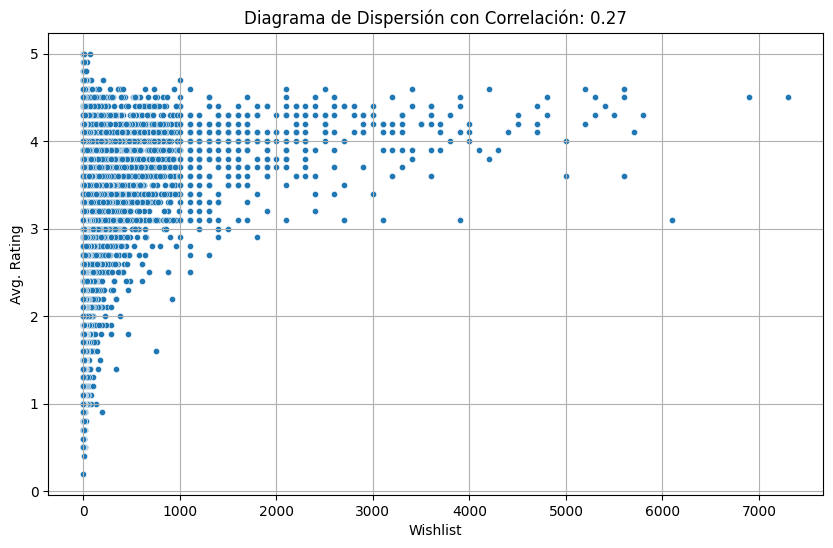

In [131]:
Funciones.grafico_dispersion_con_correlacion(df,"Wishlist","Avg. Rating", 20, mostrar_correlacion = True)

In [122]:
from scipy.stats import pearsonr

pearsonr(df["Wishlist"], df["Avg. Rating"], alternative= "less")

PearsonRResult(statistic=0.2712446567095884, pvalue=1.0)

In [ ]:
'''
En el origen (cerca del cero en "Wishlist"):
Existe una concentración densa de puntos cerca del valor cero en el eje X, lo que indica que hay un gran número de juegos que no están presentes o tienen muy pocas apariciones en las listas de deseos de los usuarios.
La "Avg. Rating" de estos juegos varía considerablemente, desde 0 hasta 5, lo que sugiere que estar en la lista de deseos de alguien no es un indicador directo de la calidad percibida del juego, al menos en términos de su calificación promedio.

Rango bajo de "Wishlist" (1 a 1,000):
Los puntos en este rango se dispersan un poco más y la densidad de puntos disminuye a medida que aumenta el número de apariciones en las listas de deseos.
Las calificaciones promedio de estos juegos parecen concentrarse principalmente entre 3 y 5, aunque todavía hay una cantidad notable de juegos con calificaciones por debajo de 3. 
Esto podría interpretarse como que los juegos que generan un interés moderado (apareciendo en algunas listas de deseos) tienden a ser calificados positivamente, pero no necesariamente de manera uniforme.

Rango medio de "Wishlist" (1,000 a 3,000):
A medida que nos adentramos en este rango, observamos que los puntos se dispersan aún más, indicando que hay menos juegos que han logrado entrar en un número medio de listas de deseos.
La "Avg. Rating" de los juegos en este rango tiende a estar por encima de 3, con una notable cantidad de puntos concentrados alrededor de 4 y por encima. 
Esto sugiere que los juegos que despiertan un interés considerable (suficiente para ser incluidos en más listas de deseos) generalmente reciben calificaciones más altas.

Rango alto de "Wishlist" (más de 3,000):
Los juegos que aparecen en este rango son relativamente pocos y están más dispersos en el gráfico.
Estos puntos tienden a tener una "Avg. Rating" alta, a menudo entre 4 y 5. Esto podría indicar que los juegos más deseados, aquellos que un gran número de personas espera jugar, suelen ser también juegos altamente valorados.

Datos Anómalos y Tendencias Generales:
No hay una tendencia clara o lineal en todo el gráfico que relacione directamente el número de apariciones en listas de deseos con las calificaciones promedio.
Sin embargo, parece haber una tendencia de que los juegos con más apariciones en las listas de deseos tienden a tener calificaciones promedio más altas, 
lo que sugiere que los juegos más anticipados o deseados por la comunidad son también juegos que tienden a ser bien recibidos una vez que se juegan
'''

In [247]:
#Funciones.grafico_dispersion_con_correlacion(df,"Playing","Plays", 20, mostrar_correlacion = True)

In [125]:
#pearsonr(df["Playing"], df["Plays"], alternative= "less")

PearsonRResult(statistic=0.6479019361653237, pvalue=1.0)

<a id="Conclusiones-Numericas"></a>
## Conclusiones Numericas

### **Relación entre 'Plays' y 'Avg. Rating'**

- **Resultado numérico:** el resultado de Pearson de aproximadamente 0.22 sugiere que hay una relación lineal positiva débil entre 'Plays' y 'Avg Rating'. Un p-valor de 1.0 indica que esta relación no es estadísticamente significativa.
Aunque a priori, no parezca que exista una relación estrecha entre estas dos variables a partir del resultado numérico, observando la gráfica si que parece que exista una relación. Esto podría ser causado por:
    - No existe una relación lineal perfecta
    - Una gran cantidad de datos agrupados cerca del origen (con pocos 'Plays') con un amplio rango de 'Avg Rating' puede diluir cualquier correlación que aparezca más clara en rangos más altos de 'Plays'.

- **Resultado visual:**
    - En el origen (cerca del cero en "Plays"):
    Se observa una densa agrupación de puntos cerca del valor cero en el eje de "Plays". Este grupo representa una gran cantidad de juegos o aplicaciones con muy pocas reproducciones, 
    lo que indica que podrían ser nuevos, menos populares o menos promocionados.
    Dentro de este grupo, la "Avg Rating" varía ampliamente de 0 a 5. Esto puede sugerir que la calidad o la percepción de estos juegos no está directamente relacionada con su popularidad.

    - Rango bajo a medio de "Plays" (1 a 10,000):
    A medida que avanzamos hacia la derecha, vemos que los puntos se vuelven menos densos, lo que implica que hay menos juegos que han alcanzado este nivel de reproducciones.
    La "Avg Rating" de estos juegos tiende a estar generalmente por encima de 3, con muchos puntos concentrados entre 4 y 5. 
    Esto puede indicar que los juegos con un número modesto de reproducciones tienden a ser bien valorados, posiblemente porque un juego bueno tiende a ser jugado más veces.

    - Rango medio de "Plays" (10,000 a 30,000):
    En este rango, la densidad de puntos disminuye aún más, destacando que hay relativamente pocos juegos que alcanzan esta cantidad de reproducciones.
    Los puntos en este rango siguen mostrando "Avg Rating" altos, generalmente entre 3.5 y 5, lo que refuerza la idea de que juegos con reproducciones moderadas a altas son generalmente bien valorados.

    - Rango alto de "Plays" (más de 30,000):
    Los puntos aquí son muy escasos, indicando que solo unos pocos juegos logran un alto número de reproducciones.
    Interesantemente, como has señalado, estos pocos juegos tienen "Avg Rating" en el extremo superior, principalmente por encima de 4, y no hay juegos con alta cantidad de reproducciones que tengan una valoración baja. 
    Esto podría sugerir que existe una correlación positiva entre el número de reproducciones y las valoraciones altas, al menos en este rango. Es decir, los juegos que son muy jugados tienden a ser también muy bien valorados.

    - Datos Anómalos:
    Por último, los puntos que están más alejados en el eje de "Plays" y hacia el extremo superior del eje de "Avg Rating" pueden considerarse valores atípicos. Estos representan juegos que no solo son populares en términos de reproducciones sino que también son altamente valorados. 
    La ausencia de puntos en el extremo superior derecho con bajas calificaciones refuerza la idea de que los juegos muy jugados son, en general, también muy apreciados en términos de calidad o disfrute por parte de los jugadores.

---

### **Relación entre 'Times Listed' y 'Avg. Rating'**

- **Resultado Numérico:** el resultado de Pearson de aproximadamente 0.28 sugiere que hay una relación lineal positiva débil entre 'Plays' y 'Avg Rating'. Un p-valor de 1.0 indica que esta relación no es estadísticamente significativa.
Aunque a priori, no parezca que exista una relación estrecha entre estas dos variables a partir del resultado numérico, observando la gráfica si que parece que exista una relación. Esto podría ser causado por:
    - No existe una relación lineal perfecta: podría ser que solo después de alcanzar un cierto umbral de 'Times Listed', las 'Avg Rating' comiencen a aumentar de manera notable.
    - Una gran cantidad de datos agrupados cerca del origen (con pocos 'Plays') con un amplio rango de 'Avg Rating' puede diluir cualquier correlación que aparezca más clara en rangos más altos de 'Plays'.


- **Resultado visual:**
    - En el origen (cercano al cero en "Times Listed"):
    Hay una alta densidad de puntos cerca del valor cero en el eje X, lo que sugiere que muchos juegos han sido listados pocas veces. Esto podría indicar juegos nuevos, menos conocidos o aquellos que no han sido destacados en listados populares.
    Las calificaciones promedio de estos juegos varían ampliamente, desde 0 hasta 5. La amplia gama de calificaciones sugiere que la frecuencia con la que un juego aparece en listas no es un indicador confiable de su calidad o aceptación por parte de la comunidad.

    - Rango bajo de "Times Listed" (1 a 1,000):
    A medida que nos movemos a la derecha hacia este rango, los puntos están ligeramente más dispersos, lo que indica menos juegos que han sido listados en este rango de veces.
    Las calificaciones promedio tienden a agruparse entre 3 y 5, con pocos juegos por debajo de 3. Esto podría sugerir que los juegos que se listan más a menudo tienden a ser mejor valorados, aunque aún hay una considerable cantidad de juegos con calificaciones más bajas.

    - Rango medio de "Times Listed" (1,000 a 3,000):
    En este rango, los juegos son aún menos, y los puntos se distribuyen más uniformemente a lo largo del eje X.
    La mayoría de estos juegos mantienen una "Avg. Rating" entre 3.5 y 5, lo que implica que los juegos que aparecen con frecuencia en listados tienden a ser bien valorados. 
    Es interesante notar que no hay juegos con muchas listas y bajas calificaciones, lo que podría indicar una correlación positiva entre la visibilidad y la calidad percibida.

    - Rango alto de "Times Listed" (más de 3,000):
    Los juegos en este rango son excepcionales en términos de frecuencia de aparición en listas, y son muy pocos.
    Estos juegos mantienen calificaciones altas consistentemente por encima de 4. Esto podría indicar que hay una relación entre la frecuencia de aparición en listados y una alta calificación promedio, posiblemente debido a una mayor visibilidad que conlleva críticas más positivas o una selección de juegos de alta calidad que son listados con más frecuencia.

    - Datos Anómalos y Tendencias:
    No hay una tendencia clara o lineal aparente en el gráfico, pero la falta de juegos con muchas listas y bajas calificaciones sugiere que ser listado con frecuencia puede estar asociado con una percepción de calidad más alta.
    Los juegos con la máxima calificación de 5 están presentes en todos los rangos de "Times Listed", lo que indica que hay juegos altamente valorados independientemente de su visibilidad o frecuencia de aparición en listas.

---

### **Relación entre 'Wishlist' y 'Avg. Rating'**

- **Resultado numérico:** el resultado de Pearson de aproximadamente 0.27 sugiere que hay una relación lineal positiva débil entre 'Plays' y 'Avg Rating'. Un p-valor de 1.0 indica que esta relación no es estadísticamente significativa.
Aunque a priori, no parezca que exista una relación estrecha entre estas dos variables a partir del resultado numérico, observando la gráfica si que parece que exista una relación. Esto podría ser causado por:
    - No existe una relación lineal perfecta
    - Una gran cantidad de datos agrupados cerca del origen (con pocos 'Plays') con un amplio rango de 'Avg Rating' puede diluir cualquier correlación que aparezca más clara en rangos más altos de 'Plays'.


- **Resultado visual:**
    - En el origen (cerca del cero en "Wishlist"):
    Existe una concentración densa de puntos cerca del valor cero en el eje X, lo que indica que hay un gran número de juegos que no están presentes o tienen muy pocas apariciones en las listas de deseos de los usuarios.
    La "Avg. Rating" de estos juegos varía considerablemente, desde 0 hasta 5, lo que sugiere que estar en la lista de deseos de alguien no es un indicador directo de la calidad percibida del juego, al menos en términos de su calificación promedio.

    - Rango bajo de "Wishlist" (1 a 1,000):
    Los puntos en este rango se dispersan un poco más y la densidad de puntos disminuye a medida que aumenta el número de apariciones en las listas de deseos.
    Las calificaciones promedio de estos juegos parecen concentrarse principalmente entre 3 y 5, aunque todavía hay una cantidad notable de juegos con calificaciones por debajo de 3. 
    Esto podría interpretarse como que los juegos que generan un interés moderado (apareciendo en algunas listas de deseos) tienden a ser calificados positivamente, pero no necesariamente de manera uniforme.

    - Rango medio de "Wishlist" (1,000 a 3,000):
    A medida que nos adentramos en este rango, observamos que los puntos se dispersan aún más, indicando que hay menos juegos que han logrado entrar en un número medio de listas de deseos.
    La "Avg. Rating" de los juegos en este rango tiende a estar por encima de 3, con una notable cantidad de puntos concentrados alrededor de 4 y por encima. 
    Esto sugiere que los juegos que despiertan un interés considerable (suficiente para ser incluidos en más listas de deseos) generalmente reciben calificaciones más altas.

    - Rango alto de "Wishlist" (más de 3,000):
    Los juegos que aparecen en este rango son relativamente pocos y están más dispersos en el gráfico.
    Estos puntos tienden a tener una "Avg. Rating" alta, a menudo entre 4 y 5. Esto podría indicar que los juegos más deseados, aquellos que un gran número de personas espera jugar, suelen ser también juegos altamente valorados.

    - Datos Anómalos y Tendencias Generales:
    No hay una tendencia clara o lineal en todo el gráfico que relacione directamente el número de apariciones en listas de deseos con las calificaciones promedio.
    Sin embargo, parece haber una tendencia de que los juegos con más apariciones en las listas de deseos tienden a tener calificaciones promedio más altas, 
    lo que sugiere que los juegos más anticipados o deseados por la comunidad son también juegos que tienden a ser bien recibidos una vez que se juegan

In [265]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30208 entries, 0 to 30207
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Title         30208 non-null  object        
 1   Release Date  30208 non-null  datetime64[ns]
 2   Team          30208 non-null  object        
 3   Avg. Rating   30208 non-null  float64       
 4   Times Listed  30208 non-null  int64         
 5   Genres        30208 non-null  object        
 6   Summary       30208 non-null  object        
 7   Reviews       30208 non-null  object        
 8   Platforms     30208 non-null  object        
 9   Plays         30208 non-null  int64         
 10  Playing       30208 non-null  int64         
 11  Backlogs      30208 non-null  int64         
 12  Wishlist      30208 non-null  int64         
 13  GameID        30208 non-null  int64         
 14  range         30208 non-null  category      
dtypes: category(1), datetime64[ns](1), f

In [266]:
df.to_csv('data/backloggd_dataset_limpio_dos.csv', index=False)